In [1]:
import numpy as np
import meep as mp
from meep import mpb
import matplotlib.pyplot as plt
import time as time

from numpy.core.fromnumeric import shape
# from libeigen6 import eigs_PCs

# define a function to call mpb to calculate the band
def eigs_PCs(Px, Py, kx, ky, N_max, flag, Polarflag):
    kx_ = kx/(2*np.pi)
    ky_ = ky/(2*np.pi)
    res = 32
    r1 = 181 / 385 / np.sqrt(3)
    r2 = 81 / 385 / np.sqrt(3)
    geometry_lattice = mp.Lattice(size=mp.Vector3(1, 1),
                                  basis1=mp.Vector3(1, 0),
                                  basis2=mp.Vector3(0.5, np.sqrt(3) / 2)
                                  )
    k_points = [mp.cartesian_to_reciprocal(mp.Vector3(kx_, ky_), geometry_lattice)]
    geometry = [mp.Cylinder(r1, center=mp.Vector3(0, 0), material=mp.Medium(index=1)),
                mp.Cylinder(r2, center=mp.Vector3(1 / 3, 1 / 3), material=mp.Medium(index=1))]
    ms = mpb.ModeSolver(
        geometry=geometry,
        geometry_lattice=geometry_lattice,
        default_material=mp.Medium(index=3.47),
        k_points=k_points,
        resolution=res,
        num_bands=N_max
    )

    fields = []

    def get_efields(ms, band):
        fields.append(ms.get_efield(band, bloch_phase=False))

    def get_hfields(ms, band):
        fields.append(ms.get_hfield(band, bloch_phase=False))

    if Polarflag:
        ms.run_te(mpb.output_at_kpoint(k_points[0], mpb.fix_hfield_phase, get_hfields))
        eps = ms.get_mu()
        eps_te = ms.get_epsilon()
    else:
        ms.run_tm(mpb.output_at_kpoint(k_points[0], mpb.fix_efield_phase, get_efields))
        eps = ms.get_epsilon()

    freqss = ms.all_freqs

    converted_eps = eps.T
    converted = []
    for f in fields:
        # 三个点这个语法就是前面的若干项都省略不写
        f = f[..., 0, 2]
        # f.shape: [nx, ny, nz, 3]，前面3个是网格，第4个参数从0到2是表示Ex Ey Ez
        converted.append(f)
   

    return freqss.flatten()*2*np.pi/Px, converted, np.reshape(np.array(converted), (N_max, -1)).T, np.array(converted_eps).flatten(), eps_te.T
    #返回的3个值分别是频率，场，和eps


In [2]:
# Valley chen number 
do_chern = True  # do Chern Number Calc
do_band = False  # do Band Structure Calc
Pxg = 1  # lattice constant along x
Pyg = 1  # lattice constant along y
N_sam = 10  # Brillouin sampling points ***
N_max = 2  # maximum band number ***
np.set_printoptions(precision=3, suppress=True)

Polarflag = 1  # 极化方式，0，TM极化；1，TE极化

shifted = 0.0
Nkxg = 200
Nkyg = 1
Pkxg = (4 * np.pi ) / Pxg / np.sqrt(3)
Pkyg = (4 * np.pi ) / Pyg / np.sqrt(3)
deltakxg = Pkxg / Nkxg
deltakyg = Pkyg / Nkyg
NK = Nkxg * Nkyg
kcx = np.zeros((NK, 4))
kcy = np.zeros((NK, 4))
# initialized
fieldTot = np.zeros(N_max)
ChernNumber = np.zeros(N_max)
fieldtemp = np.zeros(N_max, dtype=complex)
N_Lband = 1
N_Hband = 2
fieldTotComposite = 0
ChernNumberComposite = 0
fieldtempComposite = 0

if do_chern:
    time_s = time.time()
    fields = []
    fields_cur = np.zeros((Nkxg, N_max))
    for m in range(Nkxg+1):
        for n in range(Nkyg+1):
            print('Calculating', m * (Nkyg+1) + n + 1, 'of', (Nkxg+1) * (Nkyg+1), '...')
            omega, f, field_temp, eps_arr, eps = eigs_PCs(Pxg, Pyg,
                                                          # valley photonic crystal K Path
                                                  #(m+0.5-Nkxg/2) * deltakxg * np.sqrt(3), (n-0.5) * deltakxg,  #扫描顶点边，从-pi到+pi，重现董建文论文
                                                  (m  + 0.5) * deltakxg * np.sqrt(3) / 4, # 扫描平行四边形Kx
                                                  (n - Nkyg / 2 + 0.5) * deltakyg - (m + 0.5) * deltakxg / 4, # 扫描Ky，要键入kx的1/2
                                                  #(n + 0.5) * deltakyg / 2 - (m - Nkxg / 2 + 0.5) * deltakxg / 2, 
                                                  N_max, 0, Polarflag)
            fields.append(field_temp)

    print(shape(f))

    for m in range(Nkxg):
        for n in range(Nkyg):
            field1 = fields[m*(Nkyg+1)+n] #将平行四边形分割成若干小网格，每个网格的四个顶点
            field4 = fields[m*(Nkyg+1)+n+1]
            field3 = fields[(m+1)*(Nkyg+1)+n+1]
            field2 = fields[(m+1)*(Nkyg+1)+n]

            for mm in range(N_max): #对每一个能带计算陈数
                temp = field1[:, mm].conj().T * eps_arr @ field2[:, mm] #一行乘以一列变成一个数
                fieldtemp[mm] = temp / np.abs(temp)
                temp = field2[:, mm].conj().T * eps_arr @ field3[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp) #这里是把前面的值再乘新值
                temp = field3[:, mm].conj().T * eps_arr @ field4[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp)
                temp = field4[:, mm].conj().T * eps_arr @ field1[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp)
                fields_cur[m, mm] = -np.imag(np.log(fieldtemp[mm]))/(deltakxg**2*np.sqrt(3))
                fieldTot[mm] = fieldTot[mm] + np.imag(np.log(fieldtemp[mm]))

            #print('total', fieldTot)


# 下面是计算简并点的陈数
            fieldt1 = (field1[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field2[:, N_Lband-1:N_Hband]) @ \
                      (field2[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field3[:, N_Lband-1:N_Hband]) @ \
                      (field3[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field4[:, N_Lband-1:N_Hband]) @ \
                      (field4[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field1[:, N_Lband-1:N_Hband])
            fieldtempComposite = np.linalg.det(fieldt1)
            fieldtempComposite = fieldtempComposite / np.abs(fieldtempComposite)
            fieldTotComposite = fieldTotComposite + np.imag(np.log(fieldtempComposite))

 

    print('Elapsed:', time.time() - time_s)
    ChernNumber = fieldTot / 2 / np.pi
    ChernNumberComposite = fieldTotComposite / 2 / np.pi
    print('Chern Number', ChernNumber)

Calculating 1 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0012499999999999998, -1.0842021724855044e-19, 0.0>
elapsed time for initialization: 0.03294515609741211
solve_kpoint (0.00125,-1.0842e-19,0):
tefreqs:, k i

    iteration   13: trace = 0.1701765693188477 (0.338563% change)
    iteration   14: trace = 0.1695861764526305 (0.347532% change)
    iteration   15: trace = 0.1689568968251596 (0.371757% change)
    iteration   16: trace = 0.1682420322883971 (0.424002% change)
    iteration   17: trace = 0.167357864827391 (0.526918% change)
    iteration   18: trace = 0.1661561752763805 (0.720623% change)
    iteration   19: trace = 0.1644069616560335 (1.05832% change)
    iteration   20: trace = 0.1619024163458094 (1.53507% change)
    iteration   21: trace = 0.1587180368508401 (1.98639% change)
    iteration   22: trace = 0.1551520972159501 (2.27224% change)
    iteration   23: trace = 0.1514472473432331 (2.41674% change)
    iteration   24: trace = 0.1478032958562805 (2.43539% change)
    iteration   25: trace = 0.1443767048364069 (2.34553% change)
    iteration   26: trace = 0.1412808819971501 (2.16751% change)
    iteration   27: trace = 0.1385632539195636 (1.94224% change)
    iteration   28: 

    iteration    6: trace = 0.1523024652439776 (3.04257% change)
    iteration    7: trace = 0.1485309871072107 (2.50735% change)
    iteration    8: trace = 0.1451296282289999 (2.31652% change)
    iteration    9: trace = 0.1409323170602034 (2.93455% change)
    iteration   10: trace = 0.1358105885797743 (3.70143% change)
    iteration   11: trace = 0.1314203888825505 (3.2857% change)
    iteration   12: trace = 0.1294397710730333 (1.51853% change)
    iteration   13: trace = 0.128425484230228 (0.78668% change)
    iteration   14: trace = 0.127817786426446 (0.474313% change)
    iteration   15: trace = 0.1274883262218853 (0.25809% change)
    iteration   16: trace = 0.1272734860977037 (0.16866% change)
    iteration   17: trace = 0.1271565895280283 (0.091889% change)
    iteration   18: trace = 0.1271147258302772 (0.0329284% change)
    iteration   19: trace = 0.127095246077132 (0.0153257% change)
    iteration   20: trace = 0.1270840558492605 (0.00880499% change)
    iteration   21: 

    iteration   11: trace = 0.127126602425792 (0.123024% change)
    iteration   12: trace = 0.1270831021702784 (0.0342239% change)
    iteration   13: trace = 0.1270711862876696 (0.00937689% change)
    iteration   14: trace = 0.1270677384997969 (0.00271331% change)
    iteration   15: trace = 0.127067035672887 (0.000553114% change)
    iteration   16: trace = 0.1270667378987951 (0.000234344% change)
    iteration   17: trace = 0.127066566505706 (0.000134884% change)
    iteration   18: trace = 0.1270664862877365 (6.31307e-05% change)
    iteration   19: trace = 0.1270664559888025 (2.38449e-05% change)
    iteration   20: trace = 0.1270664489130366 (5.56856e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, 0.00625, 1, 0, 1.15111, 0.00275645, 0.356453
elapsed time for k point: 0.04892611503601074
Fixing h-field (band 1) phase by -0.388324 + -0.921523i; max ampl. = 1.07384
Fixing h-field (band 2) phase by -0.832223 + -0.554441i; max ampl. = 2.54912
total e

    iteration    3: trace = 0.1774515840329761 (11.3149% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.167876681640115 (5.54539% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1583748116281166 (5.82487% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1361584932866355 (15.0858% change)
    linmin: converged after 6 iterations.
    switching to approximate line minimization (decrease time by 57.8078%)
    iteration    7: trace = 0.1307119890290759 (4.08176% change)
    switching back to exact line minimization
    iteration    8: trace = 0.1284380427781816 (1.75493% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 95.4972%)
    iteration    9: trace = 0.1277146886789511 (0.564783% change)
    iteration   10: trace = 0.1274137582854444 (0.235905% change)
    iteration   11: trace = 0.1273061957153258 (0.0844556% change)
    it

    iteration   14: trace = 0.1270508355446135 (0.0141261% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 65.9912%)
    iteration   15: trace = 0.1270416210035929 (0.0072529% change)
    iteration   16: trace = 0.1270398891038595 (0.00136326% change)
    iteration   17: trace = 0.1270392640914843 (0.000491982% change)
    iteration   18: trace = 0.1270386572191509 (0.000477706% change)
    iteration   19: trace = 0.1270383157222368 (0.000268814% change)
    iteration   20: trace = 0.127038008249496 (0.000242032% change)
    iteration   21: trace = 0.1270379064850314 (8.01056e-05% change)
    iteration   22: trace = 0.1270378885836958 (1.40913e-05% change)
    iteration   23: trace = 0.1270378817594308 (5.37183e-06% change)
Finished solving for bands 1 to 2 after 23 iterations.
tefreqs:, 1, 0.01125, 1, 0, 1.14826, 0.00496156, 0.356389
elapsed time for k point: 0.043996334075927734
Fixing h-field (band 1) phase by -0.553

Fixing h-field (band 1) phase by -0.553251 + -0.833014i; max ampl. = 1.07417
Fixing h-field (band 2) phase by -0.408566 + -0.912729i; max ampl. = 2.54664
total elapsed time for run: 0.06158852577209473
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 13 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 o

Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.01875, 1.734723475976807e-18, 0.0>
elapsed time for initialization: 0.03562021255493164
solve_kpoint (0.01875,1.73472e-18,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 17 iterations.
    iteration    1: trace = 0.3807874128077123 (198.667% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1695431788883378 (76.7699% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1497994451795204 (12.3652% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1394824771580746 (7.13281% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 72.0244%)
    iteration    5: trace = 0.1349361255248191 (3.31344% ch

    iteration    6: trace = 0.1300107976731696 (3.71481% change)
    iteration    7: trace = 0.1329908171720285 (2.26616% change)
    iteration    8: trace = 0.1335983447008899 (0.455778% change)
    iteration    9: trace = 0.1286642846417684 (3.76269% change)
    iteration   10: trace = 0.1276974066241302 (0.754308% change)
    iteration   11: trace = 0.1274033375185937 (0.230551% change)
    iteration   12: trace = 0.1272226413417799 (0.141931% change)
    iteration   13: trace = 0.1270753271815354 (0.115859% change)
    iteration   14: trace = 0.1270115075207876 (0.0502345% change)
    iteration   15: trace = 0.1269777924383748 (0.0265484% change)
    iteration   16: trace = 0.1269500052219371 (0.0218859% change)
    iteration   17: trace = 0.1269369619763641 (0.0102748% change)
    iteration   18: trace = 0.1269327044474791 (0.00335411% change)
    iteration   19: trace = 0.1269313068094264 (0.00110109% change)
    iteration   20: trace = 0.1269305729222932 (0.000578178% change)
  

    iteration   14: trace = 0.1269032523285997 (0.0117224% change)
    iteration   15: trace = 0.1268977677211931 (0.00432197% change)
    iteration   16: trace = 0.1268952250969715 (0.0020037% change)
    iteration   17: trace = 0.1268942232985133 (0.000789472% change)
    iteration   18: trace = 0.1268939401242934 (0.000223158% change)
    iteration   19: trace = 0.1268937783032762 (0.000127525% change)
    iteration   20: trace = 0.1268936712356322 (8.43758e-05% change)
    iteration   21: trace = 0.1268935971614585 (5.8375e-05% change)
    iteration   22: trace = 0.1268935478935159 (3.88262e-05% change)
    iteration   23: trace = 0.1268935081831694 (3.12942e-05% change)
    iteration   24: trace = 0.1268934926436563 (1.22461e-05% change)
    iteration   25: trace = 0.1268934870587339 (4.40127e-06% change)
Finished solving for bands 1 to 2 after 25 iterations.
tefreqs:, 1, 0.02375, -1.73472e-18, 0, 0.0274241, 0.0104738, 0.356067
elapsed time for k point: 0.05388283729553223
Fixing 

Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, 0.02625, 0, 0, 0.0303109, 0.0115761, 0.355977
elapsed time for k point: 0.06287646293640137
Fixing h-field (band 1) phase by 0.461884 + -0.88694i; max ampl. = 1.07511
Fixing h-field (band 2) phase by -0.748548 + 0.663081i; max ampl. = 2.59274
total elapsed time for run: 0.08797311782836914
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 22 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, a

    linmin: converged after 2 iterations.
    iteration   21: trace = 0.1267616872113169 (5.45265e-06% change)
Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, 0.03125, 0, 0, 0.0360844, 0.0137805, 0.355769
elapsed time for k point: 0.04212546348571777
Fixing h-field (band 1) phase by 0.462089 + -0.886834i; max ampl. = 1.07532
Fixing h-field (band 2) phase by -0.7855 + 0.618861i; max ampl. = 2.58958
total elapsed time for run: 0.06044769287109375
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 26 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.03375, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.01662755012512207
solve_kpoint (0.03375,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 18 iterations.
  

Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.03625, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.02687215805053711
solve_kpoint (0.03625,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 17 iterations.
    iteration    1: trace = 0.4457117768313151 (198.35% change)
    linmin: converged after 7 iterat

total elapsed time for run: 0.0706782341003418
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 32 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random n

    iteration    2: trace = 0.2067548667700662 (95.0881% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1761916123316584 (15.9622% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1652876587730092 (6.3863% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1516472218664407 (8.60772% change)
    linmin: converged after 7 iterations.
    iteration    6: trace = 0.1330844355825473 (13.0388% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 74.8162%)
    iteration    7: trace = 0.1287311056096274 (3.32549% change)
    iteration    8: trace = 0.127167189247833 (1.2223% change)
    iteration    9: trace = 0.126709030093036 (0.360931% change)
    iteration   10: trace = 0.1266085874966321 (0.0793017% change)
    iteration   11: trace = 0.1265803762544229 (0.0222847% change)
    iteration   12: trace = 0.1265538870501596 (0.020929% change

    iteration   18: trace = 0.1264723636520776 (8.36645e-05% change)
    iteration   19: trace = 0.1264722930053383 (5.58594e-05% change)
    iteration   20: trace = 0.1264722786490172 (1.13514e-05% change)
    iteration   21: trace = 0.1264722753068982 (2.64257e-06% change)
Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, 0.04375, 1, 0, 1.13029, 0.0192904, 0.355106
elapsed time for k point: 0.04387378692626953
Fixing h-field (band 1) phase by -0.319885 + -0.947456i; max ampl. = 1.07567
Fixing h-field (band 2) phase by 0.48926 + 0.872138i; max ampl. = 2.52211
total elapsed time for run: 0.06345510482788086
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 37 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice v

     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.04875, 3.469446951953614e-18, 0.0>
elapsed time for initialization: 0.014927148818969727
solve_kpoint (0.04875,3.46945e-18,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.4716497200835031 (198.31% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.2086568566928062 (77.316% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1786000506522014 (15.5229% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1669696270537587 (6.73116% change)

    iteration    7: trace = 0.131840131090021 (4.47267% change)
    switching back to exact line minimization
    iteration    8: trace = 0.1288943973325736 (2.25957% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 65.4629%)
    iteration    9: trace = 0.1275047327932136 (1.08399% change)
    switching back to exact line minimization
    iteration   10: trace = 0.1270032727978473 (0.394062% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 59.8201%)
    iteration   11: trace = 0.1267717117026896 (0.182493% change)
    iteration   12: trace = 0.1264573536725381 (0.24828% change)
    iteration   13: trace = 0.1263158722648603 (0.111943% change)
    switching back to exact line minimization
    iteration   14: trace = 0.1262835356362001 (0.0256031% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time 

    switching back to exact line minimization
    iteration   15: trace = 0.1261782541332549 (0.00336229% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 68.8043%)
    iteration   16: trace = 0.1261770113721691 (0.00098493% change)
    iteration   17: trace = 0.126176195688225 (0.000646462% change)
    iteration   18: trace = 0.1261759285707963 (0.000211702% change)
    iteration   19: trace = 0.1261757654559764 (0.000129276% change)
    iteration   20: trace = 0.1261757349498864 (2.41775e-05% change)
    iteration   21: trace = 0.1261757151885692 (1.56617e-05% change)
    iteration   22: trace = 0.1261757024648828 (1.00841e-05% change)
    iteration   23: trace = 0.1261756960465037 (5.08686e-06% change)
Finished solving for bands 1 to 2 after 23 iterations.
tefreqs:, 1, 0.05375, 3.46945e-18, 0, 0.0620652, 0.0236964, 0.354421
elapsed time for k point: 0.047087669372558594
Fixing h-field (band 1) phase by 0.998233 + 0.05

Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.056249999999999994, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.016780853271484375
solve_kpoint (0.05625,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.5342753927797282 (198.063% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1881080693529959 (95

    iteration    9: trace = 0.1263701962422092 (0.39938% change)
    iteration   10: trace = 0.1261616616463566 (0.165155% change)
    iteration   11: trace = 0.1260583818060834 (0.0818966% change)
    iteration   12: trace = 0.1260305282733788 (0.0220982% change)
    iteration   13: trace = 0.1260180127385867 (0.00993105% change)
    iteration   14: trace = 0.1260149774038427 (0.00240868% change)
    iteration   15: trace = 0.1260141320482578 (0.00067084% change)
    iteration   16: trace = 0.1260137969715524 (0.000265904% change)
    iteration   17: trace = 0.1260137120504048 (6.73904e-05% change)
    iteration   18: trace = 0.1260136807711965 (2.48221e-05% change)
    iteration   19: trace = 0.1260136739738833 (5.39411e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.05875, 1, 0, 1.12232, 0.0258988, 0.354038
elapsed time for k point: 0.028799772262573242
Fixing h-field (band 1) phase by -0.32235 + -0.946621i; max ampl. = 1.07688
Fixing h-field (band

Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.06374999999999999, 0.0, 0.0>
elapsed time for initialization: 0.02422022819519043
solve_kpoint (0.06375,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 17 iterations.
    iteration    1: trace = 0.4704422509033684 (198.281% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1987357803095244 (81.206% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1724909531941071 (14.1395% change)
    linmin: conv

    iteration   11: trace = 0.1257752743971164 (0.0820489% change)
    iteration   12: trace = 0.1257568428217189 (0.0146554% change)
    iteration   13: trace = 0.1257475096125917 (0.00742191% change)
    iteration   14: trace = 0.1257447028251157 (0.00223211% change)
    iteration   15: trace = 0.1257432724981039 (0.00113749% change)
    iteration   16: trace = 0.1257425255658595 (0.000594015% change)
    iteration   17: trace = 0.1257423566911202 (0.000134302% change)
    iteration   18: trace = 0.1257423179747009 (3.07903e-05% change)
    iteration   19: trace = 0.1257423053247458 (1.00602e-05% change)
    iteration   20: trace = 0.1257423013526664 (3.1589e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, 0.06625, 0, 0, 0.0764989, 0.0292012, 0.353397
elapsed time for k point: 0.034912824630737305
Fixing h-field (band 1) phase by 0.99928 + 0.0379291i; max ampl. = 1.07782
Fixing h-field (band 2) phase by 0.368164 + -0.929761i; max ampl. = 2.55384
total 

Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.06874999999999999, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.019357681274414062
solve_kpoint (0.06875,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.523610526916318 (198.101% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1852807446748492 (95.4532% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1531284291903748 (19.002% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1405417050603149 (8.57202% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease tim

    iteration   16: trace = 0.1255538631781958 (0.000238755% change)
    iteration   17: trace = 0.1255537853968074 (6.19506e-05% change)
    iteration   18: trace = 0.1255537557436653 (2.36179e-05% change)
    iteration   19: trace = 0.1255537492524018 (5.17011e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.07125, 1, 0, 1.11584, 0.0314023, 0.352941
elapsed time for k point: 0.029815196990966797
Fixing h-field (band 1) phase by -0.325485 + -0.945547i; max ampl. = 1.07809
Fixing h-field (band 2) phase by -0.285622 + 0.958342i; max ampl. = 2.48268
total elapsed time for run: 0.05640769004821777
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 59 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattic

Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.07625, 0.0, 0.0>
elapsed time for initialization: 0.0223085880279541
solve_kpoint (0.07625,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.5263641900622089 (198.06% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.2035241951203999 (88.4628% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1680525610362555 (19.0925% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1494349437938056 (11.7281% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1395304103139906 (6.85517% change)
    linmin: converged a

    iteration   12: trace = 0.1252603081970791 (0.037376% change)
    iteration   13: trace = 0.1252503236189552 (0.00797138% change)
    iteration   14: trace = 0.1252466676640945 (0.00291896% change)
    iteration   15: trace = 0.1252459678940684 (0.000558715% change)
    iteration   16: trace = 0.1252455723887565 (0.000315783% change)
    iteration   17: trace = 0.1252454573162491 (9.18775e-05% change)
    iteration   18: trace = 0.1252454246458931 (2.60851e-05% change)
    iteration   19: trace = 0.1252454142253841 (8.32007e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.07875, -6.93889e-18, 0, 0.0909327, 0.0347023, 0.352195
elapsed time for k point: 0.04451131820678711
Fixing h-field (band 1) phase by 0.46587 + -0.884853i; max ampl. = 1.07915
Fixing h-field (band 2) phase by -0.988174 + 0.153338i; max ampl. = 2.53772
total elapsed time for run: 0.06221437454223633
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.

Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.08125, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.03025507926940918
solve_kpoint (0.08125,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.4683301858986801 (198.285% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1991115185440684 (80.6718% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1687117862349892 (16.5295% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1527894243479743 (9.90501% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1393893848201898 (9.17249% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1300774394

    iteration   12: trace = 0.1250562847920417 (0.0277285% change)
    switching back to exact line minimization
    iteration   13: trace = 0.1250397269981565 (0.0132411% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 72.3802%)
    iteration   14: trace = 0.1250365499444046 (0.00254087% change)
    switching back to exact line minimization
    iteration   15: trace = 0.1250352500318838 (0.00103963% change)
    linmin: converged after 2 iterations.
    iteration   16: trace = 0.1250347406206126 (0.000407415% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 58.6544%)
    iteration   17: trace = 0.1250346060181329 (0.000107652% change)
    iteration   18: trace = 0.1250345601860221 (3.66555e-05% change)
    iteration   19: trace = 0.1250345520606957 (6.49846e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.08375, 1, 0, 1.1

     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.08875, -6.938893903907228e-18, 0.0>
elapsed time for initialization: 0.019173383712768555
solve_kpoint (0.08875,-6.93889e-18,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.5240118298750771 (198.069% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.20080017390757 (89.185% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1651201952692872 (

    iteration   12: trace = 0.124709705191415 (0.0271896% change)
    iteration   13: trace = 0.1247000267758547 (0.00776106% change)
    iteration   14: trace = 0.1246967040371167 (0.00266462% change)
    iteration   15: trace = 0.1246960099288112 (0.000556639% change)
    iteration   16: trace = 0.1246956249446746 (0.000308739% change)
    iteration   17: trace = 0.1246954665285808 (0.000127042% change)
    iteration   18: trace = 0.1246954239559135 (3.41413e-05% change)
    iteration   19: trace = 0.1246954074297704 (1.32532e-05% change)
    iteration   20: trace = 0.124695397665632 (7.83039e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, 0.09125, 0, 0, 0.105366, 0.0401988, 0.350827
elapsed time for k point: 0.03387260437011719
Fixing h-field (band 1) phase by 0.999958 + -0.00917472i; max ampl. = 1.08075
Fixing h-field (band 2) phase by -0.704439 + -0.709764i; max ampl. = 2.51986
total elapsed time for run: 0.05629873275756836
done
mu: 1-1, mean 1, h

          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.09374999999999999, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.018292903900146484
solve_kpoint (0.09375,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 0.4494074459478465 (198.31% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.2023074686044505 (75.8307% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1730224723941673 (15.6049% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1577233887710916 (9.25126% change)
    linmin: converged after 6 iterations.
   

    iteration    9: trace = 0.1245957726988229 (0.26588% change)
    iteration   10: trace = 0.1245338686159826 (0.0496963% change)
    iteration   11: trace = 0.1244880106450034 (0.0368305% change)
    iteration   12: trace = 0.1244765701773909 (0.00919044% change)
    iteration   13: trace = 0.124470370536572 (0.00498069% change)
    iteration   14: trace = 0.124468111114251 (0.00181525% change)
    iteration   15: trace = 0.1244669628902758 (0.000922509% change)
    iteration   16: trace = 0.1244662884873909 (0.000541834% change)
    iteration   17: trace = 0.1244660957870213 (0.000154821% change)
    iteration   18: trace = 0.1244660450903768 (4.07313e-05% change)
    iteration   19: trace = 0.1244660334674032 (9.33827e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.09625, 1, 0, 1.10334, 0.0423961, 0.350241
elapsed time for k point: 0.028120040893554688
Fixing h-field (band 1) phase by -0.155772 + -0.987793i; max ampl. = 1.08124
Fixing h-field (ba

Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.10124999999999999, 0.0, 0.0>
elapsed time for initialization: 0.0252840518951416
solve_kpoint (0.10125,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.5105917136401328 (198.074% change

    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 59.626%)
    iteration    6: trace = 0.1270903441621922 (4.60604% change)
    iteration    7: trace = 0.1254023514885976 (1.33706% change)
    iteration    8: trace = 0.1249030229056046 (0.398976% change)
    iteration    9: trace = 0.1244695331696888 (0.347664% change)
    iteration   10: trace = 0.1243109964808232 (0.127451% change)
    iteration   11: trace = 0.1242195394175393 (0.0735983% change)
    iteration   12: trace = 0.1241514470735928 (0.0548312% change)
    iteration   13: trace = 0.1241198253210833 (0.0254735% change)
    iteration   14: trace = 0.1241104857886638 (0.00752489% change)
    iteration   15: trace = 0.1241051410680928 (0.00430651% change)
    iteration   16: trace = 0.1241031686906592 (0.00158929% change)
    iteration   17: trace = 0.1241022719209139 (0.000722603% change)
    iteration   18: trace = 0.1241018114567401 (0.000371037% change)
    iteration

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 86 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.10625, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.023

    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1644103072186933 (25.317% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1449389736713025 (12.5886% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1351666594775526 (6.97759% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 56.6236%)
    iteration    6: trace = 0.1290290912143 (4.64623% change)
    iteration    7: trace = 0.1263929043424844 (2.06418% change)
    iteration    8: trace = 0.1255398077954944 (0.677242% change)
    iteration    9: trace = 0.1245296455945733 (0.807905% change)
    iteration   10: trace = 0.1242180054550189 (0.250567% change)
    iteration   11: trace = 0.1240468696863363 (0.137865% change)
    iteration   12: trace = 0.1239226280198456 (0.100207% change)
    iteration   13: trace = 0.1238817556931557 (0.0329876% change)
    iteration   14: trace = 0.123868198

    iteration   17: trace = 0.1237318248818732 (0.00124742% change)
    iteration   18: trace = 0.123731169696409 (0.000529522% change)
    iteration   19: trace = 0.1237308570798596 (0.000252658% change)
    iteration   20: trace = 0.1237307484686165 (8.77803e-05% change)
    iteration   21: trace = 0.1237306892019521 (4.78997e-05% change)
    iteration   22: trace = 0.1237306499778588 (3.17012e-05% change)
    iteration   23: trace = 0.1237306153490707 (2.79872e-05% change)
    iteration   24: trace = 0.1237305989879324 (1.32232e-05% change)
    iteration   25: trace = 0.123730589973224 (7.28576e-06% change)
Finished solving for bands 1 to 2 after 25 iterations.
tefreqs:, 1, 0.11125, 1, 0, 1.09613, 0.0489817, 0.348327
elapsed time for k point: 0.05372905731201172
Fixing h-field (band 1) phase by -0.371293 + -0.928516i; max ampl. = 1.08354
Fixing h-field (band 2) phase by -0.876967 + -0.480551i; max ampl. = 2.41465
total elapsed time for run: 0.08507323265075684
done
mu: 1-1, mean 1, 

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 93 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.11624999999999999, -6.938893903907228e-18, 0.0>
elapsed time for initi

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.6882103359769575 (197.542% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.2159271686868885 (104.472% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1679292544919106 (25.0083% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.146716690604524 (13.4834% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1353216069088633 (8.08052% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 0.1281690006654033 (5.42912% change)
    linmin: converged after 4 iterations.
    iteration    7: trace = 0.1249470749248126 (2.54581% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 72.2097%)
    iteration    8

    iteration   10: trace = 0.1233961550704275 (0.155117% change)
    iteration   11: trace = 0.1232716983836322 (0.10091% change)
    iteration   12: trace = 0.1232297058957272 (0.0340708% change)
    iteration   13: trace = 0.1232171071334158 (0.0102243% change)
    iteration   14: trace = 0.1232119987315945 (0.00414594% change)
    iteration   15: trace = 0.1232105299645464 (0.00119207% change)
    iteration   16: trace = 0.1232099849765924 (0.000442324% change)
    iteration   17: trace = 0.1232098391970839 (0.000118318% change)
    iteration   18: trace = 0.1232098133022721 (2.10168e-05% change)
    iteration   19: trace = 0.1232098049426753 (6.78485e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.12125, 0, 0, 0.140007, 0.0533665, 0.346932
elapsed time for k point: 0.0334010124206543
Fixing h-field (band 1) phase by 0.777069 + -0.629416i; max ampl. = 1.08567
Fixing h-field (band 2) phase by -0.353884 + -0.935289i; max ampl. = 2.47224
total elapse

     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.12374999999999999, 1.0, 0.0>
elapsed time for initialization: 0.020891189575195312
solve_kpoint (0.12375,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.4074368403602509 (198.58% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1576962222908189 (88.3829% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1372966727444927 (13.8305% change)

    iteration    9: trace = 0.1230237286097917 (0.0663605% change)
    iteration   10: trace = 0.122983432521054 (0.0327601% change)
    iteration   11: trace = 0.1229607612663732 (0.0184361% change)
    iteration   12: trace = 0.1229523378499551 (0.00685073% change)
    iteration   13: trace = 0.1229488329248599 (0.00285068% change)
    iteration   14: trace = 0.1229479775136385 (0.000695748% change)
    iteration   15: trace = 0.1229476658559013 (0.000253488% change)
    iteration   16: trace = 0.1229475771302107 (7.21654e-05% change)
    iteration   17: trace = 0.1229475492228128 (2.26986e-05% change)
    iteration   18: trace = 0.1229475384988181 (8.72241e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.12625, 1, 0, 1.08915, 0.0555575, 0.346209
elapsed time for k point: 0.03829789161682129
Fixing h-field (band 1) phase by -0.148037 + -0.988982i; max ampl. = 1.0862
Fixing h-field (band 2) phase by 0.481599 + 0.876392i; max ampl. = 2.38817
total elap

          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.13125, 0.0, 0.0>
elapsed time for initialization: 0.02085423469543457
solve_kpoint (0.13125,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 0.4702090813616082 (198.337% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1871433161539955 (86.123% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1576876020272077 (17.0841% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1396515

    iteration   11: trace = 0.122616744720479 (0.0699846% change)
    iteration   12: trace = 0.1225681442819734 (0.0396439% change)
    iteration   13: trace = 0.1225526209879511 (0.0126658% change)
    iteration   14: trace = 0.1225453579034114 (0.00592668% change)
    iteration   15: trace = 0.1225398437565091 (0.00449978% change)
    iteration   16: trace = 0.122538320847484 (0.00124279% change)
    iteration   17: trace = 0.1225376700788833 (0.000531075% change)
    iteration   18: trace = 0.1225373451847138 (0.000265139% change)
    iteration   19: trace = 0.1225372129701182 (0.000107897% change)
    iteration   20: trace = 0.122537132287354 (6.58435e-05% change)
    iteration   21: trace = 0.1225370517197724 (6.57495e-05% change)
    iteration   22: trace = 0.1225370023019698 (4.03289e-05% change)
    iteration   23: trace = 0.1225369861269603 (1.32001e-05% change)
    iteration   24: trace = 0.1225369792267165 (5.63115e-06% change)
Finished solving for bands 1 to 2 after 24 ite

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.13624999999999998, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.01622796058654785
solve_kpoint (0.13625,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 ite

    iteration    5: trace = 0.1243944338287396 (2.49323% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 0.1229567630700805 (1.16245% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 62.7483%)
    iteration    7: trace = 0.1224910360991896 (0.379492% change)
    iteration    8: trace = 0.1223881885080289 (0.0839986% change)
    iteration    9: trace = 0.1223242677660547 (0.0522415% change)
    iteration   10: trace = 0.122293963455098 (0.0247768% change)
    iteration   11: trace = 0.1222728414934115 (0.017273% change)
    iteration   12: trace = 0.1222659810854021 (0.00561089% change)
    iteration   13: trace = 0.1222645048852815 (0.00120738% change)
    iteration   14: trace = 0.1222639437993637 (0.000458913% change)
    iteration   15: trace = 0.1222638173068786 (0.000103459% change)
    iteration   16: trace = 0.12226376845673 (3.99547e-05% change)
    iteration   17: trace = 0.12226375

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.15374999999999997, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.015100955963134766
solve_kpoint (0.15375,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 0.3988323494840842 (198.607% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1536520152434345 (88.7556% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1339355541530245 (13.7116% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1261110074513636 (6.0178% change)
    linmin: converged after 4 iterations.
   

    iteration   12: trace = 0.1212657122878721 (0.00542635% change)
    iteration   13: trace = 0.1212632253978622 (0.0020508% change)
    iteration   14: trace = 0.1212624034595899 (0.000677816% change)
    iteration   15: trace = 0.1212621738323085 (0.000189364% change)
    iteration   16: trace = 0.1212621009297704 (6.01198e-05% change)
    iteration   17: trace = 0.1212620818036915 (1.57725e-05% change)
    iteration   18: trace = 0.1212620751674459 (5.47265e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.15625, 1, 0, 1.0759, 0.0686723, 0.341389
elapsed time for k point: 0.028595924377441406
Fixing h-field (band 1) phase by 0.991407 + 0.130816i; max ampl. = 1.0927
Fixing h-field (band 2) phase by -0.413357 + 0.910569i; max ampl. = 2.32558
total elapsed time for run: 0.054872751235961914
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 127 of 402 

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.16124999999999998, 0.0, 0.0>
elapsed time for initialization: 0.026024341583251953
solve_kpoint (0.16125,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    

    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 73.7817%)
    iteration    6: trace = 0.1272859967329114 (4.20375% change)
    iteration    7: trace = 0.1244778017009295 (2.23082% change)
    iteration    8: trace = 0.1232627276497979 (0.980925% change)
    iteration    9: trace = 0.1217715844913124 (1.21709% change)
    iteration   10: trace = 0.1212587977269521 (0.421994% change)
    iteration   11: trace = 0.1209610311515837 (0.245865% change)
    iteration   12: trace = 0.1208471872548079 (0.0941605% change)
    iteration   13: trace = 0.1208228027783922 (0.02018% change)
    iteration   14: trace = 0.1208172009711523 (0.00463649% change)
    iteration   15: trace = 0.1208147640817402 (0.00201703% change)
    iteration   16: trace = 0.1208140795573412 (0.000566592% change)
    iteration   17: trace = 0.1208137389255554 (0.000281947% change)
    iteration   18: trace = 0.1208135664501667 (0.000142762% change)
    iteration  

tefreqs:, 1, 0.16625, 0, 0, 0.191969, 0.0730304, 0.339602
elapsed time for k point: 0.03803205490112305
Fixing h-field (band 1) phase by 0.655133 + -0.755514i; max ampl. = 1.09622
Fixing h-field (band 2) phase by -0.269788 + 0.96292i; max ampl. = 2.37866
total elapsed time for run: 0.09525442123413086
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 134 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.33333

Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.16874999999999996, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.017739534378051758
solve_kpoint (0.16875,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.3944055410826575 (198.589% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1760711172903267 (76.5446% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1509673656054717 (15.3522% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1340415383770459 (11.8774% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1258502671566812 (6.3036% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time

    iteration   13: trace = 0.120365417372143 (0.0046998% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 66.9862%)
    iteration   14: trace = 0.1203624532463163 (0.00246264% change)
    iteration   15: trace = 0.1203618052700959 (0.000538356% change)
    iteration   16: trace = 0.1203615477046949 (0.000213993% change)
    iteration   17: trace = 0.1203614609976217 (7.20389e-05% change)
    iteration   18: trace = 0.1203614236942699 (3.09928e-05% change)
    iteration   19: trace = 0.12036138243775 (3.42772e-05% change)
    iteration   20: trace = 0.1203613650408969 (1.44539e-05% change)
    iteration   21: trace = 0.1203613586081787 (5.3445e-06% change)
Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, 0.17125, 1, 0, 1.06963, 0.0752073, 0.338682
elapsed time for k point: 0.04191923141479492
Fixing h-field (band 1) phase by -0.881747 + -0.471723i; max ampl. = 1.09662
Fixing h-field (band 2) phase by -

     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.17625, 0.0, 0.0>
elapsed time for initialization: 0.015839815139770508
solve_kpoint (0.17625,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4483354049372536 (198.364% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 0.1538282105421488 (97.8163% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.13

    iteration   14: trace = 0.1198923900008484 (0.000470695% change)
    iteration   15: trace = 0.1198922431508114 (0.000122485% change)
    iteration   16: trace = 0.1198921966208575 (3.88098e-05% change)
    iteration   17: trace = 0.1198921816594755 (1.2479e-05% change)
    iteration   18: trace = 0.1198921770238555 (3.86649e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.17875, -1.38778e-17, 0, 0.206403, 0.0784677, 0.337246
elapsed time for k point: 0.04281187057495117
Fixing h-field (band 1) phase by -0.0913309 + 0.995821i; max ampl. = 1.09992
Fixing h-field (band 2) phase by 0.986698 + 0.162561i; max ampl. = 2.34639
total elapsed time for run: 0.06380438804626465
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 144 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1898278120464071 (89.4389% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1546384291926042 (20.4313% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 0.1301308035240864 (17.2123% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1233155964990687 (5.37803% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 73.2328%)
    iteration    6: trace = 0.1209171217605221 (1.96409% change)
    iteration    7: trace = 0.120166225510129 (0.622935% change)
    iteration    8: trace = 0.1199727775632541 (0.161113% change)
    iteration    9: trace = 0.1198414043149866 (0.109563% change)
    iteration   10: trace = 0.1197891633868236 (0.0436012% change)
    iteration   11: trace = 0.1197561124333917 (0.0275947% change)
    iteration   12: trace = 0.119743693162754 (0.010371% ch

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 149 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.18625, 0.0, 0.0>
elapsed time for initialization: 0.02747464179992675

    iteration    9: trace = 0.1193092980129719 (0.0714056% change)
    iteration   10: trace = 0.119275395406362 (0.0284198% change)
    iteration   11: trace = 0.1192591949214403 (0.0135833% change)
    iteration   12: trace = 0.1192549071029725 (0.00359544% change)
    iteration   13: trace = 0.1192539163982086 (0.000830749% change)
    iteration   14: trace = 0.1192535073542797 (0.000343003% change)
    iteration   15: trace = 0.1192534155857094 (7.69525e-05% change)
    iteration   16: trace = 0.1192533864809377 (2.44058e-05% change)
    iteration   17: trace = 0.1192533781062739 (7.02258e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.18875, 0, 0, 0.21795, 0.082808, 0.335255
elapsed time for k point: 0.03683114051818848
Fixing h-field (band 1) phase by -0.104513 + 0.994524i; max ampl. = 1.10315
Fixing h-field (band 2) phase by 0.98692 + 0.161214i; max ampl. = 2.31724
total elapsed time for run: 0.061907291412353516
done
mu: 1-1, mean 1, harm. mea

tefreqs:, 1, 0.19375, 1, 0, 1.06068, 0.0849751, 0.334228
elapsed time for k point: 0.026923179626464844
Fixing h-field (band 1) phase by -0.994547 + -0.10429i; max ampl. = 1.1034
Fixing h-field (band 2) phase by -0.622992 + 0.782229i; max ampl. = 2.22502
total elapsed time for run: 0.05748462677001953
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 157 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.33333

    linmin: converged after 5 iterations.
    iteration    3: trace = 0.166429070460309 (14.5174% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1479727996511312 (11.7406% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.132677129637863 (10.9002% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1253488696437565 (5.68025% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 69.1347%)
    iteration    7: trace = 0.1221167237473254 (2.6122% change)
    iteration    8: trace = 0.1208100542849124 (1.07577% change)
    iteration    9: trace = 0.1195219702879847 (1.07192% change)
    iteration   10: trace = 0.1189488953083372 (0.480625% change)
    iteration   11: trace = 0.1186823534226384 (0.224332% change)
    iteration   12: trace = 0.1186184899811756 (0.0538249% change)
    iteration   13: trace = 0.1186023613740793 (0.013598% change

    iteration   13: trace = 0.118433349028757 (0.0126912% change)
    iteration   14: trace = 0.1184267556081639 (0.00556735% change)
    iteration   15: trace = 0.1184255739366301 (0.000997813% change)
    iteration   16: trace = 0.1184250294593098 (0.000459764% change)
    iteration   17: trace = 0.1184248973149944 (0.000111585% change)
    iteration   18: trace = 0.1184248446135834 (4.4502e-05% change)
    iteration   19: trace = 0.1184248026542063 (3.54312e-05% change)
    iteration   20: trace = 0.1184247814687057 (1.78894e-05% change)
    iteration   21: trace = 0.1184247745619583 (5.83218e-06% change)
Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, 0.20125, 0, 0, 0.232383, 0.0882199, 0.332629
elapsed time for k point: 0.04120159149169922
Fixing h-field (band 1) phase by 0.877526 + -0.479529i; max ampl. = 1.10755
Fixing h-field (band 2) phase by 0.930379 + 0.3666i; max ampl. = 2.27713
total elapsed time for run: 0.0815439224243164
done
mu: 1-1, mean 1, harm. m

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.20375, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.03063201904296875
solve_kpoint (0.20375,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
  

    iteration    9: trace = 0.118377498615649 (0.511315% change)
    iteration   10: trace = 0.1182002594355846 (0.149836% change)
    iteration   11: trace = 0.1181126579249653 (0.0741403% change)
    iteration   12: trace = 0.1180934051869732 (0.0163016% change)
    iteration   13: trace = 0.1180890071826872 (0.00372424% change)
    iteration   14: trace = 0.1180867855283884 (0.00188136% change)
    iteration   15: trace = 0.1180863909459522 (0.000334147% change)
    iteration   16: trace = 0.1180862862482691 (8.8662e-05% change)
    iteration   17: trace = 0.1180862596592733 (2.25166e-05% change)
    iteration   18: trace = 0.1180862542274028 (4.59992e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.20625, 1, 0, 1.05596, 0.0903806, 0.331538
elapsed time for k point: 0.03567218780517578
Fixing h-field (band 1) phase by -0.995538 + -0.094359i; max ampl. = 1.10768
Fixing h-field (band 2) phase by -0.628549 + 0.77777i; max ampl. = 2.18582
total elapsed 

Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.21124999999999997, 0.0, 0.0>
elapsed time for initialization: 0.02375197410583496
solve_kpoint (0.21125,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.4068859577677373 (198.455% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1726978693684011 (80.8125% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1438440478216889 (18.2306% change)
    linmin: conv

    iteration   15: trace = 0.1175609105675511 (0.000178911% change)
    iteration   16: trace = 0.1175608454458305 (5.5394e-05% change)
    iteration   17: trace = 0.1175608200364376 (2.16138e-05% change)
    iteration   18: trace = 0.1175608092934073 (9.13827e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.21375, 0, 0, 0.246817, 0.0936152, 0.329844
elapsed time for k point: 0.03451991081237793
Fixing h-field (band 1) phase by 0.998144 + -0.0608902i; max ampl. = 1.11238
Fixing h-field (band 2) phase by -0.936762 + 0.349967i; max ampl. = 2.23298
total elapsed time for run: 0.06855893135070801
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 172 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattic

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4323137942910397 (198.372% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1482905348040117 (97.8371% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1275813198324197 (15.0136% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 60.4225%)
    iteration    4: trace = 0.121505103040426 (4.8788% change)
    iteration    5: trace = 0.1195714007365844 (1.60422% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1184682286509561 (0.926881% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 63.7283%)
    iteration    7: trace = 0.1178836173123094 (0.494696% change)
    iteration    8: tra

Calculating 177 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.22124999999999997, -1.3877787807814457e-17, 0.0>
elapsed time for initialization: 0.028757333755493164
solve_kpoint (0.22125,-1.38778e-17,0):
tefreqs:, k

    iteration   10: trace = 0.1168986711631897 (0.0891056% change)
    iteration   11: trace = 0.1168653005282654 (0.0285507% change)
    iteration   12: trace = 0.1168475435543538 (0.0151955% change)
    iteration   13: trace = 0.1168448176705848 (0.00233288% change)
    iteration   14: trace = 0.1168439352494923 (0.000755211% change)
    iteration   15: trace = 0.1168437350387153 (0.000171349% change)
    iteration   16: trace = 0.1168436723224626 (5.36753e-05% change)
    iteration   17: trace = 0.1168436354860836 (3.15262e-05% change)
    iteration   18: trace = 0.1168436125321758 (1.9645e-05% change)
    iteration   19: trace = 0.1168436000011721 (1.07246e-05% change)
    iteration   20: trace = 0.1168435942678953 (4.9068e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, 0.22375, 0, 0, 0.258364, 0.0979181, 0.327499
elapsed time for k point: 0.041934967041015625
Fixing h-field (band 1) phase by 0.998125 + -0.0612082i; max ampl. = 1.11657
Fixing h-fiel

    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 0.5755465247926095 (198.049% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 0.1825652814877223 (103.674% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1486274749744557 (20.4943% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1335098210926653 (10.7165% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1253367885110913 (6.31496% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 71.1297%)
    iteration    6: trace = 0.1210228982255545 (3.50211% change)
    iteration    7: trace = 0.1190618688931051 (1.63361% change)
    iteration    8: trace = 0.1178734770114841 (1.00314% change)
    iteration    9: trace = 0.1170750718603409 (0.679643% change)
    iteration   10: trace = 0.1168187038420631 (0.219217% ch

total elapsed time for run: 0.0643770694732666
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 185 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random 

    iteration    4: trace = 0.1206943937150808 (6.87397% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 96.123%)
    iteration    5: trace = 0.1175085717840894 (2.67488% change)
    iteration    6: trace = 0.116583238914006 (0.790573% change)
    iteration    7: trace = 0.1162506191823824 (0.285714% change)
    iteration    8: trace = 0.1161710254011301 (0.0684909% change)
    iteration    9: trace = 0.1161375689137804 (0.0288035% change)
    iteration   10: trace = 0.116120931576204 (0.0143266% change)
    iteration   11: trace = 0.1161107977371947 (0.00872735% change)
    iteration   12: trace = 0.1161056043709258 (0.00447287% change)
    iteration   13: trace = 0.1161043307444687 (0.00109696% change)
    iteration   14: trace = 0.1161038953873472 (0.000374971% change)
    iteration   15: trace = 0.1161038104294039 (7.31741e-05% change)
    iteration   16: trace = 0.1161037851445683 (2.17778e-05% change)
    iteratio

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.23624999999999996, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.022412538528442383
solve_kpoint (0.23625,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 it

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 70.7815%)
    iteration    8: trace = 0.1166543567219691 (0.891032% change)
    iteration    9: trace = 0.1160241792053967 (0.541672% change)
    iteration   10: trace = 0.115848148727726 (0.151834% change)
    iteration   11: trace = 0.1157523124681539 (0.08276% change)
    iteration   12: trace = 0.1157334416921397 (0.016304% change)
    iteration   13: trace = 0.1157299491957997 (0.00301775% change)
    iteration   14: trace = 0.1157284605401612 (0.00128633% change)
    iteration   15: trace = 0.1157281414165558 (0.000275752% change)
    iteration   16: trace = 0.1157280718736914 (6.00916e-05% change)
    iteration   17: trace = 0.1157280488437733 (1.99e-05% change)
    iteration   18: trace = 0.1157280435885243 (4.54103e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.23875, 1, 0, 1.04451, 0.104348, 0.323789
elapsed time for k point: 0.0482778

Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.24375, -1.3877787807814457e-17, 0.0>
elapsed time for initialization: 0.031064271926879883
solve_kpoint (0.24375,-1.38778e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.3983981199138967 (198.646% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1540296641971627 (88.4707% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1279603131375307 (18.4896% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1196871174322281 (6.68143% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decreas

Fixing h-field (band 2) phase by -0.0404267 + -0.999183i; max ampl. = 2.09971
total elapsed time for run: 0.05406308174133301
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 198 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocat

    iteration    7: trace = 0.1158824711538177 (0.850218% change)
    iteration    8: trace = 0.1154488382151145 (0.374902% change)
    iteration    9: trace = 0.1150952450018613 (0.306747% change)
    iteration   10: trace = 0.1150114478242872 (0.0728333% change)
    iteration   11: trace = 0.1149691449995417 (0.0367882% change)
    iteration   12: trace = 0.1149604932427538 (0.00752557% change)
    iteration   13: trace = 0.1149581170609092 (0.00206698% change)
    iteration   14: trace = 0.1149573877292203 (0.000634435% change)
    iteration   15: trace = 0.1149572725722391 (0.000100174% change)
    iteration   16: trace = 0.1149572426795405 (2.60033e-05% change)
    iteration   17: trace = 0.1149572317299344 (9.52494e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.24875, 1, 0, 1.04123, 0.108615, 0.321185
elapsed time for k point: 0.02997303009033203
Fixing h-field (band 1) phase by 0.718914 + -0.695099i; max ampl. = 1.12561
Fixing h-field (band 2)

     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.25375, 0.0, 0.0>
elapsed time for initialization: 0.01903820037841797
solve_kpoint (0.25375,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 0.3749934307062358 (198.67% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1602779954236527 (80.2268% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.135530362086783 (16.7322% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1228779907520344 (9.79254% change)
    linmin: converged after 5

    iteration   17: trace = 0.1143656859343719 (5.13006e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.25625, 0, 0, 0.295892, 0.111804, 0.319164
elapsed time for k point: 0.0308382511138916
Fixing h-field (band 1) phase by -0.968786 + -0.2479i; max ampl. = 1.13253
Fixing h-field (band 2) phase by -0.0362316 + -0.999343i; max ampl. = 2.05962
total elapsed time for run: 0.05672025680541992
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 206 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
    

    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1233918798966017 (11.5399% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 64.1075%)
    iteration    5: trace = 0.117447958713124 (4.93599% change)
    iteration    6: trace = 0.1158722314744057 (1.3507% change)
    iteration    7: trace = 0.1149327735842799 (0.814071% change)
    iteration    8: trace = 0.1145616533114152 (0.323424% change)
    iteration    9: trace = 0.1142984318591115 (0.230028% change)
    iteration   10: trace = 0.1142131442391927 (0.0746462% change)
    iteration   11: trace = 0.1141815427596592 (0.0276727% change)
    iteration   12: trace = 0.1141715484929485 (0.00875334% change)
    iteration   13: trace = 0.1141698899494219 (0.00145269% change)
    iteration   14: trace = 0.1141694180252188 (0.000413353% change)
    iteration   15: trace = 0.1141693248224386 (8.16355e-05% change)
    iteration   16: trace = 0.114169299882

Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.26625, 0, 0, 0.307439, 0.116041, 0.316389
elapsed time for k point: 0.032987356185913086
Fixing h-field (band 1) phase by -0.237625 + 0.971357i; max ampl. = 1.13826
Fixing h-field (band 2) phase by -0.673416 + -0.739264i; max ampl. = 2.02021
total elapsed time for run: 0.07330965995788574
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 214 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20,

    iteration    5: trace = 0.1154304349614272 (3.3002% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1139792065020631 (1.26519% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 93.9526%)
    iteration    7: trace = 0.1135659378572528 (0.363241% change)
    iteration    8: trace = 0.1134390253035976 (0.111815% change)
    iteration    9: trace = 0.1134062754957886 (0.0288741% change)
    iteration   10: trace = 0.1133841665216467 (0.0194973% change)
    iteration   11: trace = 0.1133749643057513 (0.00811629% change)
    iteration   12: trace = 0.1133695057514461 (0.00481472% change)
    iteration   13: trace = 0.1133684209973941 (0.000956835% change)
    iteration   14: trace = 0.1133680727577321 (0.000307176% change)
    iteration   15: trace = 0.1133679925213796 (7.07751e-05% change)
    iteration   16: trace = 0.1133679809000221 (1.0251e-05% change)
    iteration   17: trace = 0.1

Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.27375, 0.0, 0.0>
elapsed time for initialization: 0.018621444702148438
solve_kpoint (0.27375,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.6268389806206049 (197.873% change)
    linmin: converged after 12 iterations.
    iteration    2: trace = 0.1601042105916288 (118.62% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1309633253792828 (20.0235% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1193548256324864 (9.275% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 53.5394%)
    iteration

Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, 0.27625, 0, 0, 0.318986, 0.120258, 0.313524
elapsed time for k point: 0.030869483947753906
Fixing h-field (band 1) phase by -0.670218 + 0.742164i; max ampl. = 1.14441
Fixing h-field (band 2) phase by -0.892956 + -0.450144i; max ampl. = 1.97911
total elapsed time for run: 0.06435084342956543
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 222 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20,

    iteration    7: trace = 0.1135841719306242 (1.06673% change)
    iteration    8: trace = 0.1130494329330158 (0.471897% change)
    iteration    9: trace = 0.1126914603925906 (0.317153% change)
    iteration   10: trace = 0.1126042038716024 (0.0774596% change)
    iteration   11: trace = 0.1125641844747412 (0.0355462% change)
    iteration   12: trace = 0.1125593280462119 (0.00431446% change)
    iteration   13: trace = 0.1125582139702712 (0.000989773% change)
    iteration   14: trace = 0.1125578344351104 (0.000337191% change)
    iteration   15: trace = 0.1125577791392691 (4.91266e-05% change)
    iteration   16: trace = 0.1125577643181452 (1.31676e-05% change)
    iteration   17: trace = 0.1125577603095535 (3.56136e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.27875, 1, 0, 1.03212, 0.121309, 0.312797
elapsed time for k point: 0.03383231163024902
Fixing h-field (band 1) phase by -0.434762 + -0.900546i; max ampl. = 1.14206
Fixing h-field (band 2

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 0.9858079036395943 (196.506% change)
    linmin: converged after 11 iterations.
    iteration    2: trace = 0.181599566034112 (137.777% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 0.1288831431969682 (33.9577% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1170723079444026 (9.60404% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 78.0926%)
    iteration    5: trace = 0.113858549091381 (2.78331% change)
    iteration    6: trace = 0.1129538254766125 (0.797773% change)
    iteration    7: trace = 0.1124791348308947 (0.421137% change)
    iteration    8: trace = 0.1123017909204847 (0.157793% change)
    iteration    9: trace = 0.1122101901605553 (0.0815999% change)
    iterat

     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.28625, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.020113706588745117
solve_kpoint (0.28625,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.7171953653382733 (197.481% change)
    linmin: converged after 11 iterations.
    itera

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 64.6178%)
    iteration    4: trace = 0.1133155848653018 (2.82459% change)
    iteration    5: trace = 0.1120380339130243 (1.13382% change)
    iteration    6: trace = 0.1116518240861637 (0.345308% change)
    iteration    7: trace = 0.1114530391273661 (0.178199% change)
    iteration    8: trace = 0.1113869864614875 (0.0592826% change)
    iteration    9: trace = 0.1113503147627516 (0.0329282% change)
    iteration   10: trace = 0.1113399949435817 (0.00926831% change)
    iteration   11: trace = 0.1113359999028319 (0.00358821% change)
    iteration   12: trace = 0.1113351517939144 (0.000761759% change)
    iteration   13: trace = 0.1113350262625798 (0.000112751% change)
    iteration   14: trace = 0.1113349842380811 (3.7746e-05% change)
    iteration   15: trace = 0.1113349728717198 (1.02092e-05% change)
    iteration   16: trace = 0.1113349661479255 (6.03925e-06% change)
Finishe

    iteration   18: trace = 0.1109306137029004 (2.14505e-05% change)
    iteration   19: trace = 0.1109306057838795 (7.13872e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.29875, 1, 0, 1.02665, 0.129659, 0.306788
elapsed time for k point: 0.04793572425842285
Fixing h-field (band 1) phase by 0.345858 + 0.938287i; max ampl. = 1.15522
Fixing h-field (band 2) phase by -0.935989 + 0.35203i; max ampl. = 1.90945
total elapsed time for run: 0.07322573661804199
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 241 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735

    iteration    6: trace = 0.1107868329002385 (0.297673% change)
    iteration    7: trace = 0.1106194483943253 (0.151201% change)
    iteration    8: trace = 0.1105662871485772 (0.0480693% change)
    iteration    9: trace = 0.1105367127745548 (0.0267517% change)
    iteration   10: trace = 0.11052856083004 (0.00737515% change)
    iteration   11: trace = 0.1105254834186948 (0.00278431% change)
    iteration   12: trace = 0.1105248091671408 (0.000610044% change)
    iteration   13: trace = 0.1105247133408394 (8.67012e-05% change)
    iteration   14: trace = 0.1105246815859555 (2.8731e-05% change)
    iteration   15: trace = 0.110524673068772 (7.70614e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 0.30375, -2.77556e-17, 0, 0.35074, 0.131728, 0.305241
elapsed time for k point: 0.029100656509399414
Fixing h-field (band 1) phase by -0.379417 + -0.925226i; max ampl. = 1.16394
Fixing h-field (band 2) phase by -0.159592 + -0.987183i; max ampl. = 1.87688
tot

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.3186176346357272 (198.837% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1406465458719766 (77.5027% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1191532104454173 (16.5461% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 77.2755%)
    iteration    4: trace = 0.1134705318918859 (4.88573% change)
    iteration    5: trace = 0.111461651536254 (1.78621% change)
    iteration    6: trace = 0.1108290935191455 (0.569127% change)
    iteration    7: trace = 0.1105082586375222 (0.289906% change)
    iteration    8: trace = 0.1104065050564416 (0.0921202% change)
    iteration    9: trace = 0.110346413125096 (0.0544427% change)
    iteration   10: trace = 0.1103310609070212 (0.01

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 249 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.31124999999999997, -2.7755575615628914e-17, 0.0>
elapsed time for ini

    iteration   13: trace = 0.1097236080391069 (0.000287257% change)
    iteration   14: trace = 0.1097235469368847 (5.56874e-05% change)
    iteration   15: trace = 0.1097235306308581 (1.4861e-05% change)
    iteration   16: trace = 0.1097235269573245 (3.34799e-06% change)
Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, 0.31375, -2.77556e-17, 0, 0.362287, 0.135845, 0.302109
elapsed time for k point: 0.032610416412353516
Fixing h-field (band 1) phase by -0.825079 + 0.565018i; max ampl. = 1.1721
Fixing h-field (band 2) phase by -0.95897 + -0.283509i; max ampl. = 1.85127
total elapsed time for run: 0.05810737609863281
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 252 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 

    iteration    5: trace = 0.1105114220436557 (1.68401% change)
    iteration    6: trace = 0.1099552949341851 (0.5045% change)
    iteration    7: trace = 0.1096766967851631 (0.253695% change)
    iteration    8: trace = 0.1095920585372997 (0.0772005% change)
    iteration    9: trace = 0.1095436025456836 (0.0442247% change)
    iteration   10: trace = 0.1095314737889363 (0.0110727% change)
    iteration   11: trace = 0.1095279100541429 (0.00325367% change)
    iteration   12: trace = 0.1095270622597178 (0.000774047% change)
    iteration   13: trace = 0.1095269085241768 (0.000140363% change)
    iteration   14: trace = 0.1095268485192737 (5.47856e-05% change)
    iteration   15: trace = 0.1095268249122704 (2.15536e-05% change)
    iteration   16: trace = 0.1095268115590265 (1.21918e-05% change)
    iteration   17: trace = 0.1095268041055803 (6.80513e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.31625, 1, 0, 1.02226, 0.13687, 0.301319
elapsed time

1 k-points
  Vector3<0.3212499999999999, -2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.019533872604370117
solve_kpoint (0.32125,-2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4587213205601496 (198.317% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.1561469236778612 (98.4193% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1268174232518096 (20.7302% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1149653948227678 (9.80386% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 70.1576%)
    iteration    5: trace = 0.1113060398675808 (3.23448% change)
    iteration    6: trace = 0.1101409452397849 (1.05226% change)
    iteration    7: trace = 0.109519827617024

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.3237499999999999, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.02071237564086914
solve_kpoint (0.32375,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iter

    iteration   13: trace = 0.1087443604561414 (0.000195204% change)
    iteration   14: trace = 0.108744308037581 (4.82035e-05% change)
    iteration   15: trace = 0.1087442973289705 (9.84751e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 0.32625, 1, 0, 1.01993, 0.140942, 0.298127
elapsed time for k point: 0.03432965278625488
Fixing h-field (band 1) phase by -0.706808 + 0.707406i; max ampl. = 1.17715
Fixing h-field (band 2) phase by 0.84481 + -0.535067i; max ampl. = 1.8649
total elapsed time for run: 0.05972576141357422
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 263 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volu

    switching to approximate line minimization (decrease time by 74.7677%)
    iteration    5: trace = 0.1099442781543887 (2.1634% change)
    iteration    6: trace = 0.1090975129870727 (0.773154% change)
    iteration    7: trace = 0.1086006952307541 (0.456428% change)
    iteration    8: trace = 0.1084378493902054 (0.150062% change)
    iteration    9: trace = 0.1083781466061622 (0.0550723% change)
    iteration   10: trace = 0.1083629659851325 (0.0140081% change)
    iteration   11: trace = 0.1083601834447538 (0.00256783% change)
    iteration   12: trace = 0.1083592491289089 (0.000862235% change)
    iteration   13: trace = 0.1083590444562044 (0.000188884% change)
    iteration   14: trace = 0.1083589687434361 (6.98722e-05% change)
    iteration   15: trace = 0.1083589389658541 (2.74805e-05% change)
    switching back to exact line minimization
    iteration   16: trace = 0.1083589286602666 (9.5106e-06% change)
Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, 0.3

Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.33874999999999994, -2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.03205466270446777
solve_kpoint (0.33875,-2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.3235880354613265 (198.888% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 0.1386659200557212 (80.0089% cha

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 274 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.34125, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.05

    iteration   11: trace = 0.1074274931777511 (0.0025604% change)
    iteration   12: trace = 0.107426888096775 (0.000563248% change)
    iteration   13: trace = 0.1074267786189139 (0.000101909% change)
    iteration   14: trace = 0.1074267548749719 (2.21024e-05% change)
    iteration   15: trace = 0.1074267506209897 (3.95989e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 0.34375, 1, 0, 1.01615, 0.147965, 0.29246
elapsed time for k point: 0.033345937728881836
Fixing h-field (band 1) phase by 0.593209 + -0.805048i; max ampl. = 1.19607
Fixing h-field (band 2) phase by 0.877613 + -0.47937i; max ampl. = 1.8395
total elapsed time for run: 0.07814383506774902
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 277 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 ba

    iteration    6: trace = 0.1072005880711071 (0.313595% change)
    iteration    7: trace = 0.1070878917736452 (0.105182% change)
    iteration    8: trace = 0.1070745437644463 (0.0124653% change)
    iteration    9: trace = 0.1070680750479662 (0.0060415% change)
    iteration   10: trace = 0.1070654755262701 (0.00242794% change)
    iteration   11: trace = 0.1070642672362593 (0.00112856% change)
    iteration   12: trace = 0.1070637607492935 (0.000473069% change)
    iteration   13: trace = 0.1070636869194438 (6.89588e-05% change)
    iteration   14: trace = 0.1070636677389486 (1.7915e-05% change)
    iteration   15: trace = 0.1070636627404692 (4.6687e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 0.34875, 0, 0, 0.402702, 0.149943, 0.290828
elapsed time for k point: 0.03957056999206543
Fixing h-field (band 1) phase by 0.998909 + -0.0466965i; max ampl. = 1.20657
Fixing h-field (band 2) phase by 0.525751 + -0.850639i; max ampl. = 1.54631
total elapsed

    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1098170465180457 (5.63628% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 51.8479%)
    iteration    5: trace = 0.1079071321674902 (1.75443% change)
    iteration    6: trace = 0.1072758824943949 (0.58671% change)
    iteration    7: trace = 0.1070260160189521 (0.233191% change)
    iteration    8: trace = 0.1069415263712026 (0.0789743% change)
    iteration    9: trace = 0.1069000499540599 (0.0387917% change)
    iteration   10: trace = 0.1068900206782285 (0.00938236% change)
    iteration   11: trace = 0.1068877071351576 (0.00216444% change)
    iteration   12: trace = 0.1068872116423146 (0.000463565% change)
    iteration   13: trace = 0.1068871239816158 (8.20124e-05% change)
    iteration   14: trace = 0.106887104561803 (1.81685e-05% change)
    iteration   15: trace = 0.1068871010633372 (3.27305e-06% change)
Finished solving for bands 1 to 2 a

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4972888415637213 (198.239% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 0.1495005244068761 (107.543% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1206793491734506 (21.3348% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1111853619910661 (8.18925% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 50.406%)
    iteration    5: trace = 0.1079331262223107 (2.96847% change)
    iteration    6: trace = 0.1071558319264639 (0.722765% change)
    iteration    7: trace = 0.1067450812206015 (0.384057% change)
    iteration    8: trace = 0.1066109484504004 (0.125736% change)
    iteration    9: trace = 0.1065549674391173 (0.0525234% change)
    iterat

     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.35874999999999996, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.03264045715332031
solve_kpoint (0.35875,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4280226632766734 (198.493% change)
    linmin: converged after 6 iterations.

Calculating 291 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.36375, 0.0, 0.0>
elapsed time for initialization: 0.024977922439575195
solve_kpoint (0.36375,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te

    iteration   12: trace = 0.1058603208412492 (0.000464425% change)
    iteration   13: trace = 0.1058602591406342 (5.82849e-05% change)
    iteration   14: trace = 0.1058602468140534 (1.16442e-05% change)
    iteration   15: trace = 0.10586024371523 (2.92728e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 0.36625, 0, 0, 0.422909, 0.15675, 0.285114
elapsed time for k point: 0.06476998329162598
Fixing h-field (band 1) phase by -0.670185 + 0.742194i; max ampl. = 1.22783
Fixing h-field (band 2) phase by 0.437391 + -0.899272i; max ampl. = 1.5728
total elapsed time for run: 0.10476326942443848
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 294 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vec

    iteration    6: trace = 0.1078704972475924 (4.13783% change)
    iteration    7: trace = 0.1064912438354241 (1.28685% change)
    iteration    8: trace = 0.1059759355213384 (0.485071% change)
    iteration    9: trace = 0.1057503151818283 (0.213125% change)
    iteration   10: trace = 0.105720061396239 (0.0286128% change)
    iteration   11: trace = 0.1057033629529717 (0.0157962% change)
    iteration   12: trace = 0.1056995279882505 (0.00362811% change)
    iteration   13: trace = 0.1056987643781496 (0.000722437% change)
    iteration   14: trace = 0.1056985284463188 (0.000223212% change)
    iteration   15: trace = 0.105698460909098 (6.38961e-05% change)
    iteration   16: trace = 0.1056984486733124 (1.15761e-05% change)
    iteration   17: trace = 0.1056984436082421 (4.792e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.36875, 1, 0, 1.01142, 0.157706, 0.284301
elapsed time for k point: 0.03765702247619629
Fixing h-field (band 1) phase by -0.19

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.5149289128936727 (198.146% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1407536039739075 (114.133% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1154405405041656 (19.7608% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1076618202639923 (6.97323% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 71.9766%)
    iteration    5: trace = 0.1060224759331751 (1.53436% change)
    iteration    6: trace = 0.1056066081586365 (0.393016% change)
    iteration    7: trace = 0.1054477760211143 (0.150513% change)
    iteration    8: trace = 0.1054064541793274 (0.0391947% change)
    iteration    9: trace = 0.1053845804013715 (0.020754% change)
    itera

          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.3762499999999999, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.020546674728393555
solve_kpoint (0.37625,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.5532154701523493 (198.016% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.1686155245841277 (106.562% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1332977389717909 (23.396% change)
    linmin: converged after 6 iterations.
    iterati

Fixing h-field (band 2) phase by -0.919129 + 0.393957i; max ampl. = 1.82013
total elapsed time for run: 0.07389378547668457
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 305 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocatin

    iteration   14: trace = 0.1047677235716163 (9.38106e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.38375, -2.77556e-17, 0, 0.443116, 0.163328, 0.279449
elapsed time for k point: 0.03505253791809082
Fixing h-field (band 1) phase by -0.966606 + 0.256266i; max ampl. = 1.25241
Fixing h-field (band 2) phase by -0.951509 + -0.30762i; max ampl. = 1.60979
total elapsed time for run: 0.09508872032165527
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 308 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric ob

    iteration   13: trace = 0.1046231477749334 (1.91461e-05% change)
    iteration   14: trace = 0.1046231439454015 (3.66031e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.38625, 1, 0, 1.00859, 0.164246, 0.278651
elapsed time for k point: 0.025621891021728516
Fixing h-field (band 1) phase by -0.378286 + -0.925689i; max ampl. = 1.25437
Fixing h-field (band 2) phase by -0.565933 + -0.824451i; max ampl. = 1.82456
total elapsed time for run: 0.059868812561035156
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 311 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0

    iteration   10: trace = 0.1043389386795114 (0.00537074% change)
    iteration   11: trace = 0.1043377792336295 (0.00111124% change)
    iteration   12: trace = 0.1043375014530954 (0.000266232% change)
    iteration   13: trace = 0.1043374633559096 (3.65134e-05% change)
    iteration   14: trace = 0.1043374549489809 (8.05744e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.39125, 2.77556e-17, 0, 0.451777, 0.16606, 0.277059
elapsed time for k point: 0.050486087799072266
Fixing h-field (band 1) phase by -0.966696 + 0.255928i; max ampl. = 1.26406
Fixing h-field (band 2) phase by -0.944258 + -0.329205i; max ampl. = 1.62817
total elapsed time for run: 0.0763387680053711
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 314 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
So

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.7573%)
    iteration    6: trace = 0.1042659998256115 (0.126678% change)
    iteration    7: trace = 0.1042134784725135 (0.0503852% change)
    iteration    8: trace = 0.1042064924166087 (0.00670383% change)
    iteration    9: trace = 0.1042026600747054 (0.00367771% change)
    iteration   10: trace = 0.1042013048613068 (0.00130056% change)
    iteration   11: trace = 0.1042010190885714 (0.000274251% change)
    iteration   12: trace = 0.1042009142588473 (0.000100603% change)
    iteration   13: trace = 0.1042008969493628 (1.66116e-05% change)
    iteration   14: trace = 0.1042008938350352 (2.98877e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.39375, 1, 0, 1.0075, 0.166958, 0.276271
elapsed time for k point: 0.07576799392700195
Fixing h-field (band 1) phase by -0.365922 + -0.930645i; max ampl. = 1.26661
Fixing h-field (band 2) phase by -0.6

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1227219780330145 (91.1835% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1079705598657548 (12.7888% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 62.0556%)
    iteration    4: trace = 0.1049880354664741 (2.80104% change)
    iteration    5: trace = 0.1041011401697087 (0.848342% change)
    iteration    6: trace = 0.1039818733184603 (0.114634% change)
    iteration    7: trace = 0.1039411142938158 (0.0392059% change)
    iteration    8: trace = 0.1039354966761208 (0.00540476% change)
    iteration    9: trace = 0.1039328936519809 (0.00250449% change)
    iteration   10: trace = 0.1039318831687931 (0.000972251% change)
    iteration   11: trace = 0.103931635620578 (0.000238183% change)
    iteration   12: trace = 0.1039315531166994 (7.93829e-05% change)
    iteration   13: trace = 0.1039315414834588 (1.11932e-05% ch

    iteration    2: trace = 0.1260883510999853 (81.3274% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1078068303652005 (15.6322% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 79.1642%)
    iteration    4: trace = 0.1049258498784126 (2.70855% change)
    iteration    5: trace = 0.1039686373975033 (0.916455% change)
    iteration    6: trace = 0.1038436552191504 (0.120284% change)
    iteration    7: trace = 0.1038071431791241 (0.0351668% change)
    iteration    8: trace = 0.103804377675404 (0.00266411% change)
    iteration    9: trace = 0.1038035721081283 (0.000776047% change)
    iteration   10: trace = 0.1038033919153407 (0.00017359% change)
    iteration   11: trace = 0.1038033570961748 (3.35434e-05% change)
    iteration   12: trace = 0.1038033377652311 (1.86227e-05% change)
    iteration   13: trace = 0.1038033329561837 (4.63284e-06% change)
Finished solving for bands 1 to 2 af

    linmin: converged after 7 iterations.
    iteration    1: trace = 0.328338440099369 (198.902% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.122061143360909 (91.5975% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1073985313720381 (12.7801% change)
    linmin: converged after 3 iterations.
    iteration    4: trace = 0.1045573711373356 (2.6809% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 65.2882%)
    iteration    5: trace = 0.1036902230520291 (0.832805% change)
    iteration    6: trace = 0.1035937992043403 (0.0930355% change)
    iteration    7: trace = 0.1035598518263059 (0.0327751% change)
    iteration    8: trace = 0.1035543594916176 (0.00530368% change)
    iteration    9: trace = 0.103552050119414 (0.00223013% change)
    iteration   10: trace = 0.1035512238339885 (0.000797945% change)
    iteration   11: trace = 0.1035510177946729 (0.0001

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1255984808274204 (81.8182% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1073483999233174 (15.6689% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 59.4578%)
    iteration    4: trace = 0.1045166120170146 (2.6732% change)
    iteration    5: trace = 0.1035883608980826 (0.892099% change)
    iteration    6: trace = 0.1034694563457257 (0.114852% change)
    iteration    7: trace = 0.1034348575071886 (0.0334443% change)
    iteration    8: trace = 0.1034323195507779 (0.00245371% change)
    iteration    9: trace = 0.1034315914583358 (0.000703934% change)
    iteration   10: trace = 0.1034314342238855 (0.000152018% change)
    iteration   11: trace = 0.1034314072800564 (2.60499e-05% change)
    iteration   12: trace = 0.1034313934135606 (1.34065e-05% change)
    iteration   13: trace = 0.1034313898731559 (3.42295e-06% c

    iteration    2: trace = 0.1214555761498172 (92.017% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1068686191818684 (12.7774% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 59.3819%)
    iteration    4: trace = 0.1041565516386782 (2.57037% change)
    iteration    5: trace = 0.1033422916408087 (0.784833% change)
    iteration    6: trace = 0.1032394554099551 (0.0995598% change)
    iteration    7: trace = 0.1032043566782423 (0.0340032% change)
    iteration    8: trace = 0.103199667518497 (0.00454367% change)
    iteration    9: trace = 0.1031975467222368 (0.00205506% change)
    iteration   10: trace = 0.1031967713769623 (0.000751324% change)
    iteration   11: trace = 0.1031965993074059 (0.000166739% change)
    iteration   12: trace = 0.1031965423309612 (5.52116e-05% change)
    iteration   13: trace = 0.1031965343829521 (7.70182e-06% change)
Finished solving for bands 1 to 2 af

    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1288175941571866 (95.5165% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1085938278916071 (17.0369% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 71.7538%)
    iteration    4: trace = 0.1044944532474081 (3.84758% change)
    iteration    5: trace = 0.1033334548310103 (1.11727% change)
    iteration    6: trace = 0.1031700687215683 (0.158241% change)
    iteration    7: trace = 0.1030996906103803 (0.0682389% change)
    iteration    8: trace = 0.103091977963766 (0.00748105% change)
    iteration    9: trace = 0.1030878884288102 (0.00396696% change)
    iteration   10: trace = 0.1030863967884005 (0.00144697% change)
    iteration   11: trace = 0.1030860469071591 (0.000339406% change)
    iteration   12: trace = 0.1030859303319175 (0.000113085% change)
    iteration   13: trace = 0.1030859103730824 (1.93614e-05% chan

    linmin: converged after 7 iterations.
    iteration    1: trace = 0.356187648293134 (198.663% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1212613178940131 (98.409% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.106774725702137 (12.7055% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 52.5661%)
    iteration    4: trace = 0.1039321395295847 (2.69814% change)
    switching back to exact line minimization
    iteration    5: trace = 0.1030963757302688 (0.80739% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 73.2384%)
    iteration    6: trace = 0.1029543645891493 (0.137841% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1028871756433698 (0.0652822% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (dec

          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.42375, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.03496384620666504
solve_kpoint (0.42375,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.362865115464053 (198.645% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1277503688569729 (95.8448% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1079344093101256 (16.8156% change)
    linmin: converged after 3 iterations.
    iteration    4: tra

Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.42874999999999996, 0.0, 0.0>
elapsed time for initialization: 0.030648469924926758
solve_kpoint (0.42875,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.3565407329750766 (198.662% change)
    linmin: converged 

total elapsed time for run: 0.08433961868286133
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 346 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random

Fixing h-field (band 2) phase by -0.546135 + -0.837697i; max ampl. = 1.8463
total elapsed time for run: 0.08214020729064941
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 349 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocatin

Fixing h-field (band 2) phase by 0.659654 + -0.75157i; max ampl. = 1.75596
total elapsed time for run: 0.0971839427947998
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 352 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating 

    iteration   14: trace = 0.1021344871563431 (1.88603e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.44125, 1, 0, 1.0023, 0.182115, 0.262619
elapsed time for k point: 0.09286069869995117
Fixing h-field (band 1) phase by -0.227418 + 0.973797i; max ampl. = 1.36082
Fixing h-field (band 2) phase by -0.558618 + -0.829425i; max ampl. = 1.8548
total elapsed time for run: 0.1317458152770996
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 355 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cy

    iteration   12: trace = 0.1019808500768038 (6.93329e-05% change)
    iteration   13: trace = 0.1019808393877188 (1.04815e-05% change)
    iteration   14: trace = 0.1019808376656769 (1.68859e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.44625, 0, 0, 0.515285, 0.183416, 0.261418
elapsed time for k point: 0.07745909690856934
Fixing h-field (band 1) phase by 0.501316 + -0.865265i; max ampl. = 1.3688
Fixing h-field (band 2) phase by -0.430461 + -0.902609i; max ampl. = 1.77713
total elapsed time for run: 0.13266205787658691
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 358 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell 

    iteration   11: trace = 0.101911477552281 (0.000299675% change)
    iteration   12: trace = 0.1019113919920471 (8.39555e-05% change)
    iteration   13: trace = 0.101911380028389 (1.17393e-05% change)
    iteration   14: trace = 0.1019113773161207 (2.6614e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.44875, 1, 0, 1.00175, 0.184038, 0.260847
elapsed time for k point: 0.07960104942321777
Fixing h-field (band 1) phase by -0.364591 + -0.931168i; max ampl. = 1.37909
Fixing h-field (band 2) phase by -0.55845 + -0.829538i; max ampl. = 1.8664
total elapsed time for run: 0.1320209503173828
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 361 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vect

    iteration    7: trace = 0.1017925423672864 (0.0473783% change)
    iteration    8: trace = 0.1017818398329132 (0.0105146% change)
    iteration    9: trace = 0.1017787636720019 (0.00302235% change)
    iteration   10: trace = 0.1017776980345036 (0.00104702% change)
    iteration   11: trace = 0.1017774708427238 (0.000223224% change)
    iteration   12: trace = 0.1017774042153737 (6.54638e-05% change)
    iteration   13: trace = 0.1017773958405004 (8.22862e-06% change)
Finished solving for bands 1 to 2 after 13 iterations.
tefreqs:, 1, 0.45375, 2.77556e-17, 0, 0.523945, 0.185218, 0.259753
elapsed time for k point: 0.04119992256164551
Fixing h-field (band 1) phase by -0.814835 + 0.579693i; max ampl. = 1.3847
Fixing h-field (band 2) phase by -0.313881 + -0.949462i; max ampl. = 1.79799
total elapsed time for run: 0.07661700248718262
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 364

    switching to approximate line minimization (decrease time by 64.9485%)
    iteration    5: trace = 0.1030281941357912 (2.33035% change)
    iteration    6: trace = 0.1021055846553722 (0.89952% change)
    iteration    7: trace = 0.1018073929259067 (0.29247% change)
    iteration    8: trace = 0.1017384245116175 (0.067767% change)
    iteration    9: trace = 0.101721851679714 (0.016291% change)
    iteration   10: trace = 0.1017186042842304 (0.00319248% change)
    iteration   11: trace = 0.1017180461344385 (0.000548721% change)
    iteration   12: trace = 0.1017179092224272 (0.0001346% change)
    iteration   13: trace = 0.1017178799777508 (2.87508e-05% change)
    switching back to exact line minimization
    iteration   14: trace = 0.1017178724032029 (7.44662e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.45625, 1, 0, 1.00128, 0.185775, 0.25924
elapsed time for k point: 0.037247419357299805
Fixing h-field (band 1) phase by -0.346789 + 0.937943i

    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1032622206592983 (7.10263% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 68.0939%)
    iteration    5: trace = 0.1018278269126191 (1.39879% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1016608250958265 (0.164139% change)
    linmin: converged after 2 iterations.
    iteration    7: trace = 0.1016160154419888 (0.0440873% change)
    linmin: converged after 2 iterations.
    iteration    8: trace = 0.1016069074904043 (0.00896351% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 63.2623%)
    iteration    9: trace = 0.1016047984474193 (0.00207571% change)
    iteration   10: trace = 0.101604044308327 (0.000742231% change)
    iteration   11: trace = 0.1016038732500764 (0.000168358% change)
    iteration   12: trace = 0.101603815058955 (5.72726e-05

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.288280278081367 (198.91% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1161121485504968 (85.149% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1046705188101137 (10.3646% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 75.3717%)
    iteration    4: trace = 0.1023072695028326 (2.28358% change)
    iteration    5: trace = 0.1017106655723844 (0.584854% change)
    iteration    6: trace = 0.1016057510489099 (0.103203% change)
    iteration    7: trace = 0.1015654011009595 (0.0397202% change)
    iteration    8: trace = 0.1015578768465533 (0.00740856% change)
    iteration    9: trace = 0.1015551363170918 (0.00269853% change)
    switching back to exact line minimization
   

Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.46874999999999994, -2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.08083152770996094
solve_kpoint (0.46875,-2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4830871111805367 (198.16% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.1334200484895499 (113.435% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1091067219439078 (20.05% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1030065408321589 (5.75181% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 67.4002%)
    iteration    5: trace = 0.1016958132120837 (1.28062% change)
    iteration    6: trace = 0.1015316

Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.47124999999999995, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.024992942810058594
solve_kpoint (0.47125,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.2866973321150192 (198.916% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1156811779789104 (85.0026% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1043902177525904 (10.2612% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 67.0906%)
    iteration    4: trace = 0.1021281877441383 (2.19063% change)
    iteration    5: trace = 0.1015593588891776 (0.558531% change)
    iteration    6: trace = 0.1014661952402986 (0.0917753% change)
    iteration    7: tra

1 k-points
  Vector3<0.47625, 2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.023418664932250977
solve_kpoint (0.47625,2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4845984131455332 (198.154% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.1337614015213801 (113.473% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1091281956375415 (20.2835% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1029181523110006 (5.85725% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 82.0526%)
    iteration    5: trace = 0.1015915383942683 (1.29736% change)
    iteration    6: trace = 0.1014219067462067 (0.167114% change)
    iteration    7: trace = 0.1013629618325786 (0.0581354

Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.47874999999999995, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.06157207489013672
solve_kpoint (0.47875,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.5817408522297154 (197.913% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.1218717931723761 (130.717% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1061088353442265 (13.8283% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 71.0308%)
    iteration    4: trace = 0.1022467862972791 (3.70717% change)
    iteration    5: trace = 0.1015303882479312 (0.703119% change)
    iteration    6: trace = 0.1013976

Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.48374999999999996, 2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.03962588310241699
solve_kpoint (0.48375,2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.5509228821986727 (198.021% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1606776247599936 (109.681% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 0.1127493897625643 (35.0

    iteration   11: trace = 0.1012446347511493 (0.000338022% change)
    iteration   12: trace = 0.1012445472959704 (8.63801e-05% change)
    iteration   13: trace = 0.1012445350432958 (1.21021e-05% change)
    iteration   14: trace = 0.1012445326968412 (2.31761e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.48625, 2.77556e-17, 0, 0.561473, 0.190347, 0.254976
elapsed time for k point: 0.04868030548095703
Fixing h-field (band 1) phase by -0.815882 + 0.578219i; max ampl. = 1.43865
Fixing h-field (band 2) phase by 0.76254 + -0.646941i; max ampl. = 1.86961
total elapsed time for run: 0.08696937561035156
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 390 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3

    iteration    7: trace = 0.1012409168937858 (0.0494016% change)
    iteration    8: trace = 0.1012336262829587 (0.00720151% change)
    iteration    9: trace = 0.1012304861822763 (0.00310188% change)
    iteration   10: trace = 0.1012293929167617 (0.00107998% change)
    iteration   11: trace = 0.1012292179815939 (0.000172811% change)
    iteration   12: trace = 0.1012291719446619 (4.54779e-05% change)
    iteration   13: trace = 0.1012291581534048 (1.36238e-05% change)
    iteration   14: trace = 0.1012291549434264 (3.171e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.48875, 1, 0, 1.00008, 0.190525, 0.254812
elapsed time for k point: 0.04744672775268555
Fixing h-field (band 1) phase by -0.919626 + -0.392795i; max ampl. = 1.44594
Fixing h-field (band 2) phase by -0.193772 + -0.981047i; max ampl. = 1.91884
total elapsed time for run: 0.09785056114196777
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. 

    iteration    8: trace = 0.1012044058782451 (0.00240895% change)
    iteration    9: trace = 0.101203625043118 (0.000771546% change)
    iteration   10: trace = 0.1012033876811934 (0.000234539% change)
    iteration   11: trace = 0.1012033419281037 (4.52091e-05% change)
    switching back to exact line minimization
    iteration   12: trace = 0.1012033226992024 (1.90003e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 74.0491%)
    iteration   13: trace = 0.1012033196414349 (3.02141e-06% change)
Finished solving for bands 1 to 2 after 13 iterations.
tefreqs:, 1, 0.49375, 0, 0, 0.570133, 0.190774, 0.254575
elapsed time for k point: 0.0354466438293457
Fixing h-field (band 1) phase by -0.0827125 + -0.996573i; max ampl. = 1.44405
Fixing h-field (band 2) phase by 0.541962 + -0.840403i; max ampl. = 1.87808
total elapsed time for run: 0.06823229789733887
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 64.7809%)
    iteration    4: trace = 0.1021331119609434 (4.01658% change)
    iteration    5: trace = 0.1013612748417976 (0.758583% change)
    iteration    6: trace = 0.1012453540262185 (0.114429% change)
    iteration    7: trace = 0.1012059996724044 (0.0388778% change)
    iteration    8: trace = 0.1012012432075178 (0.0046999% change)
    iteration    9: trace = 0.1011990966404184 (0.00212111% change)
    iteration   10: trace = 0.1011984451176276 (0.000643805% change)
    iteration   11: trace = 0.1011983198034214 (0.00012383% change)
    iteration   12: trace = 0.1011982773525727 (4.19482e-05% change)
    iteration   13: trace = 0.1011982694352755 (7.82355e-06% change)
Finished solving for bands 1 to 2 after 13 iterations.
tefreqs:, 1, 0.49625, 1, 0, 1.00001, 0.190847, 0.254511
elapsed time for k point: 0.04228568077087402
Fixing h-field (band 1) phase by 0.0620104 + -0.9980

    linmin: converged after 3 iterations.
    iteration    5: trace = 0.101313227800968 (0.961813% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 0.1012241940043006 (0.0879184% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 59.1261%)
    iteration    7: trace = 0.1011974622976455 (0.0264119% change)
    iteration    8: trace = 0.1011940671975556 (0.00335498% change)
    iteration    9: trace = 0.1011933382383541 (0.00072036% change)
    iteration   10: trace = 0.101193091820493 (0.000243512% change)
    iteration   11: trace = 0.1011930425716933 (4.86682e-05% change)
    iteration   12: trace = 0.1011930244195754 (1.79381e-05% change)
    iteration   13: trace = 0.1011930207070992 (3.66871e-06% change)
Finished solving for bands 1 to 2 after 13 iterations.
tefreqs:, 1, 0.50125, -5.55112e-17, 0, 0.578794, 0.190882, 0.254474
elapsed time for k point: 0.03544139862060547
Fixing h-field (band

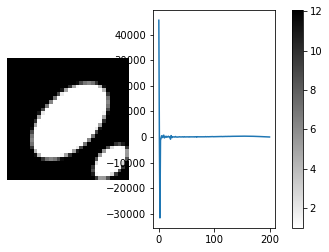

Elapsed: 247.8201024532318


In [3]:
fig, axs = plt.subplots(1,2)
    
im = axs[0].imshow(eps, cmap='binary')
fig.colorbar(im, ax=axs)
axs[0].set_axis_off()  # 
    

axs[1].plot(fields_cur[:, 0]*(2*np.pi)**2) #fields_cur是贝里曲率
np.savetxt('berry_cur.csv', fields_cur, delimiter=',', fmt='%f')
plt.show()

print('Elapsed:', time.time() - time_s)

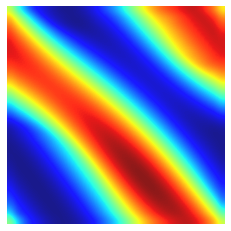

In [7]:
fig1, axs1 = plt.subplots()
    
im = axs1.imshow(np.real(f[0]), interpolation='spline36', alpha=0.9, origin='lower', cmap='jet')
fig.colorbar(im, ax=axs)
axs1.set_axis_off() 

In [4]:
# chen number
do_chern = True  # do Chern Number Calc
do_band = False  # do Band Structure Calc
Pxg = 1  # lattice constant along x
Pyg = 1  # lattice constant along y
N_sam = 10  # Brillouin sampling points ***
N_max = 2  # maximum band number ***
np.set_printoptions(precision=3, suppress=True)

Polarflag = 1  # 极化方式，0，TM极化；1，TE极化

shifted = 0.0
Nkxg = 200
Nkyg = 1
Pkxg = (4 * np.pi ) / Pxg / np.sqrt(3)
Pkyg = (4 * np.pi ) / Pyg / np.sqrt(3)
deltakxg = Pkxg / Nkxg
deltakyg = Pkyg / Nkyg
NK = Nkxg * Nkyg
kcx = np.zeros((NK, 4))
kcy = np.zeros((NK, 4))
# initialized
fieldTot = np.zeros(N_max)
ChernNumber = np.zeros(N_max)
fieldtemp = np.zeros(N_max, dtype=complex)
N_Lband = 1
N_Hband = 2
fieldTotComposite = 0
ChernNumberComposite = 0
fieldtempComposite = 0

if do_chern:
    time_s = time.time()
    fields = []
    fields_cur = np.zeros((Nkxg, N_max))
    for m in range(Nkxg+1):
        for n in range(Nkyg+1):
            print('Calculating', m * (Nkyg+1) + n + 1, 'of', (Nkxg+1) * (Nkyg+1), '...')
            omega, f, field_temp, eps_arr, eps = eigs_PCs(Pxg, Pyg,
                                                          # valley photonic crystal K Path
                                                  (m+0.5-Nkxg/2) * deltakxg * np.sqrt(3)/2, 
                                                  #(m  + 0.5) * deltakxg * np.sqrt(3) / 4, # 扫描平行四边形Kx
                                                  (n - Nkyg / 2 + 0.5) * deltakyg - (m + 0.5-Nkxg/2) * deltakxg /2, # 扫描Ky，要键入kx的1/2
                                                  #(n + 0.5) * deltakyg / 2 - (m - Nkxg / 2 + 0.5) * deltakxg / 2, 
                                                  N_max, 0, Polarflag)
            fields.append(field_temp)

    print(shape(f))

    for m in range(Nkxg):
        for n in range(Nkyg):
            field1 = fields[m*(Nkyg+1)+n] #提取平行四边形边界的场
            field4 = fields[m*(Nkyg+1)+n+1]
            field3 = fields[(m+1)*(Nkyg+1)+n+1]
            field2 = fields[(m+1)*(Nkyg+1)+n]

            for mm in range(N_max): #对每一个能带计算陈数
                temp = field1[:, mm].conj().T * eps_arr @ field2[:, mm] #一行乘以一列变成一个数
                fieldtemp[mm] = temp / np.abs(temp)
                temp = field2[:, mm].conj().T * eps_arr @ field3[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp) #这里是把前面的值再乘新值
                temp = field3[:, mm].conj().T * eps_arr @ field4[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp)
                temp = field4[:, mm].conj().T * eps_arr @ field1[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp)
                fields_cur[m, mm] = -np.imag(np.log(fieldtemp[mm]))/(deltakxg**2*np.sqrt(3))
                fieldTot[mm] = fieldTot[mm] + np.imag(np.log(fieldtemp[mm]))

            #print('total', fieldTot)


# 下面是计算简并点的陈数
            fieldt1 = (field1[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field2[:, N_Lband-1:N_Hband]) @ \
                      (field2[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field3[:, N_Lband-1:N_Hband]) @ \
                      (field3[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field4[:, N_Lband-1:N_Hband]) @ \
                      (field4[:, N_Lband-1:N_Hband].conj().T * np.tile(eps_arr, (N_Hband - N_Lband + 1, 1)) @ field1[:, N_Lband-1:N_Hband])
            fieldtempComposite = np.linalg.det(fieldt1)
            fieldtempComposite = fieldtempComposite / np.abs(fieldtempComposite)
            fieldTotComposite = fieldTotComposite + np.imag(np.log(fieldtempComposite))

 

    print('Elapsed:', time.time() - time_s)
    ChernNumber = fieldTot / 2 / np.pi
    ChernNumberComposite = fieldTotComposite / 2 / np.pi
    print('Chern Number', ChernNumber)

Calculating 1 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.49749999999999994, 0.0, 0.0>
elapsed time for initialization: 0.02967214584350586
solve_kpoint (-0.4975,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te 

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 4 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4925, 1.0, 0.0>
elapsed time for initialization: 0.017742395401000977


    iteration   14: trace = 0.1012262886192766 (2.51003e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, -0.4875, 1, 0, 1.51664, 0.190439, 0.254871
elapsed time for k point: 0.032861948013305664
Fixing h-field (band 1) phase by 0.988603 + -0.150546i; max ampl. = 1.44527
Fixing h-field (band 2) phase by 0.998154 + -0.0607279i; max ampl. = 1.86516
total elapsed time for run: 0.05137467384338379
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 7 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     

    iteration   11: trace = 0.1013215775509916 (0.000659402% change)
    iteration   12: trace = 0.101321348564695 (0.000226% change)
    iteration   13: trace = 0.1013213260453159 (2.22257e-05% change)
    iteration   14: trace = 0.1013213209596381 (5.01936e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, -0.4775, 2.77556e-17, 0, 0.55137, 0.189462, 0.255784
elapsed time for k point: 0.0345921516418457
Fixing h-field (band 1) phase by 0.993271 + -0.115813i; max ampl. = 1.42805
Fixing h-field (band 2) phase by 0.401098 + -0.916035i; max ampl. = 1.85548
total elapsed time for run: 0.05443692207336426
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 10 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Latt

    iteration    7: trace = 0.1014357985022568 (0.149923% change)
    iteration    8: trace = 0.1014035873464839 (0.0317603% change)
    iteration    9: trace = 0.101394581455673 (0.00888163% change)
    iteration   10: trace = 0.1013916836795982 (0.00285796% change)
    iteration   11: trace = 0.1013910889226835 (0.000586595% change)
    iteration   12: trace = 0.1013909351971135 (0.000151617% change)
    iteration   13: trace = 0.101390912181843 (2.26995e-05% change)
    iteration   14: trace = 0.101390908006386 (4.11818e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, -0.4725, 1, 0, 1.50366, 0.188778, 0.256425
elapsed time for k point: 0.025681018829345703
Fixing h-field (band 1) phase by 0.967295 + -0.253655i; max ampl. = 1.42627
Fixing h-field (band 2) phase by 0.986933 + -0.161131i; max ampl. = 1.8505
total elapsed time for run: 0.05018949508666992
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.8849351552544498 (196.602% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 0.2301399723296593 (117.444% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 0.1316745507857086 (54.4287% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 0.1088226828223576 (19.0039% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 0.1034326246521519 (5.07884% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 66.7005%)
    iteration    6: trace = 0.1020698571707211 (1.32628% change)
    iteration    7: trace = 0.1017049350806949 (0.358162% change)
    iteration    8: trace = 0.1016074569801079 (0.09589% change)
    iteration    9: trace = 0.101575

Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.45749999999999996, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.025760889053344727
solve_kpoint (-0.4575,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration  

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 21 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4475, 0.0, 0.0>
elapsed time for initialization: 0.018193960189819336

total elapsed time for run: 0.05991697311401367
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 24 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random 

    iteration   13: trace = 0.1022463595006544 (1.35463e-05% change)
    iteration   14: trace = 0.1022463572715705 (2.18011e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, -0.4375, 1, 0, 1.47373, 0.18109, 0.263539
elapsed time for k point: 0.024300336837768555
Fixing h-field (band 1) phase by 0.0840779 + -0.996459i; max ampl. = 1.35658
Fixing h-field (band 2) phase by 0.821012 + -0.570911i; max ampl. = 1.81166
total elapsed time for run: 0.04646611213684082
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 27 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.577

    iteration    3: trace = 0.1094492254403606 (20.0539% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 64.2384%)
    iteration    4: trace = 0.1042810706242575 (4.83615% change)
    switching back to exact line minimization
    iteration    5: trace = 0.1029335061836408 (1.30065% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 0.102721130500696 (0.206536% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.981%)
    iteration    7: trace = 0.1026268621583736 (0.0918133% change)
    iteration    8: trace = 0.1026154939717049 (0.0110778% change)
    iteration    9: trace = 0.1026100991829397 (0.00525742% change)
    iteration   10: trace = 0.1026077515571687 (0.00228794% change)
    iteration   11: trace = 0.1026072294960409 (0.000508794% change)
    iteration   12: trace = 0.102607095941443 (0.000130161% change)
    iteratio

     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.42249999999999993, 1.0000000000000004, 0.0>
elapsed time for initialization: 0.023497343063354492
solve_kpoint (-0.4225,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 6 iterations.
    iteration    1: trace = 0.4904780031977727 (198.309% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1272449884649894 (117.604% change)
    linmin: converged after 4 iterations.
    iteration    3: trace 

Calculating 35 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4124999999999999, 0.0, 0.0>
elapsed time for initialization: 0.018519878387451172
solve_kpoint (-0.4125,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te

Fixing h-field (band 2) phase by 0.813683 + 0.581308i; max ampl. = 1.66922
total elapsed time for run: 0.07325601577758789
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 38 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating 

    iteration   14: trace = 0.1037292469151306 (1.92948e-05% change)
    iteration   15: trace = 0.1037292358707 (1.06474e-05% change)
    iteration   16: trace = 0.1037292324123394 (3.33403e-06% change)
Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, -0.4025, 1, 0, 1.4443, 0.170035, 0.273528
elapsed time for k point: 0.029962539672851562
Fixing h-field (band 1) phase by -0.738778 + -0.673949i; max ampl. = 1.28771
Fixing h-field (band 2) phase by 0.405722 + -0.913997i; max ampl. = 1.79462
total elapsed time for run: 0.0631859302520752
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 41 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volum

    iteration    8: trace = 0.1042767698056036 (0.0301206% change)
    iteration    9: trace = 0.1042629962377429 (0.0132095% change)
    iteration   10: trace = 0.1042587420390474 (0.00408034% change)
    iteration   11: trace = 0.1042580955227445 (0.000620109% change)
    iteration   12: trace = 0.1042579040990198 (0.000183606% change)
    iteration   13: trace = 0.1042578761318484 (2.6825e-05% change)
    iteration   14: trace = 0.104257871249805 (4.68266e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, -0.3925, 2.77556e-17, 0, 0.45322, 0.166509, 0.276646
elapsed time for k point: 0.0391697883605957
Fixing h-field (band 1) phase by -0.538951 + -0.842337i; max ampl. = 1.26637
Fixing h-field (band 2) phase by 0.787763 + 0.615978i; max ampl. = 1.63082
total elapsed time for run: 0.07864880561828613
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 44 of 

    iteration    4: trace = 0.1060788796889171 (4.46795% change)
    switching back to exact line minimization
    iteration    5: trace = 0.1048355060168876 (1.17903% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 67.594%)
    iteration    6: trace = 0.1046340719040837 (0.192328% change)
    iteration    7: trace = 0.1045578925637237 (0.072832% change)
    iteration    8: trace = 0.1045486738773655 (0.00881721% change)
    iteration    9: trace = 0.1045438148397059 (0.00464774% change)
    iteration   10: trace = 0.1045417422071002 (0.00198257% change)
    iteration   11: trace = 0.1045412184436063 (0.00050101% change)
    iteration   12: trace = 0.1045410235615119 (0.000186417% change)
    iteration   13: trace = 0.1045409827850898 (3.90052e-05% change)
    iteration   14: trace = 0.1045409752530005 (7.20492e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, -0.3875, 1, 0, 1.43185, 0.164

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 52 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.3725, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.030

    iteration    9: trace = 0.1057735113419787 (0.00570531% change)
    iteration   10: trace = 0.1057710039893025 (0.00237052% change)
    iteration   11: trace = 0.1057702625191938 (0.000701017% change)
    iteration   12: trace = 0.1057700049334093 (0.000243534% change)
    iteration   13: trace = 0.1057699628905121 (3.97494e-05% change)
    iteration   14: trace = 0.1057699540045423 (8.40122e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, -0.3675, 1, 0, 1.41542, 0.157226, 0.284693
elapsed time for k point: 0.042218685150146484
Fixing h-field (band 1) phase by 0.828842 + -0.559483i; max ampl. = 1.23342
Fixing h-field (band 2) phase by 0.619184 + -0.785246i; max ampl. = 1.8263
total elapsed time for run: 0.06262707710266113
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 55 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolera

    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1090118048674689 (5.50172% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 68.401%)
    iteration    5: trace = 0.1069069784416931 (1.94965% change)
    iteration    6: trace = 0.1066162357173657 (0.272329% change)
    iteration    7: trace = 0.1064844522347176 (0.123682% change)
    iteration    8: trace = 0.1064578869177934 (0.0249507% change)
    iteration    9: trace = 0.1064461121266579 (0.0110611% change)
    iteration   10: trace = 0.1064409372531504 (0.00486161% change)
    iteration   11: trace = 0.1064397028781894 (0.00115969% change)
    iteration   12: trace = 0.1064393123723362 (0.000366881% change)
    iteration   13: trace = 0.1064392415475871 (6.65401e-05% change)
    iteration   14: trace = 0.1064392293464456 (1.1463e-05% change)
    iteration   15: trace = 0.1064392265887254 (2.59089e-06% change)
Finished solving for bands 1 to 2 a

Calculating 60 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.3525, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.022054433822631836
solve_kpoint (-0.3525,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi,

    iteration   16: trace = 0.1071453632270338 (9.64933e-06% change)
Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, -0.3475, 1, 0, 1.39917, 0.149448, 0.291223
elapsed time for k point: 0.05586981773376465
Fixing h-field (band 1) phase by -0.56534 + 0.824858i; max ampl. = 1.20863
Fixing h-field (band 2) phase by 0.0145913 + 0.999894i; max ampl. = 1.85592
total elapsed time for run: 0.07935214042663574
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 63 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cy

    iteration    7: trace = 0.1079484093470303 (0.172863% change)
    iteration    8: trace = 0.1079076744766844 (0.0377426% change)
    iteration    9: trace = 0.1078894805663488 (0.016862% change)
    iteration   10: trace = 0.1078806454034757 (0.00818942% change)
    iteration   11: trace = 0.1078783681025897 (0.00211097% change)
    iteration   12: trace = 0.107877564347086 (0.00074506% change)
    iteration   13: trace = 0.1078774257080718 (0.000128515% change)
    iteration   14: trace = 0.1078773982739712 (2.54308e-05% change)
    iteration   15: trace = 0.1078773919516205 (5.86068e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, -0.3375, 5.55112e-17, 0, 0.389711, 0.145471, 0.294475
elapsed time for k point: 0.043304443359375
Fixing h-field (band 1) phase by -0.797776 + 0.602954i; max ampl. = 1.19485
Fixing h-field (band 2) phase by -0.541137 + -0.840934i; max ampl. = 1.54183
total elapsed time for run: 0.06685423851013184
done
mu: 1-1, mean 1, ha

    iteration    2: trace = 0.2096571563763067 (85.1244% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1686559403275347 (21.6758% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 0.1330435778999531 (23.6078% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.11797027217073 (12.0099% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 73.7582%)
    iteration    6: trace = 0.1124159623719855 (4.82174% change)
    iteration    7: trace = 0.1102114992664811 (1.98041% change)
    iteration    8: trace = 0.1089685235069326 (1.13421% change)
    iteration    9: trace = 0.1084358449188767 (0.490035% change)
    iteration   10: trace = 0.1083180894078671 (0.108654% change)
    iteration   11: trace = 0.1082689440608987 (0.0453816% change)
    iteration   12: trace = 0.1082585700677171 (0.00958215% change)
    iteration   13: trace = 0.1082568

     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.32249999999999995, 0.0, 0.0>
elapsed time for initialization: 0.018152713775634766
solve_kpoint (-0.3225,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.5527473885305636 (198.097% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.1893928280530316 (97.9207% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 0.14323988208

    iteration    9: trace = 0.1098863922037528 (0.0958056% change)
    iteration   10: trace = 0.1098340557477551 (0.0476391% change)
    iteration   11: trace = 0.1098214717722193 (0.0114579% change)
    iteration   12: trace = 0.1098167989499538 (0.00425502% change)
    iteration   13: trace = 0.1098160295515394 (0.000700622% change)
    iteration   14: trace = 0.1098158663775245 (0.000148589% change)
    iteration   15: trace = 0.1098158233174799 (3.92111e-05% change)
    iteration   16: trace = 0.1098158148837547 (7.67988e-06% change)
Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, -0.3125, 1, 0, 1.37121, 0.135331, 0.302492
elapsed time for k point: 0.032943010330200195
Fixing h-field (band 1) phase by 0.951412 + -0.307919i; max ampl. = 1.17368
Fixing h-field (band 2) phase by 0.486762 + -0.873535i; max ampl. = 1.91923
total elapsed time for run: 0.07782769203186035
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. m

    linmin: converged after 6 iterations.
    iteration    3: trace = 0.1487253293972034 (26.7759% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 0.1241956371428223 (17.9757% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1155560763660903 (7.20709% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 0.1128306541488433 (2.38667% change)
    linmin: converged after 3 iterations.
    iteration    7: trace = 0.1114909811739203 (1.19442% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 60.9618%)
    iteration    8: trace = 0.1110624303245994 (0.385122% change)
    iteration    9: trace = 0.1107572933371662 (0.275122% change)
    iteration   10: trace = 0.1106658717478276 (0.0825764% change)
    iteration   11: trace = 0.1106279436838089 (0.0342785% change)
    iteration   12: trace = 0.1106190312647147 (0.00805653% change)
    iteration 

     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2975, 1.0000000000000004, 0.0>
elapsed time for initialization: 0.022646188735961914
solve_kpoint (-0.2975,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 0.7451904464011662 (197.472% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1872878032460122 (119.66% change)
    linmin: converged after 5 iterations.
    iteration    3

    iteration   16: trace = 0.1114302248428474 (0.000184345% change)
    iteration   17: trace = 0.1114301304111909 (8.47451e-05% change)
    iteration   18: trace = 0.1114300999142055 (2.73687e-05% change)
    iteration   19: trace = 0.1114300885596491 (1.01898e-05% change)
    iteration   20: trace = 0.1114300861786535 (2.13676e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, -0.2925, 1, 0, 1.35551, 0.127059, 0.308685
elapsed time for k point: 0.029551267623901367
Fixing h-field (band 1) phase by 0.774797 + 0.63221i; max ampl. = 1.15754
Fixing h-field (band 2) phase by -0.422577 + -0.906327i; max ampl. = 1.97918
total elapsed time for run: 0.08670663833618164
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 85 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 

     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2825, 0.0, 0.0>
elapsed time for initialization: 0.0198056697845459
solve_kpoint (-0.2825,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.5983891087316462 (197.939% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1737752234151043 (109.98% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.13795

    iteration   14: trace = 0.112649211091285 (0.000373154% change)
    iteration   15: trace = 0.112649134743583 (6.77748e-05% change)
    iteration   16: trace = 0.1126491217232789 (1.15583e-05% change)
    iteration   17: trace = 0.1126491168358559 (4.33863e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, -0.2775, 0, 0, 0.320429, 0.120782, 0.313147
elapsed time for k point: 0.04329323768615723
Fixing h-field (band 1) phase by 0.724407 + -0.689372i; max ampl. = 1.14537
Fixing h-field (band 2) phase by 0.999882 + -0.0153349i; max ampl. = 1.97391
total elapsed time for run: 0.10021805763244629
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 90 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice v

Initializing fields to random numbers...
1 k-points
  Vector3<-0.27249999999999996, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.022131681442260742
solve_kpoint (-0.2725,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 0.7176005988523833 (197.542% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 0.2097003457711004 (109.544% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1642956155732051 (24.2809% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1428959930825691 (13.9324% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1299337464673191 (9.50208% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 0.1225502562561634 (5.84868% change)
    linmin: converged after 5 iterations.
    switc

tefreqs:, 1, -0.2675, 1, 0, 1.33619, 0.116568, 0.316027
elapsed time for k point: 0.03461599349975586
Fixing h-field (band 1) phase by 0.35039 + -0.936604i; max ampl. = 1.14054
Fixing h-field (band 2) phase by 0.533116 + 0.846042i; max ampl. = 2.05531
total elapsed time for run: 0.08284449577331543
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 95 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)

    switching to approximate line minimization (decrease time by 50.4729%)
    iteration    5: trace = 0.1165792219809124 (4.7998% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1149885451366184 (1.37383% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.8148%)
    iteration    7: trace = 0.1144095926251445 (0.504758% change)
    iteration    8: trace = 0.1142855629538088 (0.108467% change)
    iteration    9: trace = 0.1142659592202399 (0.0171548% change)
    iteration   10: trace = 0.1142600076838138 (0.00520863% change)
    iteration   11: trace = 0.1142593559285478 (0.000570416% change)
    iteration   12: trace = 0.1142590119231274 (0.000301075% change)
    iteration   13: trace = 0.1142588720809635 (0.000122391% change)
    iteration   14: trace = 0.1142587762531245 (8.38691e-05% change)
    iteration   15: trace = 0.1142587355329289 (3.56386e-05% change)
    iteration   16: t

     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2525, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.03572583198547363
solve_kpoint (-0.2525,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.3818531055656361 (198.639% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1728654065226087 (75.3491% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1482717275168411 (15.3166% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1271214579944462 (15.3601% change)
    linmin: 

    iteration    9: trace = 0.1152577637815644 (0.382624% change)
    iteration   10: trace = 0.115112686413377 (0.125951% change)
    iteration   11: trace = 0.1150622130003041 (0.0438566% change)
    iteration   12: trace = 0.1150514331705747 (0.00936914% change)
    iteration   13: trace = 0.1150488022335827 (0.00228677% change)
    iteration   14: trace = 0.115047950797909 (0.000740068% change)
    iteration   15: trace = 0.1150477776508215 (0.0001505% change)
    iteration   16: trace = 0.1150477241518042 (4.65016e-05% change)
    iteration   17: trace = 0.1150477014825721 (1.97042e-05% change)
    iteration   18: trace = 0.1150476911325037 (8.99633e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.2475, 1, 0, 1.32099, 0.108081, 0.321506
elapsed time for k point: 0.03582954406738281
Fixing h-field (band 1) phase by 0.356281 + -0.934379i; max ampl. = 1.12896
Fixing h-field (band 2) phase by 0.464208 + 0.885726i; max ampl. = 2.11376
total elapsed ti

Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.23749999999999996, 1.3877787807814457e-17, 0.0>
elapsed time for initialization: 0.028171777725219727
solve_kpoint (-0.2375,1.38778e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.3827606152661546 (198.647% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1667019475865818 (78.6436% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1382062774685908 (18.6913% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1227412419382037 (11.853% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 56.6452%)
    iteration    5: trace = 0.118362440535982

    iteration   12: trace = 0.1161934701035812 (0.0116225% change)
    iteration   13: trace = 0.1161913468739568 (0.00182734% change)
    iteration   14: trace = 0.1161905595651012 (0.000677599% change)
    iteration   15: trace = 0.1161904168492972 (0.000122829% change)
    iteration   16: trace = 0.1161903831261035 (2.90241e-05% change)
    iteration   17: trace = 0.1161903651430484 (1.54772e-05% change)
    iteration   18: trace = 0.1161903582618752 (5.92233e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.2325, 1.38778e-17, 0, 0.268468, 0.101672, 0.325351
elapsed time for k point: 0.06508302688598633
Fixing h-field (band 1) phase by 0.987017 + -0.160617i; max ampl. = 1.12054
Fixing h-field (band 2) phase by 0.999162 + 0.0409216i; max ampl. = 2.15918
total elapsed time for run: 0.1229393482208252
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 1

     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.22749999999999998, 1.0000000000000004, 0.0>
elapsed time for initialization: 0.028132915496826172
solve_kpoint (-0.2275,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 0.4415990334947725 (198.449% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1855222162718405 (81.6674% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1534125847357161 (18.9474% change)
    linmin: conve

    iteration   11: trace = 0.1169524778171833 (0.0584041% change)
    iteration   12: trace = 0.116937316113133 (0.0129648% change)
    iteration   13: trace = 0.1169327516365869 (0.00390343% change)
    iteration   14: trace = 0.1169310457609693 (0.00145886% change)
    iteration   15: trace = 0.1169308030668991 (0.000207553% change)
    iteration   16: trace = 0.1169307394042361 (5.44447e-05% change)
    iteration   17: trace = 0.1169307229983044 (1.40305e-05% change)
    iteration   18: trace = 0.1169307204640162 (2.16734e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.2225, 1, 0, 1.30231, 0.0973801, 0.327792
elapsed time for k point: 0.06291484832763672
Fixing h-field (band 1) phase by 0.146279 + -0.989243i; max ampl. = 1.11645
Fixing h-field (band 2) phase by 0.949712 + -0.313125i; max ampl. = 2.1797
total elapsed time for run: 0.10225105285644531
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. me

     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2125, 0.0, 0.0>
elapsed time for initialization: 0.045250654220581055
solve_kpoint (-0.2125,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.460509516407195 (198.292% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.2121531477053257 (73.8428% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1746505073650458 (19.391% change)
    linmin: 

    iteration   15: trace = 0.117991427716669 (0.00104791% change)
    iteration   16: trace = 0.1179910530994944 (0.000317496% change)
    iteration   17: trace = 0.117990976614834 (6.48224e-05% change)
    iteration   18: trace = 0.1179909558369693 (1.76097e-05% change)
    iteration   19: trace = 0.1179909519405713 (3.30229e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.2075, 0, 0, 0.2396, 0.090919, 0.331247
elapsed time for k point: 0.03613567352294922
Fixing h-field (band 1) phase by -0.515794 + 0.856713i; max ampl. = 1.10994
Fixing h-field (band 2) phase by 0.335129 + 0.942172i; max ampl. = 2.25506
total elapsed time for run: 0.06096339225769043
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 118 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 ba

Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.20249999999999999, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.032827138900756836
solve_kpoint (-0.2025,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4798367107453704 (198.228% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1866136769080278 (87.9955% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1537425598182315 (19.3157% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1364037384569312 (11.9518% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1271887876586628 (6.99181% change)
    linmin: converged after 4 iterations.
    switching to approximat

Fixing h-field (band 2) phase by 0.385047 + 0.922897i; max ampl. = 2.23742
total elapsed time for run: 0.08843040466308594
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 123 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating

    iteration    6: trace = 0.120583846325393 (1.86406% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1197142923175206 (0.723729% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 71.3043%)
    iteration    8: trace = 0.1195342225629579 (0.150529% change)
    iteration    9: trace = 0.119419138933667 (0.0963231% change)
    iteration   10: trace = 0.1193817048805715 (0.0313517% change)
    iteration   11: trace = 0.1193459734078911 (0.0299349% change)
    iteration   12: trace = 0.1193346372273998 (0.00949904% change)
    iteration   13: trace = 0.1193306307534531 (0.0033574% change)
    iteration   14: trace = 0.1193290005680809 (0.00136612% change)
    iteration   15: trace = 0.1193287176857404 (0.000237061% change)
    iteration   16: trace = 0.1193286120226017 (8.8548e-05% change)
    iteration   17: trace = 0.1193285828766351 (2.4425e-05% change)
    iteration   18: trace = 0.119

     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.1825, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.023546695709228516
solve_kpoint (-0.1825,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 0.4963438523351222 (198.282% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 0.1469037313645997 (108.649% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1266499781652621 (14.8079% chan

    iteration   16: trace = 0.1199682304833749 (1.15138e-05% change)
    iteration   17: trace = 0.1199682254823303 (4.16864e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, -0.1775, 1, 0, 1.26965, 0.077924, 0.337485
elapsed time for k point: 0.04368400573730469
Fixing h-field (band 1) phase by -0.795837 + -0.60551i; max ampl. = 1.0983
Fixing h-field (band 2) phase by -0.405182 + -0.914236i; max ampl. = 2.27902
total elapsed time for run: 0.07865166664123535
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 131 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.577

    iteration    4: trace = 0.1466330703229036 (12.7202% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1334494286566655 (9.41411% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1256135165219161 (6.04943% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 77.7233%)
    iteration    7: trace = 0.1229644297732683 (2.13139% change)
    iteration    8: trace = 0.1220668957780793 (0.732587% change)
    iteration    9: trace = 0.1212524011069425 (0.669486% change)
    iteration   10: trace = 0.1208432544505067 (0.338004% change)
    iteration   11: trace = 0.1206564692276136 (0.154688% change)
    iteration   12: trace = 0.1205986081798086 (0.0479667% change)
    iteration   13: trace = 0.1205880458388105 (0.00875864% change)
    iteration   14: trace = 0.1205833391481067 (0.00390319% change)
    iteration   15: trace = 0.1205823528904229 (0.000817909% change)
   

total elapsed time for run: 0.07933616638183594
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 136 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random

    iteration    2: trace = 0.1828142924631832 (83.8566% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.155108848234107 (16.3975% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1347300723974395 (14.0621% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1271371412869516 (5.79907% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 70.2617%)
    iteration    6: trace = 0.1227384423211141 (3.52071% change)
    iteration    7: trace = 0.1217874367626612 (0.777836% change)
    iteration    8: trace = 0.1215113371707095 (0.226963% change)
    iteration    9: trace = 0.1213497093405181 (0.133103% change)
    iteration   10: trace = 0.1212814471458942 (0.0562683% change)
    iteration   11: trace = 0.1212323497082921 (0.0404904% change)
    iteration   12: trace = 0.12120060627098 (0.0261874% change)
    iteration   13: trace = 0.121191

    iteration   20: trace = 0.1214758328812143 (3.08963e-05% change)
    iteration   21: trace = 0.121475798771523 (2.80794e-05% change)
    iteration   22: trace = 0.1214757794478216 (1.59075e-05% change)
    iteration   23: trace = 0.121475769945805 (7.82215e-06% change)
Finished solving for bands 1 to 2 after 23 iterations.
tefreqs:, 1, -0.1525, 1, 0, 1.25207, 0.0670353, 0.342026
elapsed time for k point: 0.04005622863769531
Fixing h-field (band 1) phase by 0.845487 + 0.533997i; max ampl. = 1.09019
Fixing h-field (band 2) phase by 0.967416 + -0.25319i; max ampl. = 2.33104
total elapsed time for run: 0.06644201278686523
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 141 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vec

    iteration   11: trace = 0.1223458244045646 (0.0219788% change)
    iteration   12: trace = 0.1223324742748877 (0.0109124% change)
    iteration   13: trace = 0.122327527339304 (0.00404393% change)
    iteration   14: trace = 0.1223258546619226 (0.00136739% change)
    iteration   15: trace = 0.1223253474103754 (0.000414673% change)
    iteration   16: trace = 0.1223252122168138 (0.00011052% change)
    iteration   17: trace = 0.1223251683100727 (3.58935e-05% change)
    iteration   18: trace = 0.1223251508155331 (1.43017e-05% change)
    iteration   19: trace = 0.122325141909561 (7.28057e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.1375, 0, 0, 0.158771, 0.0604811, 0.344481
elapsed time for k point: 0.06878995895385742
Fixing h-field (band 1) phase by 0.814031 + -0.580821i; max ampl. = 1.08904
Fixing h-field (band 2) phase by 0.952337 + -0.305048i; max ampl. = 2.44223
total elapsed time for run: 0.09503316879272461
done
mu: 1-1, mean 1, harm. m

     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.1325, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.023423433303833008
solve_kpoint (-0.1325,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.3728971254014002 (198.716% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1817295824948164 (68.9356% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1583610234907888 (13.7425% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1433391054337572 (9.95818% change)
    linmin

    iteration   10: trace = 0.1230571653394888 (0.264441% change)
    iteration   11: trace = 0.1229265922688737 (0.106164% change)
    iteration   12: trace = 0.1228852795727024 (0.0336133% change)
    iteration   13: trace = 0.1228789181097388 (0.00517688% change)
    iteration   14: trace = 0.1228764294899622 (0.00202528% change)
    iteration   15: trace = 0.1228757699909186 (0.000536719% change)
    iteration   16: trace = 0.1228754830940118 (0.000233486% change)
    iteration   17: trace = 0.1228753694562971 (9.24821e-05% change)
    iteration   18: trace = 0.1228753442821778 (2.04875e-05% change)
    iteration   19: trace = 0.1228753315923315 (1.03274e-05% change)
    iteration   20: trace = 0.1228753264986349 (4.14542e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, -0.1275, 1, 0, 1.23491, 0.0561045, 0.346017
elapsed time for k point: 0.041155338287353516
Fixing h-field (band 1) phase by -0.0069997 + -0.999976i; max ampl. = 1.08324
Fixing h-field

Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.1175, 6.938893903907228e-18, 0.0>
elapsed time for initialization: 0.023812294006347656
solve_kpoint (-0.1175,6.93889e-18,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.4338973582857889 (198.444% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1872115071360465 (79.434% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1605417009738725 (15.3384% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1416306575127954 (12.5167% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1318131918041299 (7.18061% c

    iteration   12: trace = 0.1236691492702998 (0.0200449% change)
    iteration   13: trace = 0.1236628570627476 (0.00508807% change)
    iteration   14: trace = 0.1236604754037887 (0.00192595% change)
    iteration   15: trace = 0.12365984011975 (0.000513734% change)
    iteration   16: trace = 0.1236594987946856 (0.00027602% change)
    iteration   17: trace = 0.1236594036199722 (7.69652e-05% change)
    iteration   18: trace = 0.123659375628774 (2.26357e-05% change)
    iteration   19: trace = 0.1236593661443766 (7.66978e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.1125, 0, 0, 0.129904, 0.0495297, 0.348147
elapsed time for k point: 0.05661940574645996
Fixing h-field (band 1) phase by 0.00236064 + -0.999997i; max ampl. = 1.0841
Fixing h-field (band 2) phase by -0.402678 + 0.915342i; max ampl. = 2.48681
total elapsed time for run: 0.08515548706054688
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. 

1 k-points
  Vector3<-0.1075, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.02185845375061035
solve_kpoint (-0.1075,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.5539984570134159 (198.033% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1712220344453556 (105.561% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1450352573801567 (16.5604% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1332976770639373 (8.4342% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 0.1298073717485604 (2.65316% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 58.3002%)
    iteration    6: trace = 0.1260023311444501 (2.9749% change)
    iteration    7: trace = 0.12

    iteration   16: trace = 0.1241613753875703 (0.000103299% change)
    iteration   17: trace = 0.1241613467635122 (2.30539e-05% change)
    iteration   18: trace = 0.1241613363223675 (8.40934e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.1025, 1, 0, 1.2182, 0.0451409, 0.349462
elapsed time for k point: 0.03655743598937988
Fixing h-field (band 1) phase by -0.765977 + -0.642868i; max ampl. = 1.07938
Fixing h-field (band 2) phase by -0.924183 + -0.38195i; max ampl. = 2.42821
total elapsed time for run: 0.0654451847076416
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 161 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell v

    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1807427914942801 (77.6158% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1549170500809041 (15.388% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1383341644959603 (11.3097% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1305221756621744 (5.81127% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 64.7848%)
    iteration    6: trace = 0.1262091659224145 (3.35994% change)
    iteration    7: trace = 0.125178559882933 (0.819933% change)
    iteration    8: trace = 0.1249324005666864 (0.19684% change)
    iteration    9: trace = 0.1247759657392155 (0.125294% change)
    iteration   10: trace = 0.1247164023740412 (0.0477476% change)
    iteration   11: trace = 0.1246783646612623 (0.030504% change)
    iteration   12: trace = 0.1246502755366373 (0.0225318% cha

    iteration   22: trace = 0.1248618710445701 (8.07707e-06% change)
Finished solving for bands 1 to 2 after 22 iterations.
tefreqs:, 1, -0.0875, 6.93889e-18, 0, 0.101036, 0.0385502, 0.351249
elapsed time for k point: 0.04863619804382324
Fixing h-field (band 1) phase by -0.500263 + -0.865873i; max ampl. = 1.08029
Fixing h-field (band 2) phase by 0.0098797 + 0.999951i; max ampl. = 2.52547
total elapsed time for run: 0.0956716537475586
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 166 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric ob

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.4591481177324505 (198.35% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1769731477352355 (88.7174% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.151752807614131 (15.3443% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1409820896826177 (7.35868% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.1784%)
    iteration    5: trace = 0.1366907404077586 (3.09094% change)
    iteration    6: trace = 0.131172325933154 (4.12033% change)
    iteration    7: trace = 0.1278647965629728 (2.55371% change)
    iteration    8: trace = 0.1260030229412017 (1.46673% change)
    iteration    9: trace = 0.1254634910649249 (0.429108% change)
    iteration  

    iteration   12: trace = 0.1253090713875788 (0.0179492% change)
    iteration   13: trace = 0.1252996723751946 (0.00750095% change)
    iteration   14: trace = 0.1252975507382454 (0.00169326% change)
    iteration   15: trace = 0.1252972290024392 (0.000256778% change)
    iteration   16: trace = 0.1252970458616313 (0.000146165% change)
    iteration   17: trace = 0.1252969501115159 (7.64185e-05% change)
    iteration   18: trace = 0.1252969000368663 (3.99648e-05% change)
    iteration   19: trace = 0.1252968839304397 (1.28546e-05% change)
    iteration   20: trace = 0.1252968808319061 (2.47295e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, -0.0775, 1, 0, 1.20195, 0.0341523, 0.352322
elapsed time for k point: 0.047971248626708984
Fixing h-field (band 1) phase by 0.982481 + -0.186364i; max ampl. = 1.07719
Fixing h-field (band 2) phase by 0.986629 + -0.162984i; max ampl. = 2.47501
total elapsed time for run: 0.07311391830444336
done
mu: 1-1, mean 1, ha

    iteration    5: trace = 0.130225466757061 (4.24902% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1275163988622589 (2.10216% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.5885%)
    iteration    7: trace = 0.1264376867143316 (0.849533% change)
    iteration    8: trace = 0.1260662304782751 (0.294218% change)
    iteration    9: trace = 0.1259617600284595 (0.0829038% change)
    iteration   10: trace = 0.125915136668788 (0.0370208% change)
    iteration   11: trace = 0.1258970057163999 (0.0144004% change)
    iteration   12: trace = 0.1258832109272266 (0.0109578% change)
    iteration   13: trace = 0.1258789994432183 (0.0033456% change)
    iteration   14: trace = 0.1258774161579258 (0.00125779% change)
    iteration   15: trace = 0.1258769187547614 (0.00039515% change)
    iteration   16: trace = 0.1258768071686308 (8.86471e-05% change)
    iteration   17: trace = 0.1258767

Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.0575, -3.46945e-18, 0, 0.0663953, 0.0253481, 0.35413
elapsed time for k point: 0.0706779956817627
Fixing h-field (band 1) phase by 0.576807 + -0.816881i; max ampl. = 1.07704
Fixing h-field (band 2) phase by -0.391566 + -0.92015i; max ampl. = 2.56447
total elapsed time for run: 0.10010647773742676
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 178 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, heig

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 16 iterations.
    iteration    1: trace = 0.618194286172689 (197.804% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.2195554564700307 (95.169% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1832574444869499 (18.0223% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1740635640838277 (5.14601% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.94%)
    iteration    5: trace = 0.1700892768485006 (2.30961% change)
    iteration    6: trace = 0.1578534932207051 (7.46215% change)
    iteration    7: trace = 0.1488065920062861 (5.90028% change)
    iteration    8: trace = 0.1436720453121305 (3.51106% change)
    iteration    9: trace = 0.1390125236304854 (3.29662% change)
    iteration   1

    iteration   12: trace = 0.1266218672761517 (0.520168% change)
    iteration   13: trace = 0.1264724727013188 (0.118054% change)
    iteration   14: trace = 0.126391514784757 (0.0640328% change)
    iteration   15: trace = 0.1263766538260145 (0.0117586% change)
    iteration   16: trace = 0.1263697881791435 (0.00543283% change)
    iteration   17: trace = 0.1263672577799884 (0.0020024% change)
    iteration   18: trace = 0.1263660495592197 (0.000956123% change)
    iteration   19: trace = 0.1263655866942062 (0.00036629% change)
    iteration   20: trace = 0.1263653371529798 (0.000197476% change)
    iteration   21: trace = 0.1263652933458463 (3.46671e-05% change)
    iteration   22: trace = 0.1263652841942584 (7.24217e-06% change)
Finished solving for bands 1 to 2 after 22 iterations.
tefreqs:, 1, -0.0475, 1, 0, 1.18308, 0.0209428, 0.354861
elapsed time for k point: 0.07461333274841309
Fixing h-field (band 1) phase by 0.860581 + 0.509314i; max ampl. = 1.07544
Fixing h-field (band 2)

Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.0375, -3.469446951953614e-18, 0.0>
elapsed time for initialization: 0.022184371948242188
solve_kpoint (-0.0375,-3.46945e-18,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 16 iterations.
    iteration    1: trace = 0.356849234874727 (198.73% change)
    l

    iteration    7: trace = 0.1282097225883073 (1.22677% change)
    iteration    8: trace = 0.1274563898184616 (0.58931% change)
    iteration    9: trace = 0.1270940594564336 (0.284683% change)
    iteration   10: trace = 0.1268682193620369 (0.177853% change)
    iteration   11: trace = 0.1267725785972892 (0.0754143% change)
    iteration   12: trace = 0.1267426866207992 (0.023582% change)
    iteration   13: trace = 0.1267373657246194 (0.00419828% change)
    iteration   14: trace = 0.1267358654601137 (0.00118377% change)
    iteration   15: trace = 0.1267353517160072 (0.000405367% change)
    iteration   16: trace = 0.1267351031775207 (0.000196108% change)
    iteration   17: trace = 0.1267349684039441 (0.000106343% change)
    iteration   18: trace = 0.1267349301113651 (3.02147e-05% change)
    iteration   19: trace = 0.1267349167058781 (1.05776e-05% change)
    iteration   20: trace = 0.1267349137304563 (2.34775e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.


Calculating 190 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.0275, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.024898290634155273
solve_kpoint (-0.0275,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi

    iteration    5: trace = 0.148941128909543 (8.84438% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1318866778390985 (12.1458% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 64.4295%)
    iteration    7: trace = 0.1287196320794898 (2.43052% change)
    iteration    8: trace = 0.1274053435385082 (1.02629% change)
    iteration    9: trace = 0.12705951199012 (0.271811% change)
    iteration   10: trace = 0.1269383490843622 (0.0954047% change)
    iteration   11: trace = 0.1269245457977247 (0.0108746% change)
    iteration   12: trace = 0.1269191650876451 (0.00423939% change)
    iteration   13: trace = 0.1269163699567804 (0.00220232% change)
    iteration   14: trace = 0.1269150768303413 (0.00101889% change)
    iteration   15: trace = 0.1269137824230769 (0.00101991% change)
    iteration   16: trace = 0.1269133889268821 (0.00031005% change)
    iteration   17: trace = 0.12691329083813

    iteration   28: trace = 0.1269786464791112 (0.000111546% change)
    iteration   29: trace = 0.1269785228582036 (9.73557e-05% change)
    iteration   30: trace = 0.1269784399608018 (6.52846e-05% change)
    iteration   31: trace = 0.126978372767475 (5.29171e-05% change)
    iteration   32: trace = 0.126978321132668 (4.06643e-05% change)
    iteration   33: trace = 0.1269782997402134 (1.68473e-05% change)
    iteration   34: trace = 0.1269782891717591 (8.32304e-06% change)
Finished solving for bands 1 to 2 after 34 iterations.
tefreqs:, 1, -0.0175, 1, 0, 1.16494, 0.00771779, 0.356257
elapsed time for k point: 0.08726930618286133
Fixing h-field (band 1) phase by -0.892776 + -0.450502i; max ampl. = 1.07413
Fixing h-field (band 2) phase by 0.422725 + 0.906258i; max ampl. = 2.54575
total elapsed time for run: 0.11460399627685547
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 195 of 4

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.0075, 0.0, 0.0>
elapsed time for initialization: 0.028927087783813477
solve_kpoint (-0.0075,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 21 iterations.
    iteration   

Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.0024999999999999996, 2.168404344971009e-19, 0.0>
elapsed time for initialization: 0.04143404960632324
solve_kpoint (-0.0025,2.1684e-19,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 31.31906236971188 (111.732% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 28.90064700156519 (8.03197% change)
    linmin: converged after 16 iterations.
    iteration    3: trace = 0.4530351671513795 (193.827% change)
    linmin: converged after 13 iterations.
    iteration    4: trace = 0.2789362550879834 (47.5699% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.2632914021070596 (5.77058% change)
    linmin: converged after 7 iterations.
    iteration    6: trace = 0.2405089662399887 (9.04423% change)
  

Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0024999999999999996, -2.168404344971009e-19, 0.0>
elapsed time for initialization: 0.02240729331970215
solve_kpoint (0.0025,-2.1684e-19,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 31.32421406242624 (111.722% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 28.90117219544268 (8.04658% change)
    linmin: converged after 21 iterations.
    iteration    3: trace = 0.4534332235981985 (193.821% change)
    linmin: converged after 13 iterations.
    iteration    4: trace = 0.2796587770538541 (47.4086% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.26384377449138

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0075, 0.0, 0.0>
elapsed time for initialization: 0.03562307357788086
solve_kpoint (0.0075,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 23 iterations.
    iteration    1:

    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1365467912235199 (8.81448% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 72.4065%)
    iteration    5: trace = 0.1322338454902821 (3.20927% change)
    iteration    6: trace = 0.1290825061670177 (2.4119% change)
    iteration    7: trace = 0.1278957927776727 (0.92359% change)
    iteration    8: trace = 0.1273592617703133 (0.420388% change)
    iteration    9: trace = 0.1271538125432176 (0.161445% change)
    iteration   10: trace = 0.1270885693713745 (0.0513236% change)
    iteration   11: trace = 0.1270466012559975 (0.0330282% change)
    iteration   12: trace = 0.1270346085674456 (0.00944004% change)
    iteration   13: trace = 0.1270284480958727 (0.00484956% change)
    iteration   14: trace = 0.1270265619631279 (0.00148482% change)
    iteration   15: trace = 0.1270260586430786 (0.000396233% change)
    iteration   16: trace = 0.1270258484142

    iteration   19: trace = 0.1269768818846032 (4.04744e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.0175, 0, 0, 0.0202073, 0.00771777, 0.356255
elapsed time for k point: 0.04368019104003906
Fixing h-field (band 1) phase by -0.112782 + 0.99362i; max ampl. = 1.07482
Fixing h-field (band 2) phase by -0.662444 + -0.749111i; max ampl. = 2.59684
total elapsed time for run: 0.07418608665466309
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 208 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
  

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 15 iterations.
    iteration    1: trace = 0.5971738224056039 (197.842% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.2018357551291988 (98.957% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1734028172841668 (15.1546% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1637133107431788 (5.74847% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 78.1185%)
    iteration    5: trace = 0.1576584068216881 (3.76816% change)
    iteration    6: trace = 0.1413583037920955 (10.9025% change)
    iteration    7: trace = 0.1402888814156933 (0.759406% change)
    iteration    8: trace = 0.1350879976068215 (3.77728% change)
    iteration    9: trace = 0.1324640143027571 (1.96148% change)
    iteration

    iteration   15: trace = 0.1268345282423396 (0.000226468% change)
    iteration   16: trace = 0.1268344725055012 (4.39445e-05% change)
    iteration   17: trace = 0.1268344525941399 (1.56987e-05% change)
    iteration   18: trace = 0.1268344453134087 (5.74034e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.0275, 1, 0, 1.13916, 0.0121272, 0.355932
elapsed time for k point: 0.07706427574157715
Fixing h-field (band 1) phase by -0.873434 + -0.486943i; max ampl. = 1.07473
Fixing h-field (band 2) phase by 0.154415 + 0.988006i; max ampl. = 2.5392
total elapsed time for run: 0.10115528106689453
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 213 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice v

Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0375, 3.469446951953614e-18, 0.0>
elapsed time for initialization: 0.02197861671447754
solve_kpoint (0.0375,3.46945e-18,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 16 iterations.
    iteration    1: trace = 0.558670857183141 (198.081% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.211701348081229 (90.0784% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1778437559610745 (17.3831% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1655053182308623 (7.18711% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1573905629593298 (5.02624% change)
    linmin: converged after 7 iterations.
    iteration    6: trace = 0.1382821148700084 (12.9254% change)

    iteration    9: trace = 0.1277298713998148 (1.06892% change)
    iteration   10: trace = 0.1272116486962706 (0.406542% change)
    iteration   11: trace = 0.126847195887256 (0.286904% change)
    iteration   12: trace = 0.1265924205412892 (0.201054% change)
    iteration   13: trace = 0.1265300606342884 (0.0492725% change)
    iteration   14: trace = 0.1265081006236606 (0.0173571% change)
    iteration   15: trace = 0.1265048138764752 (0.00259809% change)
    iteration   16: trace = 0.1265037301903945 (0.00085664% change)
    iteration   17: trace = 0.1265031935210963 (0.000424233% change)
    iteration   18: trace = 0.1265028872877223 (0.000242076% change)
    iteration   19: trace = 0.1265026485368389 (0.000188732% change)
    iteration   20: trace = 0.1265025950786626 (4.22586e-05% change)
    iteration   21: trace = 0.1265025713853078 (1.87295e-05% change)
    iteration   22: trace = 0.1265025609207208 (8.27223e-06% change)
Finished solving for bands 1 to 2 after 22 iterations.

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.047499999999999994, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.02355194091796875
solve_kpoint (0.0475,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 14 it

    iteration    4: trace = 0.1695973312701042 (8.21878% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1594215960223347 (6.1855% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1445735576836528 (9.7686% change)
    linmin: converged after 6 iterations.
    iteration    7: trace = 0.1335659266947209 (7.91519% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 73.719%)
    iteration    8: trace = 0.1298832065571459 (2.79577% change)
    iteration    9: trace = 0.1280278554709467 (1.43875% change)
    iteration   10: trace = 0.1272777843972812 (0.587587% change)
    iteration   11: trace = 0.1267554096553599 (0.411265% change)
    iteration   12: trace = 0.1265579110695602 (0.155932% change)
    iteration   13: trace = 0.1263786905147264 (0.141712% change)
    iteration   14: trace = 0.1262593333207505 (0.0944887% change)
    iteration   15: trace = 0.126231997

    iteration   20: trace = 0.1260564703963671 (0.000461947% change)
    iteration   21: trace = 0.1260562183574485 (0.000199941% change)
    iteration   22: trace = 0.1260561267939241 (7.26371e-05% change)
    iteration   23: trace = 0.1260560725580316 (4.30252e-05% change)
    iteration   24: trace = 0.1260560291411777 (3.44425e-05% change)
    iteration   25: trace = 0.1260560078797434 (1.68667e-05% change)
    iteration   26: trace = 0.1260559993277717 (6.78426e-06% change)
Finished solving for bands 1 to 2 after 26 iterations.
tefreqs:, 1, 0.0575, 1, 0, 1.12298, 0.0253483, 0.354138
elapsed time for k point: 0.06989073753356934
Fixing h-field (band 1) phase by -0.647047 + -0.76245i; max ampl. = 1.07677
Fixing h-field (band 2) phase by 0.128167 + 0.991753i; max ampl. = 2.50427
total elapsed time for run: 0.10624146461486816
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 225 of 40

          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0675, 0.0, 0.0>
elapsed time for initialization: 0.03271889686584473
solve_kpoint (0.0675,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 15 iterations.
    iteration    1: trace = 0.5271602857924088 (198.187% change)
    linmin: converged after 9 iterations.
    iteration    2: trace = 0.174317467126833 (100.6% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1486543659436805 (15.8919% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.13739554436

    iteration   14: trace = 0.1255015976931711 (0.000971747% change)
    iteration   15: trace = 0.1255013505953376 (0.000196888% change)
    iteration   16: trace = 0.1255012268801399 (9.85768e-05% change)
    iteration   17: trace = 0.1255011631919817 (5.07471e-05% change)
    iteration   18: trace = 0.1255011366270828 (2.11671e-05% change)
    iteration   19: trace = 0.1255011260186067 (8.45289e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.0725, 0, 0, 0.0837158, 0.0319523, 0.352817
elapsed time for k point: 0.049643754959106445
Fixing h-field (band 1) phase by 0.569928 + -0.821695i; max ampl. = 1.07845
Fixing h-field (band 2) phase by 0.483971 + 0.875084i; max ampl. = 2.54622
total elapsed time for run: 0.08718252182006836
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 230 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 t

Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0775, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.034894466400146484
solve_kpoint (0.0775,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 0.5107271381858814 (198.178% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.1702466824752085 (99.9981% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1454452509638297 (15.7124% change)
    linmin: c

    iteration   12: trace = 0.1250934119372081 (0.0153889% change)
    iteration   13: trace = 0.1250900143777355 (0.00271605% change)
    iteration   14: trace = 0.1250891593703963 (0.000683516% change)
    iteration   15: trace = 0.1250889225688582 (0.000189306% change)
    iteration   16: trace = 0.1250888766201408 (3.67328e-05% change)
    iteration   17: trace = 0.1250888523467476 (1.94049e-05% change)
    iteration   18: trace = 0.1250888461322567 (4.96806e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.0825, 1, 0, 1.11014, 0.0363519, 0.351806
elapsed time for k point: 0.03543663024902344
Fixing h-field (band 1) phase by 0.536644 + 0.843809i; max ampl. = 1.0794
Fixing h-field (band 2) phase by -0.979313 + 0.202349i; max ampl. = 2.46297
total elapsed time for run: 0.06401252746582031
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 235 of 402 ..

1 k-points
  Vector3<0.09250000000000001, 0.0, 0.0>
elapsed time for initialization: 0.021088361740112305
solve_kpoint (0.0925,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.4218577526313163 (198.479% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1951414539913927 (73.49% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.166780792737278 (15.6722% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1516748627578903 (9.48699% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1379816133334783 (9.45482% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1288322844980196 (6.85821% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 55.2

tefreqs:, 1, 0.0975, 6.93889e-18, 0, 0.112583, 0.0429451, 0.350084
elapsed time for k point: 0.040816545486450195
Fixing h-field (band 1) phase by -0.420874 + -0.907119i; max ampl. = 1.08165
Fixing h-field (band 2) phase by 0.196892 + -0.980425i; max ampl. = 2.51084
total elapsed time for run: 0.06587100028991699
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 240 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.33

    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1911495958464388 (85.3644% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1557661836885431 (20.3988% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1368569232887839 (12.924% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1300182896315727 (5.12497% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 53.5014%)
    iteration    6: trace = 0.1258721972636096 (3.24052% change)
    switching back to exact line minimization
    iteration    7: trace = 0.124693989869741 (0.940436% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 56.4329%)
    iteration    8: trace = 0.1244003634828027 (0.235755% change)
    switching back to exact line minimization
    iteration    9: trace = 0.1242630931637984 (0.1

    iteration   16: trace = 0.1239195984201238 (0.000411184% change)
    iteration   17: trace = 0.1239193866847051 (0.000170865% change)
    iteration   18: trace = 0.1239193218987463 (5.22807e-05% change)
    iteration   19: trace = 0.1239193012201786 (1.66871e-05% change)
    iteration   20: trace = 0.1239192904738935 (8.672e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, 0.1075, 1, 0, 1.09791, 0.0473362, 0.348825
elapsed time for k point: 0.06316709518432617
Fixing h-field (band 1) phase by -0.878047 + 0.478575i; max ampl. = 1.08294
Fixing h-field (band 2) phase by 0.191809 + -0.981432i; max ampl. = 2.42097
total elapsed time for run: 0.10448074340820312
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 245 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2

1 k-points
  Vector3<0.1175, -6.938893903907228e-18, 0.0>
elapsed time for initialization: 0.0253298282623291
solve_kpoint (0.1175,-6.93889e-18,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.4407648097906575 (198.348% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1950453552061041 (77.2933% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1723588833417594 (12.3496% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1537849874808375 (11.39% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1379512176464953 (10.8549% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1276213742168431 (7.7793% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrea

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 69.5116%)
    iteration   10: trace = 0.1233270807065191 (0.145835% change)
    iteration   11: trace = 0.1232039759008958 (0.0998696% change)
    iteration   12: trace = 0.1231691700054718 (0.0282546% change)
    iteration   13: trace = 0.1231512113061825 (0.0145816% change)
    iteration   14: trace = 0.1231468941144571 (0.00350566% change)
    iteration   15: trace = 0.1231447360405372 (0.00175245% change)
    iteration   16: trace = 0.1231440106395657 (0.000589065% change)
    iteration   17: trace = 0.1231438446011366 (0.000134833% change)
    iteration   18: trace = 0.1231437913120723 (4.32738e-05% change)
    iteration   19: trace = 0.1231437843799992 (5.62925e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, 0.1225, -6.93889e-18, 0, 0.141451, 0.0539143, 0.346752
elapsed time for k point: 0.07732176780700684
Fixing h-field (band 1) phase by 0.

     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.12749999999999997, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.053263187408447266
solve_kpoint (0.1275,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.405348291293868 (198.565% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1780045562732726 (77.9438% change)
    linmin: converged after 4 iterations.
    it

    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 67.4645%)
    iteration    7: trace = 0.1250498816457287 (1.7982% change)
    switching back to exact line minimization
    iteration    8: trace = 0.1240036067774584 (0.840201% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 64.6611%)
    iteration    9: trace = 0.1232400362718774 (0.617666% change)
    iteration   10: trace = 0.1227982009111609 (0.35916% change)
    iteration   11: trace = 0.1226542958378506 (0.117257% change)
    iteration   12: trace = 0.1226194327159098 (0.0284279% change)
    iteration   13: trace = 0.1226135806001661 (0.0047727% change)
    iteration   14: trace = 0.1226107725367607 (0.0022902% change)
    iteration   15: trace = 0.1226099146149247 (0.000699714% change)
    iteration   16: trace = 0.1226092883766835 (0.000510758% change)
    iteration   17: trace = 0.1226091112277943 (0.0001

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 257 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.14249999999999996, -1.3877787807814457e-17, 0.0>
elapsed time for ini

    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1513626810569399 (17.3449% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1348876941252294 (11.5109% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1277311479816701 (5.45014% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 65.075%)
    iteration    6: trace = 0.1238082512210546 (3.11911% change)
    iteration    7: trace = 0.1226692265112416 (0.924242% change)
    iteration    8: trace = 0.1222556996951724 (0.337676% change)
    iteration    9: trace = 0.1220094332096232 (0.201639% change)
    iteration   10: trace = 0.1218897003970781 (0.0981822% change)
    iteration   11: trace = 0.1218094480201904 (0.0658618% change)
    iteration   12: trace = 0.1217793522687635 (0.0247103% change)
    iteration   13: trace = 0.1217727225786292 (0.00544417% change)
    iteration   14: trace = 0.1

tefreqs:, 1, 0.1525, 0, 0, 0.176092, 0.0670357, 0.342029
elapsed time for k point: 0.06323027610778809
Fixing h-field (band 1) phase by 0.0858323 + -0.99631i; max ampl. = 1.09255
Fixing h-field (band 2) phase by -0.955119 + -0.296222i; max ampl. = 2.41101
total elapsed time for run: 0.10155296325683594
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 262 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.3333

    iteration    2: trace = 0.1698154949420664 (96.0681% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.13783219680838 (20.7922% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1259578346788584 (9.00289% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 0.1232410169492881 (2.18044% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 60.2227%)
    iteration    6: trace = 0.1220567808708122 (0.96555% change)
    iteration    7: trace = 0.1214975149784875 (0.459254% change)
    iteration    8: trace = 0.1213445487248646 (0.12598% change)
    iteration    9: trace = 0.1212543325185709 (0.0743748% change)
    iteration   10: trace = 0.1212249822000138 (0.0242085% change)
    iteration   11: trace = 0.1212013696237871 (0.0194802% change)
    iteration   12: trace = 0.1211919272730916 (0.00779093% change)
    iteration   13: trace = 0.1211

Calculating 267 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.16749999999999998, -1.3877787807814457e-17, 0.0>
elapsed time for initialization: 0.02205657958984375
solve_kpoint (0.1675,-1.38778e-17,0):
tefreqs:, k i

    iteration    7: trace = 0.1228429981291377 (1.39402% change)
    iteration    8: trace = 0.1220144430250787 (0.676765% change)
    iteration    9: trace = 0.1210136591062511 (0.823595% change)
    iteration   10: trace = 0.1206354336134876 (0.313037% change)
    iteration   11: trace = 0.1204175784055221 (0.180753% change)
    iteration   12: trace = 0.1203178494136502 (0.0828536% change)
    iteration   13: trace = 0.1202924076453762 (0.0211477% change)
    iteration   14: trace = 0.1202864222820525 (0.0049758% change)
    iteration   15: trace = 0.1202829275075505 (0.00290542% change)
    iteration   16: trace = 0.1202818789043956 (0.000871784% change)
    iteration   17: trace = 0.1202815135761271 (0.000303727% change)
    iteration   18: trace = 0.1202813539582681 (0.000132704% change)
    iteration   19: trace = 0.1202812916456546 (5.18057e-05% change)
    iteration   20: trace = 0.1202812634691923 (2.34255e-05% change)
    iteration   21: trace = 0.1202812373955009 (2.16773e-

total elapsed time for run: 0.08506369590759277
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 272 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random

    iteration    6: trace = 0.1204851116870867 (1.44063% change)
    iteration    7: trace = 0.1200327761226692 (0.376135% change)
    iteration    8: trace = 0.1198539344654653 (0.149105% change)
    iteration    9: trace = 0.1197451959536962 (0.090767% change)
    iteration   10: trace = 0.1196933968075446 (0.0432672% change)
    iteration   11: trace = 0.1196673567826772 (0.021758% change)
    iteration   12: trace = 0.1196615758200224 (0.00483098% change)
    iteration   13: trace = 0.1196590641475425 (0.002099% change)
    iteration   14: trace = 0.119658384025906 (0.000568384% change)
    iteration   15: trace = 0.1196582146008138 (0.000141591% change)
    iteration   16: trace = 0.1196581594658443 (4.60771e-05% change)
    iteration   17: trace = 0.1196581468156343 (1.0572e-05% change)
    iteration   18: trace = 0.1196581407995876 (5.0277e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, 0.1825, 1, 0, 1.06509, 0.0800968, 0.336515
elapsed time for 

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.1925, 1.3877787807814457e-17, 0.0>
elapsed time for initialization: 0.030736446380615234
solve_kpoint (0.1925,1.38778e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 i

    iteration    9: trace = 0.1239597867573445 (3.59835% change)
    iteration   10: trace = 0.1209208829915652 (2.48195% change)
    iteration   11: trace = 0.1194997384937492 (1.18222% change)
    iteration   12: trace = 0.1189608822693979 (0.451946% change)
    iteration   13: trace = 0.1187687807533818 (0.161613% change)
    iteration   14: trace = 0.1187180544230657 (0.0427193% change)
    iteration   15: trace = 0.1186933066816201 (0.020848% change)
    iteration   16: trace = 0.1186830881985337 (0.00860952% change)
    iteration   17: trace = 0.1186789966874394 (0.00344748% change)
    iteration   18: trace = 0.11867749518577 (0.00126519% change)
    iteration   19: trace = 0.1186771655896814 (0.000277725% change)
    iteration   20: trace = 0.1186770573663582 (9.11914e-05% change)
    iteration   21: trace = 0.1186770184794396 (3.2767e-05% change)
    iteration   22: trace = 0.1186770058028947 (1.06816e-05% change)
    iteration   23: trace = 0.1186769980938533 (6.49582e-06% ch

Calculating 282 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.20249999999999999, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.02949976921081543
solve_kpoint (0.2025,1,0):
tefreqs:, k index, k1, k2, k3

    iteration    2: trace = 0.1797568725299003 (91.5737% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1550564852991628 (14.7547% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1424469510701653 (8.4769% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1354600941563505 (5.0282% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 0.1281536416943377 (5.5433% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 58.7379%)
    iteration    7: trace = 0.1243929026326462 (2.97825% change)
    iteration    8: trace = 0.1219411349313952 (1.9906% change)
    iteration    9: trace = 0.1194649012777627 (2.05151% change)
    iteration   10: trace = 0.1185593016942293 (0.760931% change)
    iteration   11: trace = 0.1181926823811046 (0.309707% change)
    iteration   12: trace = 0.1180677867250236 (0.105727% change)
 

    iteration   18: trace = 0.1176516232584037 (0.000287583% change)
    iteration   19: trace = 0.1176515183787331 (8.91443e-05% change)
    iteration   20: trace = 0.1176514872462585 (2.64616e-05% change)
    iteration   21: trace = 0.117651474096978 (1.11765e-05% change)
    iteration   22: trace = 0.1176514675437448 (5.57004e-06% change)
Finished solving for bands 1 to 2 after 22 iterations.
tefreqs:, 1, 0.2125, 1, 0, 1.05366, 0.093077, 0.330134
elapsed time for k point: 0.06389856338500977
Fixing h-field (band 1) phase by -0.79577 + -0.605599i; max ampl. = 1.10999
Fixing h-field (band 2) phase by 0.91599 + 0.401201i; max ampl. = 2.16567
total elapsed time for run: 0.09040951728820801
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 287 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 b

Calculating 289 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.22249999999999998, 0.0, 0.0>
elapsed time for initialization: 0.02169942855834961
solve_kpoint (0.2225,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te 

    iteration   14: trace = 0.1165688219895995 (0.000162491% change)
    iteration   15: trace = 0.1165687770394365 (3.85611e-05% change)
    iteration   16: trace = 0.1165687634445949 (1.16625e-05% change)
    iteration   17: trace = 0.116568758386413 (4.33923e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.2275, -1.38778e-17, 0, 0.262694, 0.0995284, 0.326593
elapsed time for k point: 0.04406332969665527
Fixing h-field (band 1) phase by 0.538232 + -0.842796i; max ampl. = 1.11822
Fixing h-field (band 2) phase by 0.99728 + 0.0737113i; max ampl. = 2.17924
total elapsed time for run: 0.09476399421691895
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 292 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1699672805919923 (85.3618% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1427391848258013 (17.4145% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1274627343862563 (11.3074% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 58.502%)
    iteration    5: trace = 0.1214542807465282 (4.82768% change)
    iteration    6: trace = 0.1188785858003422 (2.14344% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1175417009325269 (1.13094% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 57.9371%)
    iteration    8: trace = 0.1169119336287996 (0.537221% change)
    iteration    9: trace = 0.1164688543133941 (0.379705% change)
    iteration   10: trace = 0.1162880187458898 (0.155386% change)
    ite

Fixing h-field (band 2) phase by 0.265113 + -0.964217i; max ampl. = 2.08127
total elapsed time for run: 0.08803820610046387
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 297 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocatin

    iteration    8: trace = 0.115255728241542 (0.15741% change)
    iteration    9: trace = 0.1151427652334908 (0.0980588% change)
    iteration   10: trace = 0.1150850114734377 (0.050171% change)
    iteration   11: trace = 0.1150633209594925 (0.0188492% change)
    iteration   12: trace = 0.1150547933302389 (0.00741152% change)
    iteration   13: trace = 0.1150531473457422 (0.00143062% change)
    iteration   14: trace = 0.1150526342918535 (0.000445929% change)
    iteration   15: trace = 0.1150525204345083 (9.89611e-05% change)
    iteration   16: trace = 0.1150524913240168 (2.53019e-05% change)
    iteration   17: trace = 0.1150524800659655 (9.78514e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, 0.2475, 0, 0, 0.285788, 0.108082, 0.321513
elapsed time for k point: 0.05307579040527344
Fixing h-field (band 1) phase by 0.749628 + -0.661859i; max ampl. = 1.12785
Fixing h-field (band 2) phase by -0.992036 + 0.125952i; max ampl. = 2.09274
total elapsed t

    linmin: converged after 9 iterations.
    iteration    1: trace = 0.3531812143208806 (198.627% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.15167212679803 (79.8288% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1280130207907192 (16.9184% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1191130172098201 (7.20281% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 55.1607%)
    iteration    5: trace = 0.1156693720066058 (2.93348% change)
    iteration    6: trace = 0.1149618017396783 (0.613595% change)
    iteration    7: trace = 0.1147293672244379 (0.202389% change)
    iteration    8: trace = 0.1146822907529888 (0.041041% change)
    iteration    9: trace = 0.1146704221000599 (0.0103497% change)
    iteration   10: trace = 0.1146661928242349 (0.00368827% change)
    iteration   11: trace = 0.1146650813674449 (0.000969302

Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, 0.2675, -2.77556e-17, 0, 0.308882, 0.116569, 0.316035
elapsed time for k point: 0.04716086387634277
Fixing h-field (band 1) phase by 0.7506 + -0.660757i; max ampl. = 1.13899
Fixing h-field (band 2) phase by -0.997943 + 0.064105i; max ampl. = 2.0138
total elapsed time for run: 0.07876181602478027
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 308 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1

    iteration    6: trace = 0.113645172601784 (1.52878% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1131863650620836 (0.404536% change)
    linmin: converged after 4 iterations.
    iteration    8: trace = 0.1131136100604944 (0.0642996% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 66.2416%)
    iteration    9: trace = 0.1130800218212669 (0.0296987% change)
    switching back to exact line minimization
    iteration   10: trace = 0.1130726241437639 (0.0065422% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 77.0761%)
    iteration   11: trace = 0.1130687705007822 (0.00340817% change)
    switching back to exact line minimization
    iteration   12: trace = 0.113066252764187 (0.00222676% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 73.9015%)
   

     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.2825, 0.0, 0.0>
elapsed time for initialization: 0.05528402328491211
solve_kpoint (0.2825,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4181340310072989 (198.523% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1654508784440

Fixing h-field (band 2) phase by 0.0750152 + -0.997182i; max ampl. = 1.93384
total elapsed time for run: 0.07922673225402832
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 316 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocati

    iteration   11: trace = 0.1114410526692176 (0.00208385% change)
    iteration   12: trace = 0.11143907516991 (0.0017745% change)
    iteration   13: trace = 0.1114385061659108 (0.000510598% change)
    iteration   14: trace = 0.1114383179969551 (0.000168855% change)
    iteration   15: trace = 0.111438283030877 (3.13771e-05% change)
    iteration   16: trace = 0.1114382763695059 (5.97763e-06% change)
Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, 0.2925, 1, 0, 1.0283, 0.127061, 0.308697
elapsed time for k point: 0.06207990646362305
Fixing h-field (band 1) phase by 0.497405 + -0.867518i; max ampl. = 1.15088
Fixing h-field (band 2) phase by -0.511201 + -0.859461i; max ampl. = 1.92211
total elapsed time for run: 0.10535597801208496
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 319 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance


    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1132284620460453 (5.43816% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 87.2161%)
    iteration    6: trace = 0.1116502704412946 (1.40359% change)
    iteration    7: trace = 0.1109677407106228 (0.613185% change)
    iteration    8: trace = 0.1107997306962881 (0.151519% change)
    iteration    9: trace = 0.1106878216321607 (0.101052% change)
    iteration   10: trace = 0.1106514163570965 (0.0328955% change)
    iteration   11: trace = 0.1106317067118146 (0.017814% change)
    iteration   12: trace = 0.110627118017331 (0.00414781% change)
    iteration   13: trace = 0.1106259248096989 (0.00107859% change)
    iteration   14: trace = 0.1106256199373314 (0.000275589% change)
    iteration   15: trace = 0.1106255738588366 (4.16527e-05% change)
    iteration   16: trace = 0.1106255618137733 (1.08881e-05% change)
    iteration   17: trace = 0.11062555

Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.30749999999999994, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.033652305603027344
solve_kpoint (0.3075,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 1.031563666485479 (1

    iteration   13: trace = 0.1098247040716237 (0.000596195% change)
    iteration   14: trace = 0.1098245564595802 (0.000134407% change)
    iteration   15: trace = 0.1098245339343989 (2.05102e-05% change)
    iteration   16: trace = 0.1098245278386752 (5.55042e-06% change)
Finished solving for bands 1 to 2 after 16 iterations.
tefreqs:, 1, 0.3125, 1, 0, 1.02317, 0.135333, 0.302505
elapsed time for k point: 0.051786184310913086
Fixing h-field (band 1) phase by -0.832283 + -0.55435i; max ampl. = 1.16546
Fixing h-field (band 2) phase by 0.999747 + -0.0224841i; max ampl. = 1.88511
total elapsed time for run: 0.11011028289794922
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 327 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice

    iteration    5: trace = 0.1102443424800081 (2.30186% change)
    iteration    6: trace = 0.1095954181745629 (0.590361% change)
    iteration    7: trace = 0.1092212969299805 (0.341949% change)
    iteration    8: trace = 0.1091184893893381 (0.0941721% change)
    iteration    9: trace = 0.1090576537413632 (0.0557675% change)
    iteration   10: trace = 0.1090395731847168 (0.0165803% change)
    iteration   11: trace = 0.1090354688523379 (0.00376415% change)
    iteration   12: trace = 0.1090343116736107 (0.00106129% change)
    iteration   13: trace = 0.109034144447522 (0.00015337% change)
    iteration   14: trace = 0.1090341061606361 (3.51146e-05% change)
    iteration   15: trace = 0.1090340972658496 (8.1578e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 0.3225, 0, 0, 0.372391, 0.139419, 0.299327
elapsed time for k point: 0.03437638282775879
Fixing h-field (band 1) phase by -0.982344 + -0.187082i; max ampl. = 1.17982
Fixing h-field (band 2) phas

elapsed time for initialization: 0.043854475021362305
solve_kpoint (0.3275,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4345926963079221 (198.504% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1612057949418929 (91.7716% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.130536128296962 (21.0252% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1145171859137038 (13.0738% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 53.5018%)
    iteration    5: trace = 0.1106289106961368 (3.454% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1094218867677282 (1.09704% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimizat

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 335 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.3374999999999999, -5.551115123125783e-17, 0.0>
elapsed time for initi

    iteration    7: trace = 0.1076591736038332 (0.304479% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 62.0045%)
    iteration    8: trace = 0.1075753385508008 (0.0779011% change)
    switching back to exact line minimization
    iteration    9: trace = 0.1075329779332034 (0.0393854% change)
    linmin: converged after 4 iterations.
    iteration   10: trace = 0.1075200217606238 (0.0120493% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 50.3692%)
    iteration   11: trace = 0.107517628779757 (0.00222564% change)
    iteration   12: trace = 0.1075169414918843 (0.000639235% change)
    iteration   13: trace = 0.1075168369566738 (9.72268e-05% change)
    iteration   14: trace = 0.1075168159725176 (1.95171e-05% change)
    iteration   15: trace = 0.1075168104696066 (5.11819e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 

    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.3122000993421712 (198.938% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 0.1382787459163964 (77.2162% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1166798785565977 (16.943% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1095048588421908 (6.34439% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 58.7328%)
    iteration    5: trace = 0.1076822526370926 (1.67837% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1073206242647676 (0.336394% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 73.8935%)
    iteration    7: trace = 0.1072097176470218 (0.103395% change)
    iteration    8: trace = 0.1071781296191472 (0.0294681% change)
   

     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.3575, -2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.04737138748168945
solve_kpoint (0.3575,-2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.4498444711755957 (198.46% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1589381973915794 (95.5698% change)
    linmin: converged after 5 iterations.
    i

total elapsed time for run: 0.0867462158203125
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 346 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random 

    iteration   11: trace = 0.1057804845309979 (0.00153045% change)
    iteration   12: trace = 0.1057798789892676 (0.000572453% change)
    iteration   13: trace = 0.1057798067532038 (6.82891e-05% change)
    iteration   14: trace = 0.105779790708029 (1.51685e-05% change)
    iteration   15: trace = 0.1057797874835457 (3.0483e-06% change)
Finished solving for bands 1 to 2 after 15 iterations.
tefreqs:, 1, 0.3675, 1, 0, 1.01164, 0.157229, 0.284708
elapsed time for k point: 0.05359029769897461
Fixing h-field (band 1) phase by 0.0659535 + 0.997823i; max ampl. = 1.22633
Fixing h-field (band 2) phase by -0.737254 + -0.675616i; max ampl. = 1.82946
total elapsed time for run: 0.07924342155456543
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 349 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 

    iteration    1: trace = 0.4375772969745556 (198.376% change)
    linmin: converged after 5 iterations.
    iteration    2: trace = 0.1677769224204756 (89.138% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 0.1269645848300188 (27.6936% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 0.1098261214743231 (14.4756% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 65.7317%)
    iteration    5: trace = 0.1062718416916241 (3.28951% change)
    iteration    6: trace = 0.1054520257314956 (0.77442% change)
    iteration    7: trace = 0.1052305730306724 (0.210224% change)
    iteration    8: trace = 0.105171626476193 (0.0560323% change)
    iteration    9: trace = 0.1051550707947754 (0.0157428% change)
    iteration   10: trace = 0.1051472122123088 (0.00747361% change)
    iteration   11: trace = 0.1051450697791008 (0.00203758% change)
    iteration   12: trace = 0.105

Initializing fields to random numbers...
1 k-points
  Vector3<0.38249999999999995, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.04106426239013672
solve_kpoint (0.3825,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.45849661858326 (198.308% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1497472376707793 (101.522% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1176072887881179 (24.0429% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1079206711003777 (8.59017% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 65.3977%)
    iteration    5: trace = 0.1054337578170905 (2.33125% change)
    iteration    6: trace = 0.105033591208989 (0.380265% change)
    iteration    7: tra

     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.39249999999999996, -2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.02193617820739746
solve_kpoint (0.3925,-2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4396241198415675 (198.369% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1630944401662186 (91.7608% change)
    linmin: converged after 6 ite

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.39749999999999996, 1.0000000000000004, 0.0>
elapsed time for initialization: 0.03376197814941406
solve_kpoint (0.3975,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iter

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 363 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.4075, 2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0

    switching to approximate line minimization (decrease time by 62.2299%)
    iteration   10: trace = 0.1032540726451338 (0.00116695% change)
    switching back to exact line minimization
    iteration   11: trace = 0.1032538356905201 (0.000229487% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 56.1687%)
    iteration   12: trace = 0.1032537626561207 (7.07329e-05% change)
    iteration   13: trace = 0.1032537523606702 (9.97102e-06% change)
Finished solving for bands 1 to 2 after 13 iterations.
tefreqs:, 1, 0.4125, 0, 0, 0.476314, 0.173425, 0.270514
elapsed time for k point: 0.05124974250793457
Fixing h-field (band 1) phase by 0.748448 + -0.663193i; max ampl. = 1.3008
Fixing h-field (band 2) phase by 0.999133 + -0.0416404i; max ampl. = 1.68295
total elapsed time for run: 0.07995891571044922
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.921

    iteration    6: trace = 0.1032923470227839 (0.385692% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 58.7146%)
    iteration    7: trace = 0.1030936628477319 (0.192536% change)
    iteration    8: trace = 0.1030492562180371 (0.0430833% change)
    iteration    9: trace = 0.1030351363878323 (0.013703% change)
    iteration   10: trace = 0.1030314799926026 (0.00354875% change)
    iteration   11: trace = 0.1030310884774637 (0.000379996% change)
    iteration   12: trace = 0.1030309730239263 (0.000112057% change)
    iteration   13: trace = 0.1030309561669156 (1.63611e-05% change)
    iteration   14: trace = 0.1030309529224391 (3.14903e-06% change)
Finished solving for bands 1 to 2 after 14 iterations.
tefreqs:, 1, 0.4175, 1, 0, 1.00453, 0.17506, 0.269045
elapsed time for k point: 0.03609776496887207
Fixing h-field (band 1) phase by 0.542464 + -0.840079i; max ampl. = 1.30988
Fixing h-field (band 2) phase by -0.170381 

    iteration    3: trace = 0.1061710963653403 (13.4894% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 70.2758%)
    iteration    4: trace = 0.1035757727881738 (2.47472% change)
    iteration    5: trace = 0.1028749710638164 (0.678905% change)
    iteration    6: trace = 0.1027045725498299 (0.165774% change)
    iteration    7: trace = 0.1026355436485489 (0.0672337% change)
    iteration    8: trace = 0.1026229858836997 (0.012236% change)
    iteration    9: trace = 0.1026182746020683 (0.00459097% change)
    iteration   10: trace = 0.1026175158123776 (0.000739432% change)
    iteration   11: trace = 0.1026173942019502 (0.000118509% change)
    iteration   12: trace = 0.1026173528632007 (4.02844e-05% change)
    iteration   13: trace = 0.1026173446223867 (8.03062e-06% change)
Finished solving for bands 1 to 2 after 13 iterations.
tefreqs:, 1, 0.4275, 0, 0, 0.493634, 0.178186, 0.266209
elapsed time for k point: 0.09237

    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1067251071018219 (13.0335% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1033473711305607 (3.21578% change)
    linmin: converged after 3 iterations.
    iteration    5: trace = 0.1025493191458754 (0.775197% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 76.6517%)
    iteration    6: trace = 0.1024658683257707 (0.0814094% change)
    iteration    7: trace = 0.1024375870003929 (0.0276045% change)
    iteration    8: trace = 0.1024336194063928 (0.00387326% change)
    iteration    9: trace = 0.1024322977373508 (0.00129028% change)
    iteration   10: trace = 0.1024317710546996 (0.000514178% change)
    iteration   11: trace = 0.1024316587932474 (0.000109596% change)
    iteration   12: trace = 0.102431622267923 (3.56582e-05% change)
    iteration   13: trace = 0.1024316157209688 (6.39154e-06% change)
Finished solving

    linmin: converged after 7 iterations.
    iteration    1: trace = 0.4021775068944649 (198.584% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1210262875917341 (107.473% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1055546272731833 (13.6566% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 70.5166%)
    iteration    4: trace = 0.1029650886459026 (2.48374% change)
    iteration    5: trace = 0.1023017104454749 (0.646357% change)
    iteration    6: trace = 0.1021644142176024 (0.134297% change)
    iteration    7: trace = 0.1021083337904756 (0.0549074% change)
    iteration    8: trace = 0.1020983860216764 (0.00974284% change)
    iteration    9: trace = 0.1020944663440871 (0.00383919% change)
    iteration   10: trace = 0.1020937907499782 (0.000661736% change)
    iteration   11: trace = 0.1020936825059938 (0.000106024% change)
    iteration   12: trac

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1203527981632999 (97.2363% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1057961898296967 (12.8735% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 65.1843%)
    iteration    4: trace = 0.1027865915856705 (2.88576% change)
    iteration    5: trace = 0.1020629598260304 (0.706501% change)
    iteration    6: trace = 0.1019803556593516 (0.0809673% change)
    iteration    7: trace = 0.1019517463856393 (0.0280576% change)
    iteration    8: trace = 0.1019482379732913 (0.00344131% change)
    iteration    9: trace = 0.1019471218530453 (0.0010948% change)
    iteration   10: trace = 0.1019466393570444 (0.000473282% change)
    iteration   11: trace = 0.1019465514651297 (8.62137e-05% change)
    iteration   12: trace = 0.1019465233247686 (2.76031e-05% change)
    iteration   13: trace = 0.1019465180657198 (5.15863e-06% c

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1416966192383661 (101.848% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1113452860419585 (23.9892% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1042347408217568 (6.59666% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 73.5849%)
    iteration    5: trace = 0.1021658554618199 (2.00473% change)
    iteration    6: trace = 0.1018488294431273 (0.310787% change)
    iteration    7: trace = 0.1017269494351181 (0.119739% change)
    iteration    8: trace = 0.1016972210456119 (0.029228% change)
    iteration    9: trace = 0.1016899481645212 (0.00715176% change)
    iteration   10: trace = 0.1016872415345607 (0.00266168% change)
    iteration   11: trace = 0.1016869438586178 (0.000292737% change)
    iteration   12: trace = 0.101686859258104 (8.31971e-05% change)
    iteration   13: trace 

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.6947304272458061 (197.543% change)
    linmin: converged after 8 iterations.
    iteration    2: trace = 0.131947906119234 (136.155% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.108096172748257 (19.8728% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.102773540328364 (5.04827% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 76.2656%)
    iteration    5: trace = 0.1017759292610762 (0.975423% change)
    iteration    6: trace = 0.1016394045398978 (0.134232% change)
    iteration    7: trace = 0.1015896714057302 (0.0489429% change)
    iteration    8: trace = 0.1015825489655734 (0.00701123% change)
    iteration    9: trace = 0.1015804431934624 (0.00207299% change)
    ite

Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.4724999999999999, -2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.05470013618469238
solve_kpoint (0.4725,-2.77556e-17,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.4368376460060972 (198.442% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1398068618637721 (103.02% change

Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.4775, 1.0000000000000002, 0.0>
elapsed time for initialization: 0.041932106018066406
solve_kpoint (0.4775,1,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.5156572547070226 (198.211% change)
    linmin: converged after 8 iterati

Calculating 395 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.4875, -2.7755575615628914e-17, 0.0>
elapsed time for initialization: 0.029955387115478516
solve_kpoint (0.4875,-2.77556e-17,0):
tefreqs:, k index, k1, k2

total elapsed time for run: 0.1062629222869873
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 398 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random 

total elapsed time for run: 0.07320737838745117
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 401 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random

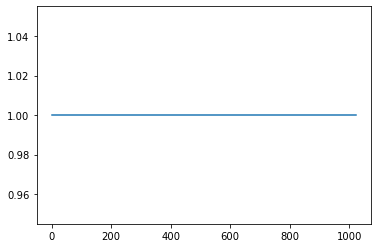

In [11]:
plt.plot(eps_arr)

In [24]:
omega, f, field_temp, eps_arr, eps = eigs_PCs(1, 1, 0, 0, 1, 0, 1)

Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 0.0, 0.0>
elapsed time for initialization: 0.02077031135559082
solve_kpoint (0,0,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1
tefreqs:, 1, 0, 0, 0, 0, 0
elapsed time f

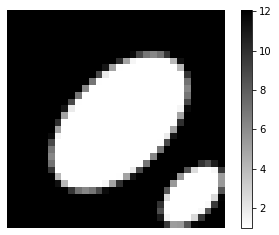

In [26]:
fig, axs = plt.subplots()
    
im = axs.imshow(eps, cmap='binary')
#im=axs.contour(eps, cmap='binary')
fig.colorbar(im, ax=axs)
axs.set_axis_off() 

In [9]:
# Valley chen number 
do_chern = True  # do Chern Number Calc
do_band = False  # do Band Structure Calc
Pxg = 1  # lattice constant along x
Pyg = 1  # lattice constant along y
N_sam = 10  # Brillouin sampling points ***
N_max = 2  # maximum band number ***
np.set_printoptions(precision=3, suppress=True)

Polarflag = 1  # 极化方式，0，TM极化；1，TE极化

shifted = 0.0
Nkxg = 200
Nkyg = 1
Pkxg = (4 * np.pi ) / Pxg / np.sqrt(3)
Pkyg = (4 * np.pi ) / Pyg / np.sqrt(3)
deltakxg = Pkxg / Nkxg
deltakyg = Pkyg / Nkyg
NK = Nkxg * Nkyg
kcx = np.zeros((NK, 4))
kcy = np.zeros((NK, 4))
# initialized
fieldTot = np.zeros(N_max)
ChernNumber = np.zeros(N_max)
fieldtemp = np.zeros(N_max, dtype=complex)
N_Lband = 1
N_Hband = 2
fieldTotComposite = 0
ChernNumberComposite = 0
fieldtempComposite = 0

if do_chern:
    time_s = time.time()
    fields = []
    fields_cur = np.zeros((Nkxg, N_max))
    for m in range(101):
        for n in range(Nkyg+1):
            print('Calculating', m * (Nkyg+1) + n + 1, 'of', (Nkxg+1) * (Nkyg+1), '...')
            omega, f, field_temp, eps_arr, eps = eigs_PCs(Pxg, Pyg,
                                                          # valley photonic crystal K Path
                                                  #(m+0.5-Nkxg/2) * deltakxg * np.sqrt(3), (n-0.5) * deltakxg,  #扫描顶点边，从-pi到+pi，重现董建文论文
                                                  (m  + 0.5-Nkxg/2) * deltakxg * np.sqrt(3) / 2, # 扫描平行四边形Kx
                                                  (n - Nkyg / 2 + 0.5) * deltakyg - (m + 0.5) * deltakxg / 4, # 扫描Ky，要键入kx的1/2
                                                  #(n + 0.5) * deltakyg / 2 - (m - Nkxg / 2 + 0.5) * deltakxg / 2, 
                                                  N_max, 0, Polarflag)
            fields.append(field_temp)

    print(shape(f))

    for m in range(101):
        for n in range(Nkyg+1):
            field1 = fields[m*(Nkyg+1)+n] #将平行四边形分割成若干小网格，每个网格的四个顶点
            field4 = fields[m*(Nkyg+1)+n+1]
            field3 = fields[(m+1)*(Nkyg+1)+n+1]
            field2 = fields[(m+1)*(Nkyg+1)+n]

            for mm in range(N_max): #对每一个能带计算陈数
                temp = field1[:, mm].conj().T * eps_arr @ field2[:, mm] #一行乘以一列变成一个数
                fieldtemp[mm] = temp / np.abs(temp)
                temp = field2[:, mm].conj().T * eps_arr @ field3[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp) #这里是把前面的值再乘新值
                temp = field3[:, mm].conj().T * eps_arr @ field4[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp)
                temp = field4[:, mm].conj().T * eps_arr @ field1[:, mm]
                fieldtemp[mm] *= temp / np.abs(temp)
                fields_cur[m, mm] = -np.imag(np.log(fieldtemp[mm]))/(deltakxg**2*np.sqrt(3))
                fieldTot[mm] = fieldTot[mm] + np.imag(np.log(fieldtemp[mm]))

 
    print('Elapsed:', time.time() - time_s)
    ChernNumber = fieldTot / 2 / np.pi
    print('Chern Number', ChernNumber)

Calculating 1 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.49749999999999994, -0.249375, 0.0>
elapsed time for initialization: 0.037007808685302734
solve_kpoint (-0.4975,-0.249375,0):
tefreqs:, k index, k1, k2, k3

    iteration   29: trace = 0.1185388804414368 (0.00157674% change)
    linmin: converged after 3 iterations.
    iteration   30: trace = 0.1185374339507618 (0.00122027% change)
    linmin: converged after 3 iterations.
    iteration   31: trace = 0.1185360717105156 (0.00114921% change)
    linmin: converged after 2 iterations.
    iteration   32: trace = 0.1185350485060698 (0.000863205% change)
    linmin: converged after 2 iterations.
    iteration   33: trace = 0.1185346410836982 (0.000343715% change)
    linmin: converged after 2 iterations.
    iteration   34: trace = 0.1185344804236526 (0.000135539% change)
    linmin: converged after 2 iterations.
    iteration   35: trace = 0.1185343904191258 (7.59311e-05% change)
    linmin: converged after 2 iterations.
    iteration   36: trace = 0.11853433699418 (4.50713e-05% change)
    linmin: converged after 2 iterations.
    iteration   37: trace = 0.1185343105450815 (2.23135e-05% change)
    linmin: converged after 2 iterations.
    it

Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.4825, -0.245625, 0, 0.482526, 0.178195, 0.294797
elapsed time for k point: 0.04887819290161133
Fixing h-field (band 1) phase by -0.907526 + 0.419995i; max ampl. = 1.23848
Fixing h-field (band 2) phase by -0.816959 + 0.576696i; max ampl. = 1.78669
total elapsed time for run: 0.12547874450683594
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 8 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e

    iteration    5: trace = 0.1190409154532319 (1.04535% change)
    iteration    6: trace = 0.1189108464151504 (0.109324% change)
    iteration    7: trace = 0.1188577349736265 (0.0446749% change)
    iteration    8: trace = 0.1188482041113242 (0.00801904% change)
    iteration    9: trace = 0.1188292218498046 (0.0159731% change)
    iteration   10: trace = 0.1187772049649557 (0.0437841% change)
    iteration   11: trace = 0.1186966658210886 (0.0678299% change)
    iteration   12: trace = 0.1186211137063252 (0.0636717% change)
    iteration   13: trace = 0.1186051168031956 (0.0134866% change)
    iteration   14: trace = 0.118601955607273 (0.00266535% change)
    iteration   15: trace = 0.1186012072483054 (0.000630986% change)
    iteration   16: trace = 0.118601082422947 (0.000105248% change)
    iteration   17: trace = 0.1186010515725975 (2.60119e-05% change)
    iteration   18: trace = 0.1186010389007311 (1.06844e-05% change)
    iteration   19: trace = 0.1186010306735303 (6.93687e-

    iteration   10: trace = 0.1188953045233003 (0.136875% change)
    iteration   11: trace = 0.1186517722383185 (0.205039% change)
    iteration   12: trace = 0.1185308705152733 (0.101948% change)
    iteration   13: trace = 0.1184991942328103 (0.0267276% change)
    iteration   14: trace = 0.1184921582407877 (0.00593776% change)
    iteration   15: trace = 0.1184910300174552 (0.000952155% change)
    iteration   16: trace = 0.1184907764468778 (0.000214% change)
    iteration   17: trace = 0.1184906512526357 (0.000105657% change)
    iteration   18: trace = 0.1184904814643302 (0.000143293% change)
    iteration   19: trace = 0.1184900041217056 (0.000402854% change)
    iteration   20: trace = 0.1184894464522461 (0.000470648% change)
    iteration   21: trace = 0.1184891359324919 (0.000262066% change)
    iteration   22: trace = 0.1184890697163424 (5.58837e-05% change)
    iteration   23: trace = 0.1184890591248522 (8.93879e-06% change)
Finished solving for bands 1 to 2 after 23 iterat

    iteration    7: trace = 0.1189371265282457 (0.0577873% change)
    iteration    8: trace = 0.118909176110906 (0.0235029% change)
    iteration    9: trace = 0.1188316383218081 (0.0652288% change)
    iteration   10: trace = 0.1186624693139454 (0.142462% change)
    iteration   11: trace = 0.1184627586551727 (0.168443% change)
    iteration   12: trace = 0.118374982866352 (0.0741231% change)
    iteration   13: trace = 0.1183554015112244 (0.0165432% change)
    iteration   14: trace = 0.1183507182915316 (0.00395699% change)
    iteration   15: trace = 0.1183499594249339 (0.000641204% change)
    iteration   16: trace = 0.1183497723719646 (0.000158051% change)
    iteration   17: trace = 0.1183496552545752 (9.89587e-05% change)
    iteration   18: trace = 0.1183494659290071 (0.000159972% change)
    iteration   19: trace = 0.1183490039701999 (0.000390335% change)
    iteration   20: trace = 0.1183485902186382 (0.000349604% change)
    iteration   21: trace = 0.1183484249342709 (0.000

    iteration   21: trace = 0.118192215790054 (7.0324e-05% change)
    iteration   22: trace = 0.118192194154267 (1.83056e-05% change)
    iteration   23: trace = 0.1181921892577315 (4.14286e-06% change)
Finished solving for bands 1 to 2 after 23 iterations.
tefreqs:, 1, -0.4625, 0.759375, 0, 1.23384, 0.171548, 0.297932
elapsed time for k point: 0.08859872817993164
Fixing h-field (band 1) phase by -0.472314 + 0.88143i; max ampl. = 1.21512
Fixing h-field (band 2) phase by 0.939442 + 0.342709i; max ampl. = 1.86491
total elapsed time for run: 0.14609646797180176
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 17 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell 

    iteration   21: trace = 0.1180291155580732 (6.80498e-05% change)
    iteration   22: trace = 0.1180290919165079 (2.00303e-05% change)
    iteration   23: trace = 0.118029087030588 (4.13959e-06% change)
Finished solving for bands 1 to 2 after 23 iterations.
tefreqs:, 1, -0.4575, 0.760625, 0, 1.23063, 0.169865, 0.298622
elapsed time for k point: 0.0737309455871582
Fixing h-field (band 1) phase by 0.507266 + 0.861789i; max ampl. = 1.21103
Fixing h-field (band 2) phase by -0.129324 + -0.991602i; max ampl. = 1.87969
total elapsed time for run: 0.1163332462310791
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 19 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cel

Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.4475, -0.23687500000000006, 0.0>
elapsed time for initialization: 0.05170726776123047
solve_kpoint (-0.4475,-0.236875,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.3797548668188636 (198.686% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1483917405819673 (87.6132% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1248819900661889 (17.206% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 81.4693%)
    iteration    4: trace = 0.1198880939533269 (4.08048% change)
    iteration    5: trace = 0.1184126288395183 (1.23832% change)
    iteration    6: trace = 0.1182113006999928 (0.170167% change)
    iter

    iteration   16: trace = 0.1175300734501636 (4.2275e-05% change)
    iteration   17: trace = 0.1175300390370754 (2.92802e-05% change)
    iteration   18: trace = 0.1175299836632946 (4.71146e-05% change)
    iteration   19: trace = 0.1175299108983407 (6.19118e-05% change)
    iteration   20: trace = 0.1175298586179607 (4.44826e-05% change)
    iteration   21: trace = 0.1175298436192742 (1.27616e-05% change)
    switching back to exact line minimization
    iteration   22: trace = 0.1175298409726905 (2.25184e-06% change)
Finished solving for bands 1 to 2 after 22 iterations.
tefreqs:, 1, -0.4425, -0.235625, 0, 0.442811, 0.164775, 0.300631
elapsed time for k point: 0.11167287826538086
Fixing h-field (band 1) phase by 0.465747 + -0.884918i; max ampl. = 1.19969
Fixing h-field (band 2) phase by 0.910753 + 0.412951i; max ampl. = 2.00794
total elapsed time for run: 0.1611614227294922
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793

    iteration    9: trace = 0.1174678467609736 (0.360363% change)
    iteration   10: trace = 0.1173055154463734 (0.138288% change)
    iteration   11: trace = 0.117256357339608 (0.0419148% change)
    iteration   12: trace = 0.1172450417014534 (0.00965081% change)
    iteration   13: trace = 0.1172433438606585 (0.00144812% change)
    iteration   14: trace = 0.1172426407881486 (0.000599671% change)
    iteration   15: trace = 0.117242203687432 (0.000372818% change)
    iteration   16: trace = 0.1172416056972453 (0.000510048% change)
    iteration   17: trace = 0.1172407309409916 (0.000746117% change)
    iteration   18: trace = 0.1172403968484655 (0.000284963% change)
    iteration   19: trace = 0.1172402939242728 (8.77891e-05% change)
    iteration   20: trace = 0.1172402671278631 (2.2856e-05% change)
    iteration   21: trace = 0.1172402616952267 (4.63376e-06% change)
Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, -0.4325, 0.766875, 0, 1.21481, 0.161358, 0.302
e

     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.42249999999999993, -0.23062500000000002, 0.0>
elapsed time for initialization: 0.046994686126708984
solve_kpoint (-0.4225,-0.230625,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterations.
    iteration    1: trace = 0.7063832438308402 (197.525% change)
    linmin: converged after 6 iterations.
  

    iteration    6: trace = 0.1170427547736949 (0.223419% change)
    iteration    7: trace = 0.1169151180762943 (0.109111% change)
    iteration    8: trace = 0.1168988401610412 (0.0139238% change)
    iteration    9: trace = 0.116885038851092 (0.0118069% change)
    iteration   10: trace = 0.1168666828820481 (0.0157055% change)
    iteration   11: trace = 0.1168493186189391 (0.0148593% change)
    iteration   12: trace = 0.1168350899373807 (0.0121777% change)
    iteration   13: trace = 0.1168297136707943 (0.00460169% change)
    iteration   14: trace = 0.1168285745574899 (0.000975025% change)
    iteration   15: trace = 0.1168281699692721 (0.00034631% change)
    iteration   16: trace = 0.1168280745827054 (8.16469e-05% change)
    iteration   17: trace = 0.1168280559079362 (1.59848e-05% change)
    iteration   18: trace = 0.1168280506600651 (4.49196e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.4175, -0.229375, 0, 0.418179, 0.156194, 0.304025
el

    iteration   11: trace = 0.1166468784821501 (0.073607% change)
    iteration   12: trace = 0.1166251122453391 (0.0186617% change)
    iteration   13: trace = 0.1166213566553106 (0.00322028% change)
    iteration   14: trace = 0.1166191922353462 (0.00185596% change)
    iteration   15: trace = 0.1166174295045594 (0.00151154% change)
    iteration   16: trace = 0.1166154745144268 (0.00167643% change)
    iteration   17: trace = 0.1166140850196293 (0.00119153% change)
    iteration   18: trace = 0.1166137406293961 (0.000295325% change)
    iteration   19: trace = 0.1166136398355549 (8.6434e-05% change)
    switching back to exact line minimization
    iteration   20: trace = 0.1166136155336364 (2.08397e-05% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 64.7783%)
    iteration   21: trace = 0.1166136087901215 (5.78279e-06% change)
Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, -0.4075, 0.773125, 0,

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.39749999999999996, -0.22437500000000005, 0.0>
elapsed time for initialization: 0.044138193130493164
solve_kpoint (-0.3975,-0.224375,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged

    iteration    5: trace = 0.118519152132617 (1.0948% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 64.723%)
    iteration    6: trace = 0.118012707761772 (0.428225% change)
    iteration    7: trace = 0.117594034780187 (0.3554% change)
    iteration    8: trace = 0.1170522014227654 (0.46183% change)
    iteration    9: trace = 0.1165243294196039 (0.451991% change)
    iteration   10: trace = 0.1163857766907907 (0.118975% change)
    iteration   11: trace = 0.1163426190300957 (0.0370884% change)
    iteration   12: trace = 0.1163317830297098 (0.0093143% change)
    iteration   13: trace = 0.1163297563207715 (0.0017422% change)
    iteration   14: trace = 0.1163285869478015 (0.00100523% change)
    iteration   15: trace = 0.1163277921795541 (0.000683212% change)
    iteration   16: trace = 0.116326851766789 (0.00080842% change)
    iteration   17: trace = 0.1163262768229081 (0.00049425% change)
    iteration   18: tra

Calculating 46 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.3875, 0.7781250000000002, 0.0>
elapsed time for initialization: 0.03818368911743164
solve_kpoint (-0.3875,0.778125,0):
tefreqs:, k index, k1, k2, k3, kma

    iteration   13: trace = 0.1162040707150911 (0.00190107% change)
    iteration   14: trace = 0.1162017631787002 (0.00198578% change)
    iteration   15: trace = 0.1162001378782416 (0.0013987% change)
    iteration   16: trace = 0.1161990689218148 (0.000919931% change)
    iteration   17: trace = 0.1161987416864761 (0.000281617% change)
    iteration   18: trace = 0.116198669717624 (6.1936e-05% change)
    iteration   19: trace = 0.1161986445615127 (2.16492e-05% change)
    iteration   20: trace = 0.1161986375787617 (6.00932e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, -0.3825, 0.779375, 0, 1.18425, 0.144057, 0.308944
elapsed time for k point: 0.04992842674255371
Fixing h-field (band 1) phase by -0.326781 + -0.9451i; max ampl. = 1.16086
Fixing h-field (band 2) phase by -0.261483 + -0.965208i; max ampl. = 1.98999
total elapsed time for run: 0.10855507850646973
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, 

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 7 iterations.
    iteration    1: trace = 0.5766635890245154 (197.909% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1473805009806759 (118.579% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1215882438350507 (19.1786% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 73.8579%)
    iteration    4: trace = 0.1184357973374229 (2.62678% change)
    switching back to exact line minimization
    iteration    5: trace = 0.1171939987654818 (1.05403% change)
    linmin: converged after 4 iterations.
    iteration    6: trace = 0.1169402730763847 (0.216735% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 72.4108%)
    iteration    7: trace = 0.116631399182943

total elapsed time for run: 0.11098623275756836
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 54 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random 

    iteration    2: trace = 0.1480477781527355 (100.726% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1231849822079031 (18.3332% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 64.4351%)
    iteration    4: trace = 0.1188056769923271 (3.6194% change)
    iteration    5: trace = 0.1173574022549115 (1.2265% change)
    iteration    6: trace = 0.1169179058723277 (0.375197% change)
    iteration    7: trace = 0.1166304964440673 (0.246124% change)
    iteration    8: trace = 0.1163764019553069 (0.2181% change)
    iteration    9: trace = 0.1161286956373737 (0.213076% change)
    iteration   10: trace = 0.1160583556262497 (0.0605891% change)
    iteration   11: trace = 0.1160341113054911 (0.0208919% change)
    iteration   12: trace = 0.1160291511358796 (0.00427484% change)
    iteration   13: trace = 0.116028460916721 (0.000594869% change)
    iteration   14: trace = 0.1160282220513973 (0.0

Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.3525, -0.21312500000000004, 0.0>
elapsed time for initialization: 0.036426544189453125
solve_kpoint (-0.3525,-0.213125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iteration    1: trace = 0.4668998822746853 (1

    iteration   10: trace = 0.1161419639867655 (0.269742% change)
    iteration   11: trace = 0.1160586233268994 (0.0717833% change)
    iteration   12: trace = 0.1160241192400022 (0.0297343% change)
    iteration   13: trace = 0.1160088375583536 (0.013172% change)
    iteration   14: trace = 0.115992737777852 (0.013879% change)
    iteration   15: trace = 0.1159864605662969 (0.00541187% change)
    iteration   16: trace = 0.1159846442801934 (0.00156596% change)
    iteration   17: trace = 0.1159841964840544 (0.000386083% change)
    iteration   18: trace = 0.1159840875254631 (9.39427e-05% change)
    iteration   19: trace = 0.115984018818089 (5.92386e-05% change)
    iteration   20: trace = 0.1159839790534541 (3.42846e-05% change)
    iteration   21: trace = 0.1159839507576613 (2.43963e-05% change)
    iteration   22: trace = 0.115983936661999 (1.21531e-05% change)
    iteration   23: trace = 0.1159839313371817 (4.591e-06% change)
Finished solving for bands 1 to 2 after 23 iterations.

Fixing h-field (band 1) phase by 0.997157 + 0.0753491i; max ampl. = 1.143
Fixing h-field (band 2) phase by 0.610102 + 0.792323i; max ampl. = 2.12818
total elapsed time for run: 0.11266446113586426
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 64 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1804533835395905 (94.5167% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1440650451127922 (22.4261% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1263686063319795 (13.0875% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 70.5389%)
    iteration    5: trace = 0.1211575987361334 (4.21047% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1192372591414628 (1.59765% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 73.2085%)
    iteration    7: trace = 0.1182391407452077 (0.840604% change)
    iteration    8: trace = 0.1174077660538423 (0.705611% change)
    iteration    9: trace = 0.1166590358051892 (0.639758% change)
    iteration   10: trace = 0.1161997580044164 (0.394469% change)
    i

Fixing h-field (band 2) phase by 0.778995 + -0.627031i; max ampl. = 2.04646
total elapsed time for run: 0.13097548484802246
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 69 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating

    iteration    2: trace = 0.1641662028630224 (97.3301% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1353538333044168 (19.239% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1249027084316899 (8.0314% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.5887%)
    iteration    5: trace = 0.1215286653933758 (2.73832% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1198028634597391 (1.43023% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 66.4372%)
    iteration    7: trace = 0.1184991701256605 (1.09415% change)
    iteration    8: trace = 0.1173476971250806 (0.976458% change)
    iteration    9: trace = 0.1165706759166482 (0.664352% change)
    iteration   10: trace = 0.1162439422654483 (0.280681% change)
    iteration   11: trace = 0.116164688608549 (0.0

tefreqs:, 1, -0.3175, -0.204375, 0, 0.321841, 0.121477, 0.318436
elapsed time for k point: 0.057756662368774414
Fixing h-field (band 1) phase by 0.994662 + -0.103188i; max ampl. = 1.13279
Fixing h-field (band 2) phase by 0.90154 + 0.432697i; max ampl. = 2.15719
total elapsed time for run: 0.09040355682373047
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 74 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0

    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 66.0145%)
    iteration    5: trace = 0.1167957662081215 (1.93363% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1164405812275032 (0.304571% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 61.0471%)
    iteration    7: trace = 0.1162729996062656 (0.144024% change)
    switching back to exact line minimization
    iteration    8: trace = 0.1162441179270938 (0.0248426% change)
    linmin: converged after 2 iterations.
    switching to approximate line minimization (decrease time by 67.0394%)
    iteration    9: trace = 0.1162375551071055 (0.00564588% change)
    iteration   10: trace = 0.1162334350371614 (0.00354459% change)
    iteration   11: trace = 0.1162312458272294 (0.00188348% change)
    iteration   12: trace = 0.116228970983627 (0.00195719% change)
    iteration   13: tr

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.3025, -0.20062500000000003, 0.0>
elapsed time for initialization: 0.034502267837524414
solve_kpoint (-0.3025,-0.200625,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iter

    iteration   10: trace = 0.1165981944196428 (0.237139% change)
    iteration   11: trace = 0.1164808709785567 (0.100673% change)
    iteration   12: trace = 0.1164566645922242 (0.0207836% change)
    iteration   13: trace = 0.1164490045159459 (0.00657784% change)
    iteration   14: trace = 0.11644624629869 (0.00236863% change)
    iteration   15: trace = 0.1164452875987989 (0.000823302% change)
    iteration   16: trace = 0.116444422061217 (0.000743303% change)
    iteration   17: trace = 0.1164440127944772 (0.00035147% change)
    iteration   18: trace = 0.1164438661894579 (0.000125902% change)
    iteration   19: trace = 0.1164438242728787 (3.59972e-05% change)
    iteration   20: trace = 0.1164438172230241 (6.0543e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, -0.2975, -0.199375, 0, 0.303189, 0.114608, 0.321417
elapsed time for k point: 0.05851578712463379
Fixing h-field (band 1) phase by 0.391939 + -0.919991i; max ampl. = 1.12594
Fixing h-field

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.2925, 0.8018750000000003, 0.0>
elapsed time for initialization: 0.026046037673950195
solve_kpoint (-0.2925,0.801875,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 9 iterati

    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4524052446429124 (198.462% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1899485618629794 (81.7172% change)
    linmin: converged after 6 iterations.
    iteration    3: trace = 0.1480363505353537 (24.8012% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 0.1265314156752208 (15.6646% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1202728436145658 (5.07169% change)
    linmin: converged after 3 iterations.
    switching to approximate line minimization (decrease time by 74.8227%)
    iteration    6: trace = 0.1182660851766236 (1.68254% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1174565598312574 (0.686846% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 75.6066%)
    iteration    8: trace = 0.1171447813158469 (0.2657

Fixing h-field (band 1) phase by 0.459923 + -0.887959i; max ampl. = 1.11343
Fixing h-field (band 2) phase by -0.308538 + -0.951212i; max ampl. = 2.10903
total elapsed time for run: 0.09102535247802734
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 89 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 ob

    switching to approximate line minimization (decrease time by 96.2335%)
    iteration    4: trace = 0.119234588889224 (4.49273% change)
    iteration    5: trace = 0.1177727810408972 (1.23355% change)
    iteration    6: trace = 0.1173380968389969 (0.36977% change)
    iteration    7: trace = 0.1171622727359204 (0.149956% change)
    iteration    8: trace = 0.1170814923575867 (0.0689712% change)
    iteration    9: trace = 0.1170227968427879 (0.0501448% change)
    iteration   10: trace = 0.1169941246956708 (0.0245043% change)
    iteration   11: trace = 0.1169797681504847 (0.0122719% change)
    iteration   12: trace = 0.1169770836229379 (0.00229489% change)
    iteration   13: trace = 0.1169763317653202 (0.000642741% change)
    iteration   14: trace = 0.1169761167417983 (0.000183818% change)
    iteration   15: trace = 0.1169760743668771 (3.62253e-05% change)
    iteration   16: trace = 0.1169760551833789 (1.63995e-05% change)
    iteration   17: trace = 0.1169760469635817 (7.026

          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.26749999999999996, 0.8081250000000001, 0.0>
elapsed time for initialization: 0.0401003360748291
solve_kpoint (-0.2675,0.808125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.5026944976239301 (198.266% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1866854933485196 (91.6792% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1428394552551337 (26.6117% change)
    linmin: converged after 5 iterations.
  

    iteration   16: trace = 0.1172479551858334 (6.45193e-05% change)
    iteration   17: trace = 0.1172479251207801 (2.56423e-05% change)
    iteration   18: trace = 0.1172479132107333 (1.0158e-05% change)
    iteration   19: trace = 0.1172479028724781 (8.81743e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.2625, 0.809375, 0, 1.11741, 0.102793, 0.326621
elapsed time for k point: 0.07335972785949707
Fixing h-field (band 1) phase by -0.531034 + 0.847351i; max ampl. = 1.10762
Fixing h-field (band 2) phase by 0.915334 + -0.402695i; max ampl. = 2.13986
total elapsed time for run: 0.10392451286315918
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 97 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lat

    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1612168516297587 (83.6808% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1333433447426675 (18.9255% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1222775148115515 (8.658% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 62.4868%)
    iteration    5: trace = 0.1191130175977292 (2.62189% change)
    iteration    6: trace = 0.1182616908989732 (0.717285% change)
    iteration    7: trace = 0.1179054418502874 (0.301692% change)
    iteration    8: trace = 0.1177503423036026 (0.131632% change)
    iteration    9: trace = 0.1176302057562957 (0.102079% change)
    iteration   10: trace = 0.1175623785238032 (0.057678% change)
    iteration   11: trace = 0.1175363343639243 (0.0221559% change)
    iteration   12: trace = 0.1175281419132992 (0.00697039% change)
    iteration   13: trace = 0.1175

Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.24749999999999997, 0.8131250000000002, 0.0>
elapsed time for initialization: 0.028876781463623047
solve_kpoint (-0.2475,0.813125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 8 iterations.
    iter

    iteration   14: trace = 0.1178459454941862 (0.000153101% change)
    iteration   15: trace = 0.1178458998767478 (3.87094e-05% change)
    iteration   16: trace = 0.1178458833963407 (1.39847e-05% change)
    iteration   17: trace = 0.1178458776237326 (4.89844e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, -0.2425, 0.814375, 0, 1.10725, 0.0962066, 0.32953
elapsed time for k point: 0.07300782203674316
Fixing h-field (band 1) phase by -0.937927 + -0.346832i; max ampl. = 1.10364
Fixing h-field (band 2) phase by 0.433157 + -0.901318i; max ampl. = 2.17193
total elapsed time for run: 0.10959124565124512
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 105 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.


    iteration    1: trace = 0.5484485215741859 (197.952% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1890467887985385 (97.4655% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1464322279882744 (25.4052% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1272562600379238 (14.013% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 63.8143%)
    iteration    5: trace = 0.1219229127938377 (4.28073% change)
    iteration    6: trace = 0.1198118902301572 (1.74656% change)
    iteration    7: trace = 0.1189805631024853 (0.696276% change)
    iteration    8: trace = 0.1185922997920088 (0.326858% change)
    iteration    9: trace = 0.1183957433132332 (0.165879% change)
    iteration   10: trace = 0.1182494661773572 (0.123626% change)
    iteration   11: trace = 0.1181987352003888 (0.0429109% change)
    iteration   12: trace = 0.1181755

total elapsed time for run: 0.10964202880859375
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 110 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random

    iteration    9: trace = 0.1185919377547998 (0.0740008% change)
    iteration   10: trace = 0.118550508966511 (0.03494% change)
    iteration   11: trace = 0.1185302498221851 (0.0170905% change)
    iteration   12: trace = 0.1185268696104028 (0.00285181% change)
    iteration   13: trace = 0.118525888669332 (0.000827614% change)
    iteration   14: trace = 0.1185257058044846 (0.000154283% change)
    iteration   15: trace = 0.1185256600076486 (3.86387e-05% change)
    iteration   16: trace = 0.1185256428828337 (1.44482e-05% change)
    iteration   17: trace = 0.1185256379553228 (4.15734e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, -0.2225, 0.819375, 0, 1.09739, 0.0897899, 0.33236
elapsed time for k point: 0.04291081428527832
Fixing h-field (band 1) phase by 0.695624 + 0.718406i; max ampl. = 1.10093
Fixing h-field (band 2) phase by -0.386053 + -0.922477i; max ampl. = 2.20575
total elapsed time for run: 0.08292055130004883
done
mu: 1-1, mean 1, harm

1 k-points
  Vector3<-0.2125, -0.17812500000000003, 0.0>
elapsed time for initialization: 0.044635772705078125
solve_kpoint (-0.2125,-0.178125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.5415047984007183 (197.978% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1897818789041634 (96.1929% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1481463491880426 (24.6416% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1285354672545177 (14.1758% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 69.7433%)
    iteration    5: trace = 0.1229916961905695 (4.40809% change)
    iteration    6: trace = 0.1206765106110262 (1.90028% change)
    iteration    7: trace = 0.1197615610825945 (0.761069% cha

Fixing h-field (band 2) phase by 0.383525 + 0.92353i; max ampl. = 2.31344
total elapsed time for run: 0.08997607231140137
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 118 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating 

    iteration    5: trace = 0.1210461117904938 (3.0839% change)
    iteration    6: trace = 0.1199251219694239 (0.930393% change)
    iteration    7: trace = 0.1195214491070416 (0.337172% change)
    iteration    8: trace = 0.1193987807452863 (0.102686% change)
    iteration    9: trace = 0.1193372743939829 (0.0515267% change)
    iteration   10: trace = 0.1192934502250795 (0.0367297% change)
    iteration   11: trace = 0.1192756819432083 (0.0148957% change)
    iteration   12: trace = 0.1192666051514895 (0.00761022% change)
    iteration   13: trace = 0.1192643173530057 (0.00191824% change)
    iteration   14: trace = 0.1192634165267159 (0.000755322% change)
    iteration   15: trace = 0.1192631897641579 (0.000190136% change)
    iteration   16: trace = 0.119263125422715 (5.39491e-05% change)
    iteration   17: trace = 0.119263103311673 (1.85397e-05% change)
    iteration   18: trace = 0.1192630960512567 (6.08773e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tef

     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.1925, -0.17312500000000003, 0.0>
elapsed time for initialization: 0.035675764083862305
solve_kpoint (-0.1925,-0.173125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.4194619316502767 (198.454% change)
    linmin: converged after 7 iterations.
    iteration 

    iteration   15: trace = 0.1198296490778004 (0.000270157% change)
    iteration   16: trace = 0.1198295743369978 (6.23726e-05% change)
    iteration   17: trace = 0.1198295471599082 (2.26798e-05% change)
    iteration   18: trace = 0.1198295415058204 (4.71844e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.1875, -0.171875, 0, 0.208073, 0.0791193, 0.337001
elapsed time for k point: 0.06423473358154297
Fixing h-field (band 1) phase by -0.705283 + 0.708926i; max ampl. = 1.09987
Fixing h-field (band 2) phase by 0.371395 + 0.928475i; max ampl. = 2.34567
total elapsed time for run: 0.10321378707885742
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 126 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.4180537857480629 (198.632% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1722782639777586 (83.2669% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1478864600771699 (15.237% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1357933982187918 (8.52585% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (decrease time by 75.3138%)
    iteration    5: trace = 0.1296045872054172 (4.6638% change)
    iteration    6: trace = 0.1252838582991183 (3.39029% change)
    iteration    7: trace = 0.1230137907668923 (1.82851% change)
    iteration    8: trace = 0.1214097164611532 (1.31254% change)
    iteration    9: trace = 0.1205813481264408 (0.684627% change)
    iteration 

    iteration   18: trace = 0.1202212989943193 (8.14762e-05% change)
    iteration   19: trace = 0.1202212394098182 (4.95624e-05% change)
    iteration   20: trace = 0.1202212113405342 (2.3348e-05% change)
    iteration   21: trace = 0.1202212052917387 (5.03139e-06% change)
Finished solving for bands 1 to 2 after 21 iterations.
tefreqs:, 1, -0.1775, 0.830625, 0, 1.07634, 0.0762451, 0.338242
elapsed time for k point: 0.07724928855895996
Fixing h-field (band 1) phase by -0.239184 + 0.970974i; max ampl. = 1.09732
Fixing h-field (band 2) phase by -0.140879 + -0.990027i; max ampl. = 2.2826
total elapsed time for run: 0.10959386825561523
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 131 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
L

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 11 iterations.
    iteration    1: trace = 0.4405691546143619 (198.548% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1769608070593676 (85.3751% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1440257601894254 (20.5211% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1278786232571713 (11.8771% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 63.945%)
    iteration    5: trace = 0.1235323682303342 (3.45749% change)
    switching back to exact line minimization
    iteration    6: trace = 0.1217193937080498 (1.47846% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 67.4334%)
    iteration    7: trace = 0.1211040266018034

    iteration   20: trace = 0.1207834625773672 (4.04079e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, -0.1625, -0.165625, 0, 0.189469, 0.0721079, 0.339976
elapsed time for k point: 0.04555201530456543
Fixing h-field (band 1) phase by 0.845843 + -0.533432i; max ampl. = 1.0955
Fixing h-field (band 2) phase by 0.156437 + -0.987688i; max ampl. = 2.38471
total elapsed time for run: 0.08507847785949707
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 136 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objec

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.4706817979353814 (198.347% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1764790011561456 (90.9211% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1423504322683603 (21.4087% change)
    linmin: converged after 4 iterations.
    iteration    4: trace = 0.1281592632688844 (10.4922% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 0.1232843568806851 (3.87753% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 66.044%)
    iteration    6: trace = 0.1216013391485319 (1.37453% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1211089726904007 (0.405724% change)
    linmin: converged after 4 iterations.
    switching

    iteration   17: trace = 0.1211564570582703 (2.39848e-05% change)
    iteration   18: trace = 0.1211564516377215 (4.47401e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.1525, 0.836875, 0, 1.06536, 0.0694929, 0.341068
elapsed time for k point: 0.050986289978027344
Fixing h-field (band 1) phase by 0.592728 + 0.805402i; max ampl. = 1.09281
Fixing h-field (band 2) phase by 0.748961 + -0.662614i; max ampl. = 2.32248
total elapsed time for run: 0.08580756187438965
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 141 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1

    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.4335662070127587 (198.467% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1924234630290247 (77.0437% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1561667375016951 (20.8019% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.135529619253232 (14.1497% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1264345819010207 (6.94373% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 76.5161%)
    iteration    6: trace = 0.1230812607572228 (2.68786% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1220811098539107 (0.815909% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 84.2548%)
    iteration    8: trace = 

    iteration   15: trace = 0.121670291645268 (0.000161417% change)
    iteration   16: trace = 0.1216702397340693 (4.26655e-05% change)
    iteration   17: trace = 0.1216702213847751 (1.50812e-05% change)
    iteration   18: trace = 0.1216702168795452 (3.70282e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.1375, -0.159375, 0, 0.172791, 0.0658069, 0.342549
elapsed time for k point: 0.05134868621826172
Fixing h-field (band 1) phase by -0.10649 + 0.994314i; max ampl. = 1.09131
Fixing h-field (band 2) phase by 0.954664 + 0.297685i; max ampl. = 2.42011
total elapsed time for run: 0.09117650985717773
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 146 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
L

tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.7227984984548264 (197.408% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.2539602889381952 (95.9988% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1771817736413698 (35.6163% change)
    linmin: converged after 6 iterations.
    iteration    4: trace = 0.1467458075471051 (18.7918% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1327738386467707 (9.99713% change)
    linmin: converged after 5 iterations.
    iteration    6: trace = 0.1256030800521213 (5.55062% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 73.4301%)
    iteration    7: trace = 0.1227657769483003 (2.28475% change)
    iteration    8: trace = 0.1221844821195644 (0.474623% c

    linmin: converged after 9 iterations.
    iteration    1: trace = 0.4281039365479968 (198.413% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.178955298932971 (82.0838% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1504810461077132 (17.2866% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1328719025580953 (12.4291% change)
    linmin: converged after 4 iterations.
    iteration    5: trace = 0.1275578486682365 (4.08099% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 72.2452%)
    iteration    6: trace = 0.1242404778875484 (2.63494% change)
    switching back to exact line minimization
    iteration    7: trace = 0.1232713458876367 (0.7831% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 74.204%)
    iteration    8: trace = 0.1227381542763308 (0.433472% 

    iteration   11: trace = 0.1224533055689907 (0.0476559% change)
    iteration   12: trace = 0.1224241263689901 (0.0238317% change)
    iteration   13: trace = 0.1224181389007484 (0.00489088% change)
    iteration   14: trace = 0.1224162583545455 (0.00153618% change)
    iteration   15: trace = 0.1224157482094388 (0.000416731% change)
    iteration   16: trace = 0.1224156142917114 (0.000109396% change)
    iteration   17: trace = 0.122415541799686 (5.9218e-05% change)
    iteration   18: trace = 0.1224155143147456 (2.24522e-05% change)
    iteration   19: trace = 0.1224154947798372 (1.59579e-05% change)
    iteration   20: trace = 0.122415485568048 (7.52502e-06% change)
Finished solving for bands 1 to 2 after 20 iterations.
tefreqs:, 1, -0.1125, -0.153125, 0, 0.158648, 0.0604524, 0.344617
elapsed time for k point: 0.04753541946411133
Fixing h-field (band 1) phase by 0.934905 + -0.354898i; max ampl. = 1.08758
Fixing h-field (band 2) phase by -0.584644 + 0.81129i; max ampl. = 2.44799
t

          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.1075, 0.8481250000000002, 0.0>
elapsed time for initialization: 0.025121450424194336
solve_kpoint (-0.1075,0.848125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.5278253627641751 (198.046% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.1978131092804778 (90.9578% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.160083395139789 (21.0841% change)
    linmin: converged after 5 iterations.
    iteration 

    iteration   10: trace = 0.1226762768817048 (0.0125561% change)
    iteration   11: trace = 0.1226678387159852 (0.00687864% change)
    iteration   12: trace = 0.1226654737109108 (0.00192799% change)
    iteration   13: trace = 0.1226647895432838 (0.000557752% change)
    iteration   14: trace = 0.1226642333396266 (0.000453435% change)
    iteration   15: trace = 0.1226639860571019 (0.000201593% change)
    iteration   16: trace = 0.1226638244935384 (0.000131712% change)
    iteration   17: trace = 0.1226637648237072 (4.8645e-05% change)
    iteration   18: trace = 0.1226637522959068 (1.02131e-05% change)
    iteration   19: trace = 0.1226637480152629 (3.48974e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.1025, 0.849375, 0, 1.04499, 0.0586404, 0.34529
elapsed time for k point: 0.05584573745727539
Fixing h-field (band 1) phase by -0.804418 + -0.594064i; max ampl. = 1.08285
Fixing h-field (band 2) phase by 0.991816 + 0.127674i; max ampl. = 2.38591

Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.09250000000000001, -0.148125, 0.0>
elapsed time for initialization: 0.07505345344543457
solve_kpoint (-0.0925,-0.148125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 it

    switching to approximate line minimization (decrease time by 75.8939%)
    iteration    8: trace = 0.1230318350052269 (0.0897252% change)
    iteration    9: trace = 0.1229800312999269 (0.0421148% change)
    iteration   10: trace = 0.1229700626541982 (0.00810623% change)
    iteration   11: trace = 0.1229634452685328 (0.00538144% change)
    iteration   12: trace = 0.1229589779090263 (0.00363315% change)
    iteration   13: trace = 0.1229571914857711 (0.00145287% change)
    iteration   14: trace = 0.1229563847595384 (0.000656105% change)
    iteration   15: trace = 0.122956240074309 (0.000117672% change)
    iteration   16: trace = 0.1229561949719657 (3.66816e-05% change)
    iteration   17: trace = 0.1229561772090106 (1.44466e-05% change)
    iteration   18: trace = 0.1229561731963261 (3.26351e-06% change)
Finished solving for bands 1 to 2 after 18 iterations.
tefreqs:, 1, -0.0875, -0.146875, 0, 0.14777, 0.0563265, 0.346098
elapsed time for k point: 0.04534029960632324
Fixing h-

Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.08249999999999999, 0.8543750000000002, 0.0>
elapsed time for initialization: 0.03489112854003906
solve_kpoint (-0.0825,0.854375,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.4373601515040673 (198.519% change)
    linmin: con

    iteration    7: trace = 0.124175304244618 (1.19555% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 76.0406%)
    iteration    8: trace = 0.1237403334661348 (0.350902% change)
    iteration    9: trace = 0.1234049004903482 (0.271446% change)
    iteration   10: trace = 0.1232981631113209 (0.0865311% change)
    iteration   11: trace = 0.123220942778479 (0.0626486% change)
    iteration   12: trace = 0.1231630142166363 (0.047023% change)
    iteration   13: trace = 0.1231332375600619 (0.0241795% change)
    iteration   14: trace = 0.123122159472178 (0.00899723% change)
    iteration   15: trace = 0.1231153496636558 (0.00553109% change)
    iteration   16: trace = 0.1231119901962088 (0.00272875% change)
    iteration   17: trace = 0.1231110262108751 (0.000783018% change)
    iteration   18: trace = 0.1231105399177894 (0.000395004% change)
    iteration   19: trace = 0.1231103238884095 (0.000175476% change)
    iterati

    iteration   21: trace = 0.1231699383460057 (5.21124e-05% change)
    iteration   22: trace = 0.1231698950401527 (3.51594e-05% change)
    iteration   23: trace = 0.1231698737186042 (1.73107e-05% change)
    iteration   24: trace = 0.1231698649105052 (7.15118e-06% change)
Finished solving for bands 1 to 2 after 24 iterations.
tefreqs:, 1, -0.0725, 0.856875, 0, 1.03384, 0.054566, 0.346688
elapsed time for k point: 0.05023956298828125
Fixing h-field (band 1) phase by -0.192241 + 0.981348i; max ampl. = 1.0812
Fixing h-field (band 2) phase by 0.080033 + -0.996792i; max ampl. = 2.40914
total elapsed time for run: 0.0916130542755127
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 173 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lat

total elapsed time for run: 0.14310050010681152
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 175 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random

     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.057499999999999996, -0.13937500000000003, 0.0>
elapsed time for initialization: 0.047812700271606445
solve_kpoint (-0.0575,-0.139375,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.4697600930176629 (198.367% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1939736403860536 (83.1015% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1559448406674596 (21.7358% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1390145185497522 (11.

    iteration    9: trace = 0.1233601921478329 (0.0725716% change)
    iteration   10: trace = 0.123331140165518 (0.0235533% change)
    iteration   11: trace = 0.1233148399619965 (0.0132175% change)
    iteration   12: trace = 0.1233081138335433 (0.00545458% change)
    iteration   13: trace = 0.1233064920020813 (0.00131528% change)
    iteration   14: trace = 0.1233059951975666 (0.000402903% change)
    iteration   15: trace = 0.1233058921989891 (8.35309e-05% change)
    iteration   16: trace = 0.1233058729362763 (1.56219e-05% change)
    iteration   17: trace = 0.1233058638133679 (7.3986e-06% change)
Finished solving for bands 1 to 2 after 17 iterations.
tefreqs:, 1, -0.0525, -0.138125, 0, 0.139443, 0.0531611, 0.347102
elapsed time for k point: 0.06971383094787598
Fixing h-field (band 1) phase by 0.754664 + -0.656111i; max ampl. = 1.08448
Fixing h-field (band 2) phase by -0.965791 + 0.259322i; max ampl. = 2.47623
total elapsed time for run: 0.11557483673095703
done
mu: 1-1, mean 1, 

     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.047499999999999994, 0.863125, 0.0>
elapsed time for initialization: 0.05307936668395996
solve_kpoint (-0.0475,0.863125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.6487370081598685 (197.605% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.2089144966878073 (102.564% change)
    linmin: converged after 5 iterations.
    iteration    3: trace = 0.1627914777261995 (24.8169% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1409841528944576 (14.3575% change)


    iteration   12: trace = 0.1233343007169403 (0.0241691% change)
    iteration   13: trace = 0.1233266688684901 (0.00618813% change)
    iteration   14: trace = 0.1233237941112474 (0.00233104% change)
    iteration   15: trace = 0.1233230578572909 (0.000597011% change)
    iteration   16: trace = 0.1233227114780591 (0.000280872% change)
    iteration   17: trace = 0.1233226121074149 (8.05778e-05% change)
    iteration   18: trace = 0.1233225884314807 (1.91984e-05% change)
    iteration   19: trace = 0.1233225810097864 (6.01811e-06% change)
Finished solving for bands 1 to 2 after 19 iterations.
tefreqs:, 1, -0.0425, 0.864375, 0, 1.02351, 0.0528939, 0.347167
elapsed time for k point: 0.08429574966430664
Fixing h-field (band 1) phase by 0.355443 + -0.934698i; max ampl. = 1.08043
Fixing h-field (band 2) phase by -0.02698 + -0.999636i; max ampl. = 2.41588
total elapsed time for run: 0.11686444282531738
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.4991

1 k-points
  Vector3<-0.032499999999999994, -0.13312500000000002, 0.0>
elapsed time for initialization: 0.047129154205322266
solve_kpoint (-0.0325,-0.133125,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 10 iterations.
    iteration    1: trace = 0.5597141973379867 (197.919% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1588969976152805 (111.553% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1327095891947981 (17.9608% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 69.4767%)
    iteration    4: trace = 0.1263343593160922 (4.92212% change)
    switching back to exact line minimization
    iteration    5: trace = 0.1246398162371625 (1.35037% change)
    linmin: converged after 4 iterations.
    switching to approximate line minimization (decrease time by 7

    iteration   13: trace = 0.1232778351450051 (0.0101216% change)
    iteration   14: trace = 0.1232734532936807 (0.00355452% change)
    iteration   15: trace = 0.1232718935591773 (0.00126527% change)
    iteration   16: trace = 0.1232711681231962 (0.000588486% change)
    iteration   17: trace = 0.1232710163696723 (0.000123106% change)
    iteration   18: trace = 0.1232709581995296 (4.71888e-05% change)
    iteration   19: trace = 0.1232709328468792 (2.05666e-05% change)
    iteration   20: trace = 0.1232709139481372 (1.53311e-05% change)
    iteration   21: trace = 0.1232709009608651 (1.05356e-05% change)
    iteration   22: trace = 0.1232708970339094 (3.18563e-06% change)
Finished solving for bands 1 to 2 after 22 iterations.
tefreqs:, 1, -0.0275, -0.131875, 0, 0.139144, 0.0530426, 0.34707
elapsed time for k point: 0.058563947677612305
Fixing h-field (band 1) phase by 0.997561 + 0.0697936i; max ampl. = 1.0849
Fixing h-field (band 2) phase by 0.999494 + 0.0317986i; max ampl. = 2.47

epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 192 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0.333333,0)
          radius 0.121468, height 1e+20, axis (0, 0, 1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.022499999999999996, 0.8693750000000001, 0.0>
elapsed time for initia

Initializing epsilon function...
Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<-0.0175, 0.8706250000000002, 0.0>
elapsed time for initialization: 0.02591729164123535
solve_kpoint (-0.0175,0.870625,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 13 iterations.
    iteration    1: trace = 0.5094701676566387 (198.15% change)
    linmin: converged after 6 iterations.
    iteration    2: trace = 0.2046634405278587 (85.3641% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1786130996615632 (13.5935% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1649444601556768 (7.95712% change)
    linmin: converged after 6 iterations.
    iteration    5: trace = 0.1476570455460703 (11.0604% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1303

    linmin: converged after 5 iterations.
    iteration    4: trace = 0.1580435977070177 (6.99627% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1474991332249686 (6.90212% change)
    linmin: converged after 6 iterations.
    iteration    6: trace = 0.1368609740243866 (7.48217% change)
    linmin: converged after 6 iterations.
    switching to approximate line minimization (decrease time by 73.0594%)
    iteration    7: trace = 0.1307198474151902 (4.59011% change)
    iteration    8: trace = 0.1284187259286083 (1.77598% change)
    iteration    9: trace = 0.1254759250641623 (2.31813% change)
    iteration   10: trace = 0.1242407030286302 (0.989299% change)
    iteration   11: trace = 0.1235191689576682 (0.582446% change)
    iteration   12: trace = 0.1232266770924707 (0.237079% change)
    iteration   13: trace = 0.1231832504718104 (0.0352475% change)
    iteration   14: trace = 0.1231667178518242 (0.0134221% change)
    iteration   15: trace = 0.12316

tefreqs:, 1, -0.0075, 0.873125, 0, 1.01256, 0.0542655, 0.346639
elapsed time for k point: 0.06703591346740723
Fixing h-field (band 1) phase by 0.747273 + -0.664517i; max ampl. = 1.0809
Fixing h-field (band 2) phase by 0.499235 + -0.866467i; max ampl. = 2.40755
total elapsed time for run: 0.12069082260131836
done
mu: 1-1, mean 1, harm. mean 1, 0% > 1, 100% "fill"
epsilon: 1-12.0409, mean 8.49918, harm. mean 2.85793, 72.9492% > 1, 67.9218% "fill"
Calculating 199 of 402 ...
Initializing eigensolver data
Computing 2 bands with 1e-07 tolerance
Working in 2 dimensions.
Grid size is 32 x 32 x 1.
Solving for 2 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0.5, 0.866025, 0)
     (0, 0, 1)
Cell volume = 0.866025
Reciprocal lattice vectors (/ 2 pi):
     (1, -0.57735, 0)
     (-0, 1.1547, -0)
     (0, -0, 1)
Geometric objects:
     cylinder, center = (0,0,0)
          radius 0.27143, height 1e+20, axis (0, 0, 1)
     cylinder, center = (0.333333,0

Allocating fields...
Solving for band polarization: te.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0024999999999999996, -0.12437500000000004, 0.0>
elapsed time for initialization: 0.05003857612609863
solve_kpoint (0.0025,-0.124375,0):
tefreqs:, k index, k1, k2, k3, kmag/2pi, te band 1, te band 2
Solving for bands 1 to 2...
    near maximum in trace
    linmin: converged after 12 iterations.
    iteration    1: trace = 0.4109729224379424 (198.603% change)
    linmin: converged after 7 iterations.
    iteration    2: trace = 0.1802948938735137 (78.0283% change)
    linmin: converged after 4 iterations.
    iteration    3: trace = 0.1537227986670796 (15.9106% change)
    linmin: converged after 5 iterations.
    iteration    4: trace = 0.136399672674673 (11.9419% change)
    linmin: converged after 5 iterations.
    iteration    5: trace = 0.1287458243312987 (5.77332% change)
    linmin: converged after 5 iterations.
    switching to approximate line minimization (dec

IndexError: list index out of range